In [1]:
import sys
sys.path.append('../')

from models import scalar, gauge
import pickle
import time
from typing import Callable, Sequence

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
#import sympy
#import optuna
from util import *
from itertools import product
from functools import partial


import matplotlib
import matplotlib.pyplot as plt
import scipy.special as special

matplotlib.style.use('default') # 'classic'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.rcParams['axes.prop_cycle'] = plt.cycler(color='krbg')
matplotlib.rcParams['legend.numpoints'] = 1

%load_ext autoreload
%autoreload 2

@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)


@jax.jit
def sinh(x: any) -> any:
    return jnp.sinh(x)

jax.config.update("jax_default_matmul_precision", "highest")
# jax.config.update("jax_enable_x64", True)

# jax.config.update("jax_platform_name","cpu")
num_devices = jax.local_device_count()
jax.devices()

# jax.config.values

[CpuDevice(id=0)]

# Scalar 2D

In [2]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = arcsinh(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


## 16x16

### sweep 1

jack bin size 1: (np.float32(0.0035599817), np.complex128(0.00011990010885560842+0j))
bin size 1: (np.float32(0.0035599817), np.complex128(0.00011990134551381811+0j))
jack bin size 2: (np.float32(0.0035599817), np.complex128(0.00016616923800916614+0j))
bin size 2: (np.float32(0.0035599817), np.complex128(0.00016616854843756865+0j))
jack bin size 4: (np.float32(0.0035599817), np.complex128(0.00022852820528731658+0j))
bin size 4: (np.float32(0.0035599817), np.complex128(0.0002285271755981584+0j))
jack bin size 5: (np.float32(0.0035599817), np.complex128(0.000252333894924349+0j))
bin size 5: (np.float32(0.0035599817), np.complex128(0.0002523335635520957+0j))
jack bin size 10: (np.float32(0.0035599817), np.complex128(0.0003383680647163182+0j))
bin size 10: (np.float32(0.0035599817), np.complex128(0.0003383683100943418+0j))
jack bin size 20: (np.float32(0.0035599817), np.complex128(0.0004391619184387924+0j))
bin size 20: (np.float32(0.0035599817), np.complex128(0.00043916189680241264+0j))
j

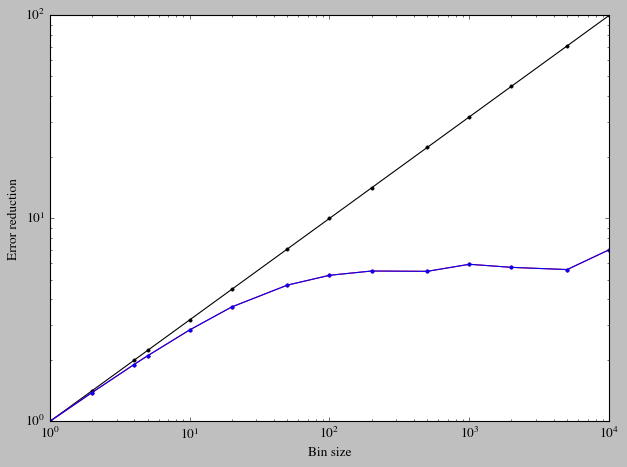

In [7]:
with open("1+1scalar/config/c_16x16_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("scalar.Model(geom=(16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.0033101449), np.complex128(0.0012624836104335145+0j))
bin size 1: (np.float32(0.0033101449), np.complex128(0.001262483418330687+0j))
jack bin size 2: (np.float32(0.0033101449), np.complex128(0.0012882012218904814+0j))
bin size 2: (np.float32(0.0033101449), np.complex128(0.0012882011538157129+0j))
jack bin size 4: (np.float32(0.0033101449), np.complex128(0.001331282124044772+0j))
bin size 4: (np.float32(0.0033101449), np.complex128(0.0013312818556874364+0j))
jack bin size 5: (np.float32(0.0033101449), np.complex128(0.0012140257665835099+0j))
bin size 5: (np.float32(0.0033101449), np.complex128(0.001214025826929648+0j))
jack bin size 10: (np.float32(0.0033101449), np.complex128(0.0012974860942215186+0j))
bin size 10: (np.float32(0.0033101449), np.complex128(0.0012974860401081857+0j))
jack bin size 20: (np.float32(0.0033101449), np.complex128(0.00145346338103991+0j))
bin size 20: (np.float32(0.0033101449), np.complex128(0.001453463387276445+0j))
jack bin siz

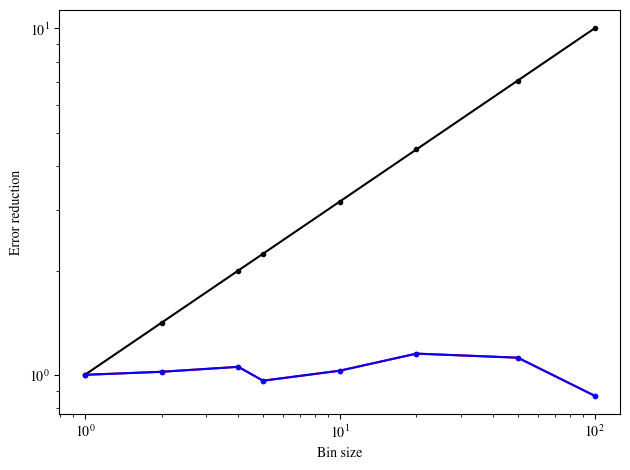

In [25]:
with open("1+1scalar/config/c_16x16_0.1_0.5_sweep1.pkl", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("scalar.Model(geom=(16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [3]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

FileNotFoundError: [Errno 2] No such file or directory: 'correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs1_10min.pkl'

In [35]:
for i in range(5):
    print(len(track_red[i]))

63
61
61
59
58


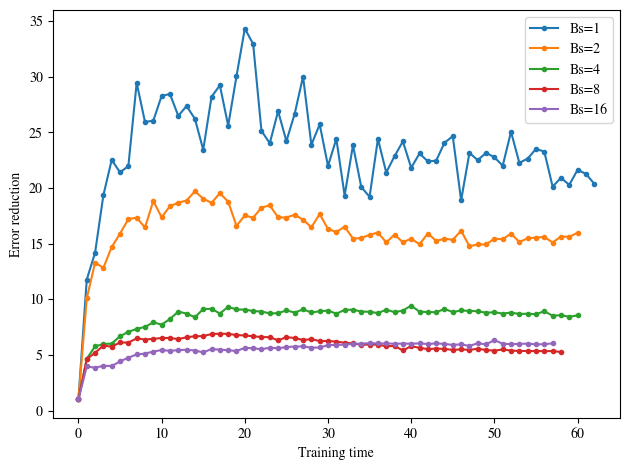

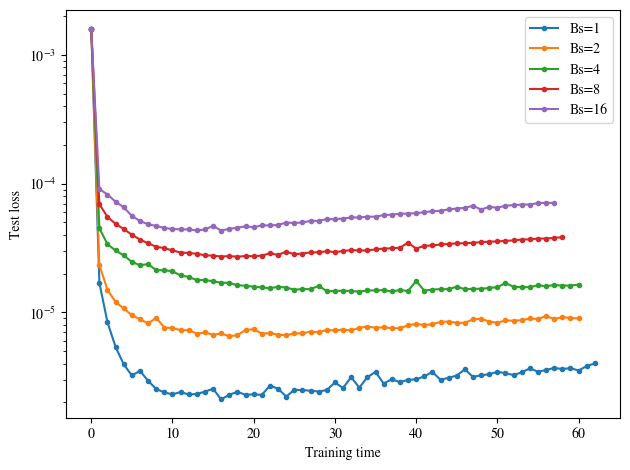

1: (34.3240819294631+0j)
2: (19.705244743080645+0j)
4: (9.429180145968058+0j)
8: (6.905078976815836+0j)
16: (6.332729807327411+0j)
1: 2.1077521523693576e-06
2: 6.522116564156022e-06
4: 1.4499386452371255e-05
8: 2.7063109882874414e-05
16: 4.3229640141362324e-05


In [58]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.065557405), np.complex128(0.0004388260598136669+0j))
bin size 1: (np.float32(0.065557405), np.complex128(0.0004388045557918774+0j))
jack bin size 2: (np.float32(0.065557405), np.complex128(0.0006181085660653912+0j))
bin size 2: (np.float32(0.065557405), np.complex128(0.0006180990855351279+0j))
jack bin size 4: (np.float32(0.065557405), np.complex128(0.000869248605675147+0j))
bin size 4: (np.float32(0.065557405), np.complex128(0.0008692373835591271+0j))
jack bin size 5: (np.float32(0.065557405), np.complex128(0.0009693441490778686+0j))
bin size 5: (np.float32(0.065557405), np.complex128(0.000969348539370731+0j))
jack bin size 10: (np.float32(0.065557405), np.complex128(0.0013545326766626735+0j))
bin size 10: (np.float32(0.065557405), np.complex128(0.0013545271031914542+0j))
jack bin size 20: (np.float32(0.065557405), np.complex128(0.0018751387205107606+0j))
bin size 20: (np.float32(0.065557405), np.complex128(0.0018751393911356272+0j))
jack bin size 50: (n

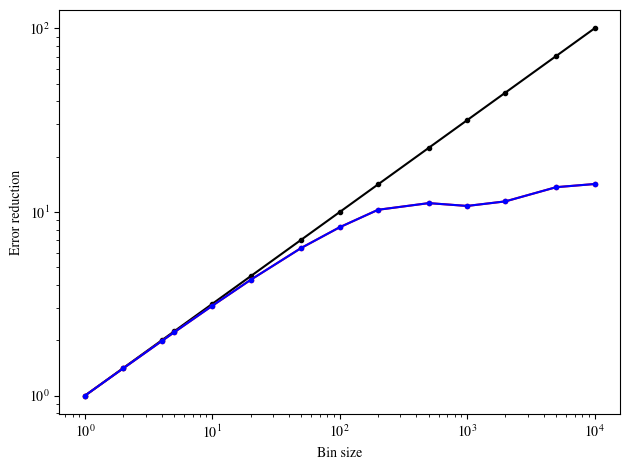

In [12]:
with open("1+1scalar/config/c_16x16_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(16,16), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.figure()
plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.078593336), np.complex128(0.00489830404182541+0j))
bin size 1: (np.float32(0.078593336), np.complex128(0.004898308620985921+0j))
jack bin size 2: (np.float32(0.078593336), np.complex128(0.005772180148283258+0j))
bin size 2: (np.float32(0.078593336), np.complex128(0.005772177205108095+0j))
jack bin size 4: (np.float32(0.078593336), np.complex128(0.006013793747521481+0j))
bin size 4: (np.float32(0.078593336), np.complex128(0.006013787043199039+0j))
jack bin size 5: (np.float32(0.078593336), np.complex128(0.006225483422368818+0j))
bin size 5: (np.float32(0.078593336), np.complex128(0.0062254830118087644+0j))
jack bin size 10: (np.float32(0.078593336), np.complex128(0.006251611006124835+0j))
bin size 10: (np.float32(0.078593336), np.complex128(0.006251611760786449+0j))
jack bin size 20: (np.float32(0.078593336), np.complex128(0.0061893746023997664+0j))
bin size 20: (np.float32(0.078593336), np.complex128(0.006189368665218353+0j))
jack bin size 50: (np.float32

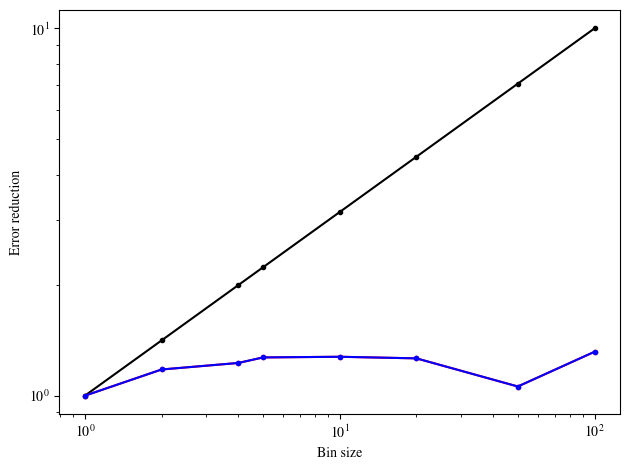

In [6]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

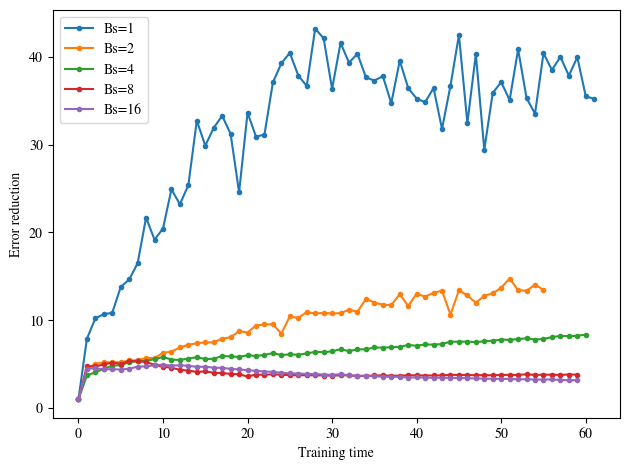

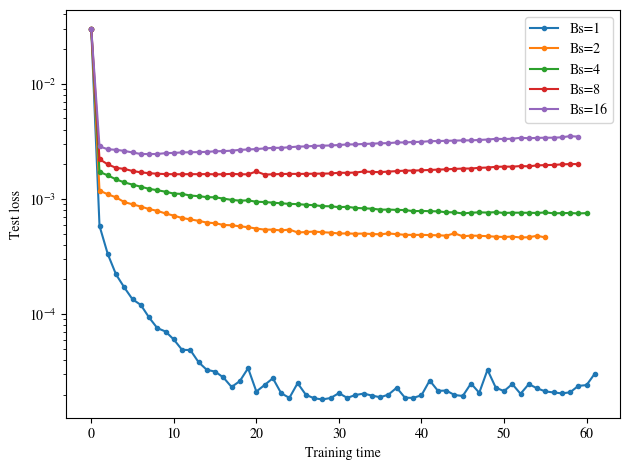

1: (43.20208309675784+0j)
2: (14.747408755880095+0j)
4: (8.375460058373042+0j)
8: (5.387705881481165+0j)
16: (4.95499374416715+0j)
1: 1.8182647181674838e-05
2: 0.00046290556201711297
4: 0.0007479118648916483
8: 0.0016279509291052818
16: 0.002452331129461527


In [7]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

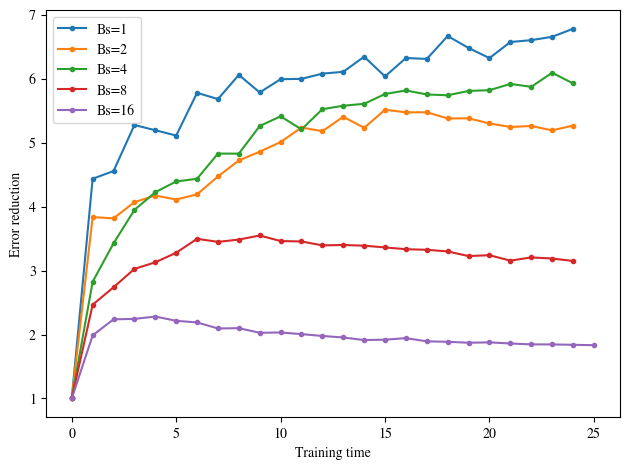

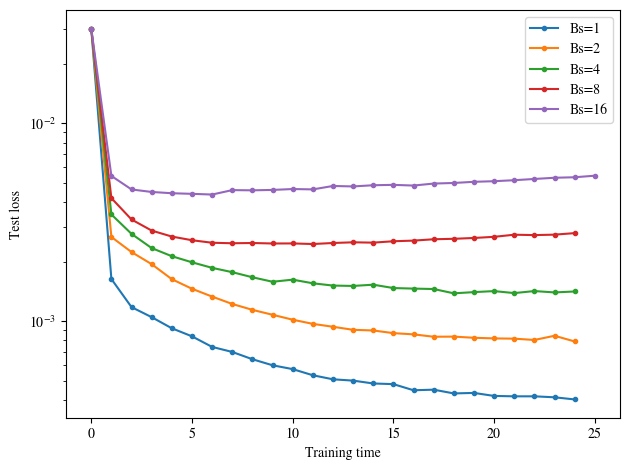

1: (6.777571476203764+0j)
2: (5.511897315763944+0j)
4: (6.091323968322977+0j)
8: (3.5477638587046805+0j)
16: (2.280729672745637+0j)
1: 0.00040297716623172164
2: 0.0007908176048658788
4: 0.0013847507070749998
8: 0.0024575917050242424
16: 0.004370136186480522


In [4]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_16x16_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 32x32

### sweep1

jack bin size 1: (np.float32(0.00065247447), np.complex128(4.173853890612223e-05+0j))
bin size 1: (np.float32(0.00065247447), np.complex128(4.173851563280876e-05+0j))
jack bin size 2: (np.float32(0.00065247447), np.complex128(5.7839381876118265e-05+0j))
bin size 2: (np.float32(0.00065247447), np.complex128(5.783936656696748e-05+0j))
jack bin size 4: (np.float32(0.00065247447), np.complex128(7.956361531187648e-05+0j))
bin size 4: (np.float32(0.00065247447), np.complex128(7.956354803482777e-05+0j))
jack bin size 5: (np.float32(0.00065247447), np.complex128(8.78603020005591e-05+0j))
bin size 5: (np.float32(0.00065247447), np.complex128(8.786031180461224e-05+0j))
jack bin size 10: (np.float32(0.00065247447), np.complex128(0.00011768341191849774+0j))
bin size 10: (np.float32(0.00065247447), np.complex128(0.00011768340900342145+0j))
jack bin size 20: (np.float32(0.00065247447), np.complex128(0.00015181783123277714+0j))
bin size 20: (np.float32(0.00065247447), np.complex128(0.0001518177917258

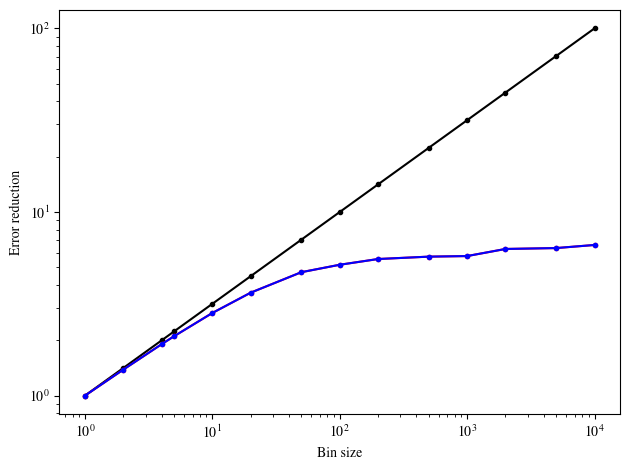

In [24]:
with open("1+1scalar/config/c_32x32_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,32), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.0006131623), np.complex128(0.0004222745404850524+0j))
bin size 1: (np.float32(0.0006131623), np.complex128(0.0004222744954807351+0j))
jack bin size 2: (np.float32(0.0006131623), np.complex128(0.0004181769095040834+0j))
bin size 2: (np.float32(0.0006131623), np.complex128(0.0004181768751409825+0j))
jack bin size 4: (np.float32(0.0006131623), np.complex128(0.0004267986374798736+0j))
bin size 4: (np.float32(0.0006131623), np.complex128(0.00042679863482857696+0j))
jack bin size 5: (np.float32(0.0006131623), np.complex128(0.0004219635886413771+0j))
bin size 5: (np.float32(0.0006131623), np.complex128(0.00042196353719242577+0j))
jack bin size 10: (np.float32(0.0006131623), np.complex128(0.0004224714873840385+0j))
bin size 10: (np.float32(0.0006131623), np.complex128(0.00042247141242976+0j))
jack bin size 20: (np.float32(0.0006131623), np.complex128(0.0004815695428987965+0j))
bin size 20: (np.float32(0.0006131623), np.complex128(0.00048156957408147197+0j))
jack 

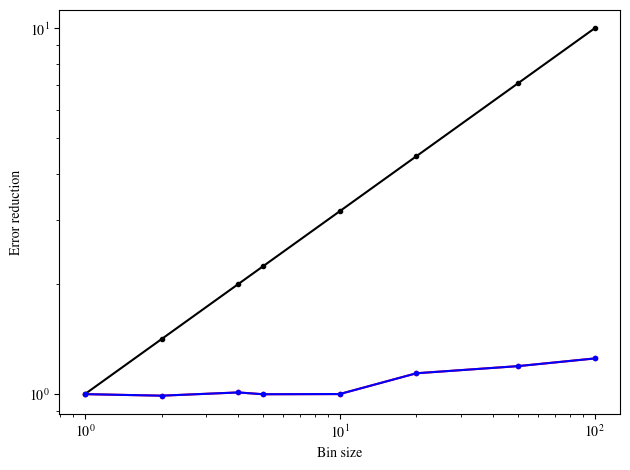

In [26]:
with open("1+1scalar/config/c_32x32_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(32, 32), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [59]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

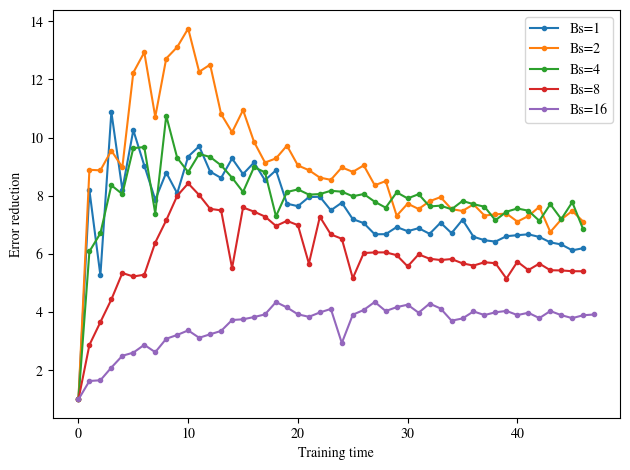

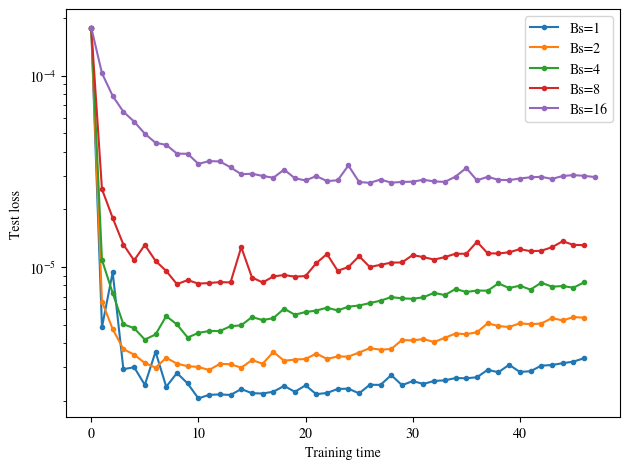

1: (10.885841944175047+0j)
2: (13.751947680098638+0j)
4: (10.753384325995032+0j)
8: (8.428379083255344+0j)
16: (4.35135756494623+0j)
1: 2.053789785350091e-06
2: 2.8915353595948545e-06
4: 4.169336989434669e-06
8: 8.126274224196095e-06
16: 2.7524543838808313e-05


In [60]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [65]:
for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, params, _, _, _= pickle.load(aa)
        print(f"{binsize}: {params['params']['bias']}")

1: [0.00413172]
2: [0.00407802]
4: [0.00415864]
8: [0.00421862]
16: [0.00422097]


In [66]:
for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "rb") as aa:
        _, params, _, _, _= pickle.load(aa)
        print(f"{binsize}: {params['params']['bias']}")

1: [0.00019273]
2: [0.00014368]
4: [0.0002122]
8: [0.00027203]
16: [0.0003855]


### sweep 1 pkl

jack bin size 1: (np.float32(0.00065247447), np.complex128(4.173853890612223e-05+0j))
bin size 1: (np.float32(0.00065247447), np.complex128(4.173851563280876e-05+0j))
jack bin size 2: (np.float32(0.00065247447), np.complex128(5.7839381876118265e-05+0j))
bin size 2: (np.float32(0.00065247447), np.complex128(5.783936656696748e-05+0j))
jack bin size 4: (np.float32(0.00065247447), np.complex128(7.956361531187648e-05+0j))
bin size 4: (np.float32(0.00065247447), np.complex128(7.956354803482777e-05+0j))
jack bin size 5: (np.float32(0.00065247447), np.complex128(8.78603020005591e-05+0j))
bin size 5: (np.float32(0.00065247447), np.complex128(8.786031180461224e-05+0j))
jack bin size 10: (np.float32(0.00065247447), np.complex128(0.00011768341191849774+0j))
bin size 10: (np.float32(0.00065247447), np.complex128(0.00011768340900342145+0j))
jack bin size 20: (np.float32(0.00065247447), np.complex128(0.00015181783123277714+0j))
bin size 20: (np.float32(0.00065247447), np.complex128(0.0001518177917258

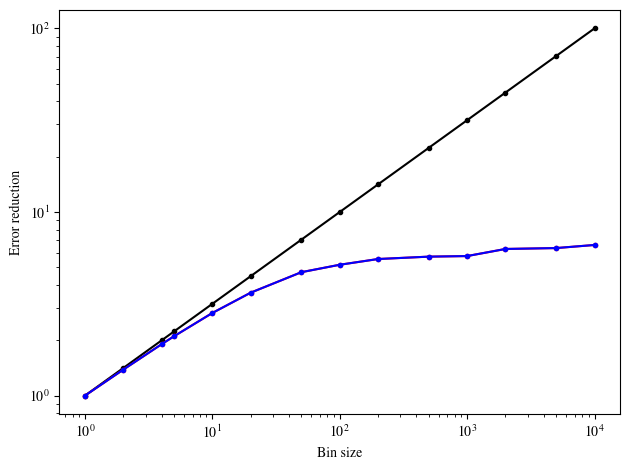

In [34]:
with open("1+1scalar/config/c_32x32_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,32), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.0006131623), np.complex128(0.0004222745404850524+0j))
bin size 1: (np.float32(0.0006131623), np.complex128(0.0004222744954807351+0j))
jack bin size 2: (np.float32(0.0006131623), np.complex128(0.0004181769095040834+0j))
bin size 2: (np.float32(0.0006131623), np.complex128(0.0004181768751409825+0j))
jack bin size 4: (np.float32(0.0006131623), np.complex128(0.0004267986374798736+0j))
bin size 4: (np.float32(0.0006131623), np.complex128(0.00042679863482857696+0j))
jack bin size 5: (np.float32(0.0006131623), np.complex128(0.0004219635886413771+0j))
bin size 5: (np.float32(0.0006131623), np.complex128(0.00042196353719242577+0j))
jack bin size 10: (np.float32(0.0006131623), np.complex128(0.0004224714873840385+0j))
bin size 10: (np.float32(0.0006131623), np.complex128(0.00042247141242976+0j))
jack bin size 20: (np.float32(0.0006131623), np.complex128(0.0004815695428987965+0j))
bin size 20: (np.float32(0.0006131623), np.complex128(0.00048156957408147197+0j))
jack 

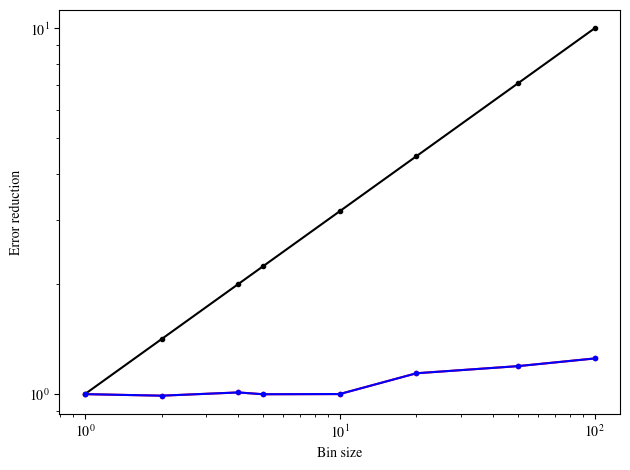

In [35]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [36]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1pkl_bs"+str(binsize)+"_30min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

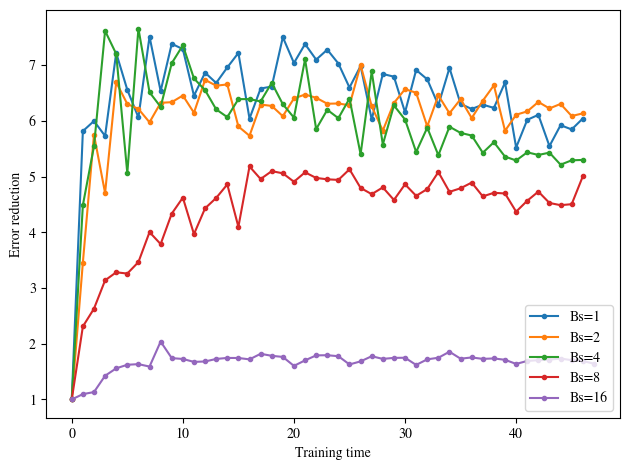

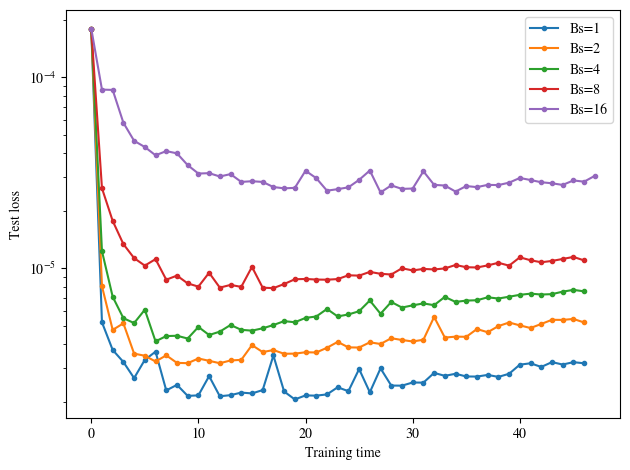

1: (7.5139371531118755+0j)
2: (7.003334964038695+0j)
4: (7.658296912507547+0j)
8: (5.182172048416707+0j)
16: (2.038390829514556+0j)
1: 2.055921413557371e-06
2: 3.1823947210796177e-06
4: 4.143275873502716e-06
8: 7.872892638260964e-06
16: 2.497310379112605e-05


In [37]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.0026315446), np.complex128(0.00014273143569922456+0j))
bin size 1: (np.float32(0.0026315446), np.complex128(0.00014273153766844907+0j))
jack bin size 2: (np.float32(0.0026315446), np.complex128(0.00020098165458615512+0j))
bin size 2: (np.float32(0.0026315446), np.complex128(0.0002009828085752801+0j))
jack bin size 4: (np.float32(0.0026315446), np.complex128(0.00028248541666714677+0j))
bin size 4: (np.float32(0.0026315446), np.complex128(0.0002824858900202818+0j))
jack bin size 5: (np.float32(0.0026315446), np.complex128(0.00031500438186016113+0j))
bin size 5: (np.float32(0.0026315446), np.complex128(0.00031500483356931857+0j))
jack bin size 10: (np.float32(0.0026315446), np.complex128(0.0004398784454796216+0j))
bin size 10: (np.float32(0.0026315446), np.complex128(0.0004398786801819173+0j))
jack bin size 20: (np.float32(0.0026315446), np.complex128(0.0006075311153360856+0j))
bin size 20: (np.float32(0.0026315446), np.complex128(0.0006075311862781992+0j))


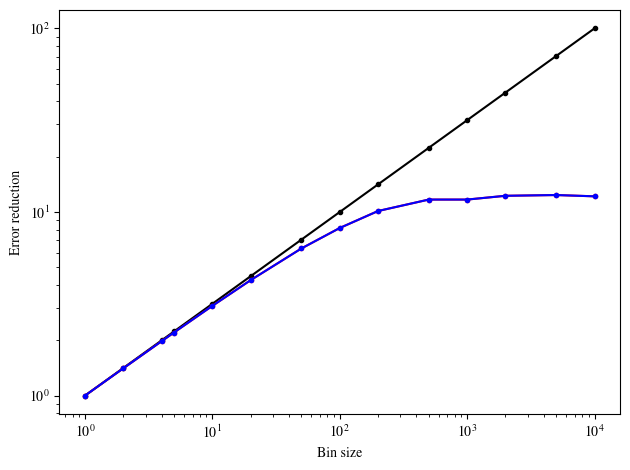

In [8]:
with open("1+1scalar/config/c_32x32_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(32,32), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.008287754), np.complex128(0.0015618052385260464+0j))
bin size 1: (np.float32(0.008287754), np.complex128(0.0015618049145179821+0j))
jack bin size 2: (np.float32(0.008287754), np.complex128(0.0017909385512296157+0j))
bin size 2: (np.float32(0.008287754), np.complex128(0.0017909388935577583+0j))
jack bin size 4: (np.float32(0.008287754), np.complex128(0.002016864425449643+0j))
bin size 4: (np.float32(0.008287754), np.complex128(0.0020168651087925497+0j))
jack bin size 5: (np.float32(0.008287754), np.complex128(0.0021385200681596737+0j))
bin size 5: (np.float32(0.008287754), np.complex128(0.0021385195884852403+0j))
jack bin size 10: (np.float32(0.008287754), np.complex128(0.002421368290586533+0j))
bin size 10: (np.float32(0.008287754), np.complex128(0.0024213679907694186+0j))
jack bin size 20: (np.float32(0.008287754), np.complex128(0.002365384018048644+0j))
bin size 20: (np.float32(0.008287754), np.complex128(0.0023653842508792877+0j))
jack bin size 50: (np

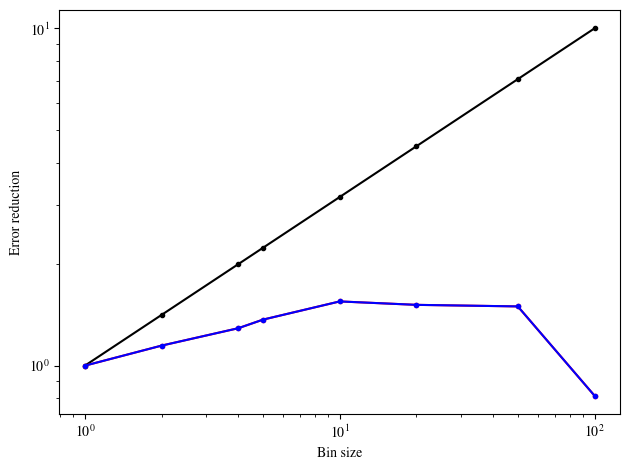

In [9]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

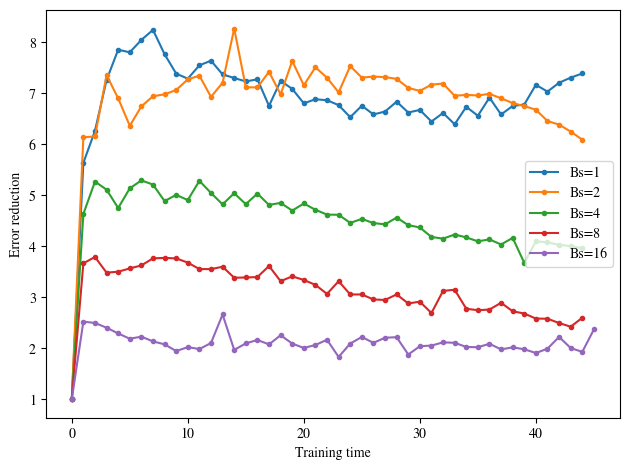

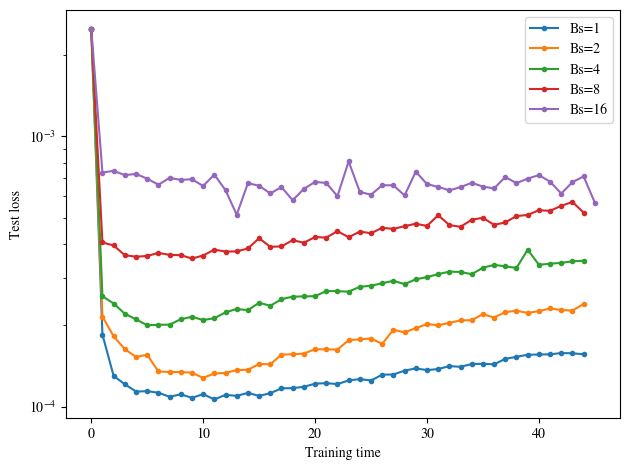

1: (8.244107149580337+0j)
2: (8.270930949376027+0j)
4: (5.2940578303672305+0j)
8: (3.7922831200741927+0j)
16: (2.665026837314087+0j)
1: 0.00010631282202666625
2: 0.00012775893264915794
4: 0.0001999982341658324
8: 0.00035321706673130393
16: 0.000512978935148567


In [10]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

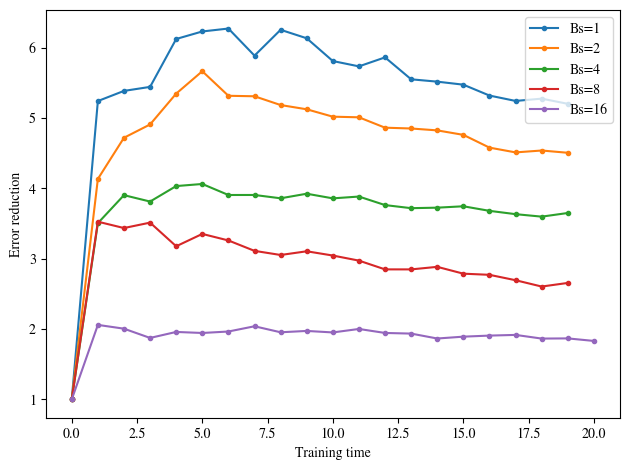

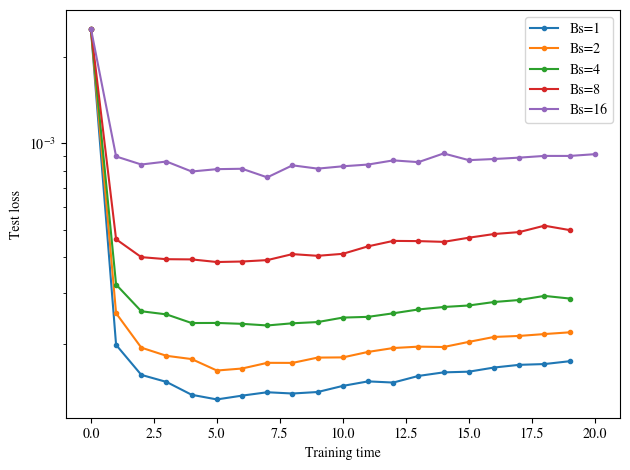

1: (6.274183320684425+0j)
2: (5.6672207519319+0j)
4: (4.063797222752127+0j)
8: (3.527593326798778+0j)
16: (2.059858192867392+0j)
1: 0.00012801312550436705
2: 0.00016140977095346898
4: 0.00023167225299403071
8: 0.0003852873924188316
16: 0.0007596660288982093


In [5]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_32x32_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_30min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 64x64

### sweep 1

jack bin size 1: (np.float32(-0.00011681759), np.complex128(1.5184064248561982e-05+0j))
bin size 1: (np.float32(-0.00011681759), np.complex128(1.5183940980571554e-05+0j))
jack bin size 2: (np.float32(-0.00011681759), np.complex128(2.106718902346507e-05+0j))
bin size 2: (np.float32(-0.00011681759), np.complex128(2.1067126046067775e-05+0j))
jack bin size 4: (np.float32(-0.00011681759), np.complex128(2.9006970784600497e-05+0j))
bin size 4: (np.float32(-0.00011681759), np.complex128(2.9006846226500887e-05+0j))
jack bin size 5: (np.float32(-0.00011681759), np.complex128(3.205068531276222e-05+0j))
bin size 5: (np.float32(-0.00011681759), np.complex128(3.20506346561429e-05+0j))
jack bin size 10: (np.float32(-0.00011681759), np.complex128(4.306167623485459e-05+0j))
bin size 10: (np.float32(-0.00011681759), np.complex128(4.3061698707887046e-05+0j))
jack bin size 20: (np.float32(-0.00011681759), np.complex128(5.578129629670032e-05+0j))
bin size 20: (np.float32(-0.00011681759), np.complex128(5.57

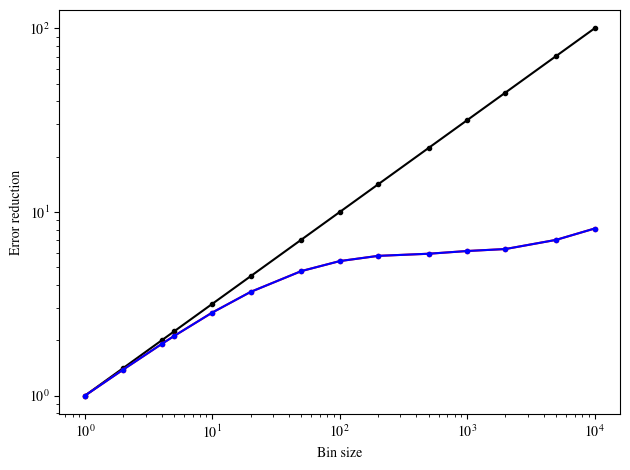

In [40]:
with open("1+1scalar/config/c_64x64_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(64,64), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(-6.378208e-05), np.complex128(0.0001585159445646622+0j))
bin size 1: (np.float32(-6.378208e-05), np.complex128(0.00015851592555868291+0j))
jack bin size 2: (np.float32(-6.378208e-05), np.complex128(0.0001592423430083444+0j))
bin size 2: (np.float32(-6.378208e-05), np.complex128(0.000159242322712129+0j))
jack bin size 4: (np.float32(-6.378208e-05), np.complex128(0.00016153830447294333+0j))
bin size 4: (np.float32(-6.378208e-05), np.complex128(0.00016153826447294528+0j))
jack bin size 5: (np.float32(-6.378208e-05), np.complex128(0.00016468768432904878+0j))
bin size 5: (np.float32(-6.378208e-05), np.complex128(0.0001646876607966337+0j))
jack bin size 10: (np.float32(-6.378208e-05), np.complex128(0.000169596570642829+0j))
bin size 10: (np.float32(-6.378208e-05), np.complex128(0.00016959656716933805+0j))
jack bin size 20: (np.float32(-6.378208e-05), np.complex128(0.00017972918249142822+0j))
bin size 20: (np.float32(-6.378208e-05), np.complex128(0.000179729158324

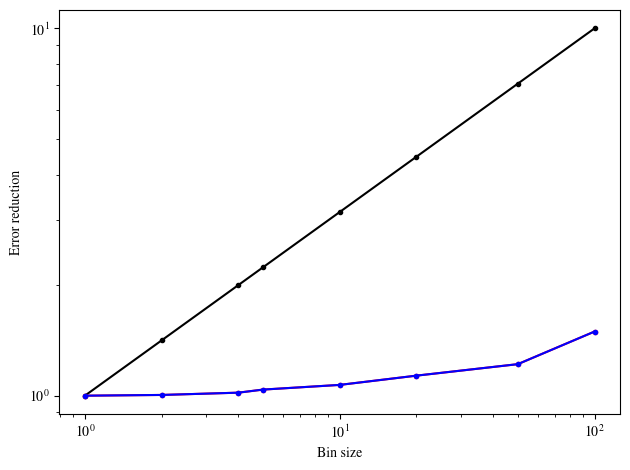

In [41]:
with open("1+1scalar/config/c_64x64_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(64, 64), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

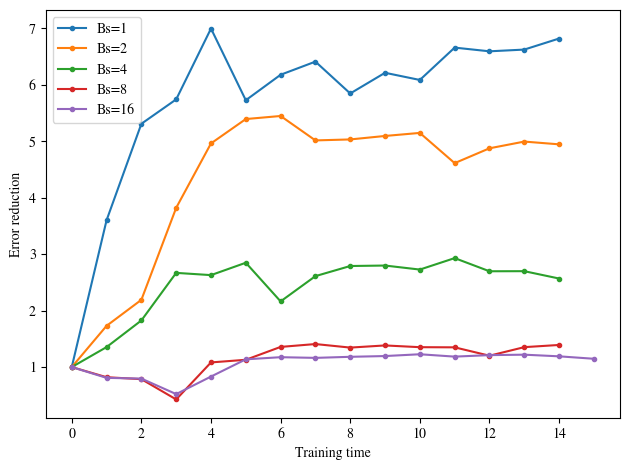

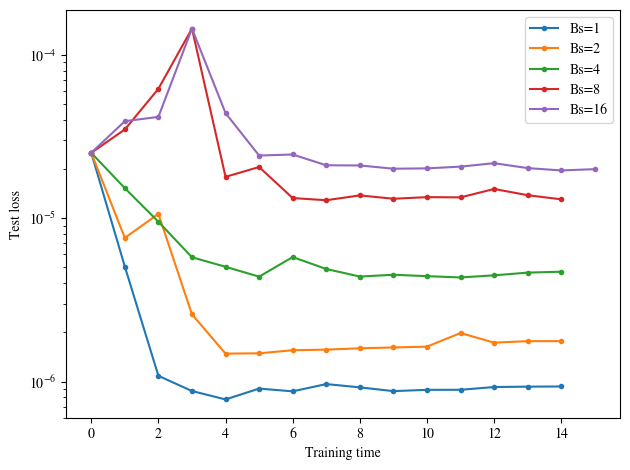

1: (6.99904137818586+0j)
2: (5.449450453086509+0j)
4: (2.930983664951111+0j)
8: (1.4079716383742442+0j)
16: (1.2271349807443825+0j)
1: 7.778968438287848e-07
2: 1.483207825003774e-06
4: 4.337125574238598e-06
8: 1.2874019375885837e-05
16: 1.958715438377112e-05


In [11]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_64x64_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(5.3732834e-05), np.complex128(5.1186491681157324e-05+0j))
bin size 1: (np.float32(5.3732834e-05), np.complex128(5.1186445507927655e-05+0j))
jack bin size 2: (np.float32(5.3732834e-05), np.complex128(7.207437793549856e-05+0j))
bin size 2: (np.float32(5.3732834e-05), np.complex128(7.207435004186308e-05+0j))
jack bin size 4: (np.float32(5.3732834e-05), np.complex128(0.00010130822011158978+0j))
bin size 4: (np.float32(5.3732834e-05), np.complex128(0.00010130831427076855+0j))
jack bin size 5: (np.float32(5.3732834e-05), np.complex128(0.0001129642560052509+0j))
bin size 5: (np.float32(5.3732834e-05), np.complex128(0.00011296424117195282+0j))
jack bin size 10: (np.float32(5.3732834e-05), np.complex128(0.00015773929593711553+0j))
bin size 10: (np.float32(5.3732834e-05), np.complex128(0.0001577392861015754+0j))
jack bin size 20: (np.float32(5.3732834e-05), np.complex128(0.00021799548217050683+0j))
bin size 20: (np.float32(5.3732834e-05), np.complex128(0.000217995554

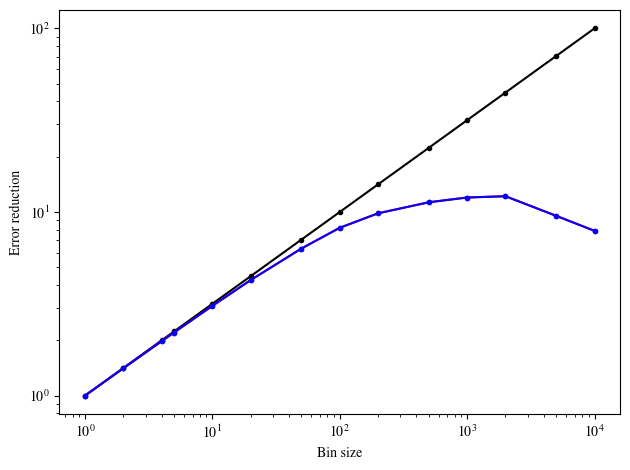

In [13]:
with open("1+1scalar/config/c_64x64_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(64,64), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.00039477917), np.complex128(0.000566171766081384+0j))
bin size 1: (np.float32(0.00039477917), np.complex128(0.0005661718622478983+0j))
jack bin size 2: (np.float32(0.00039477917), np.complex128(0.0006654559699916007+0j))
bin size 2: (np.float32(0.00039477917), np.complex128(0.0006654559536243418+0j))
jack bin size 4: (np.float32(0.00039477917), np.complex128(0.0007899416263922208+0j))
bin size 4: (np.float32(0.00039477917), np.complex128(0.0007899415964210408+0j))
jack bin size 5: (np.float32(0.00039477917), np.complex128(0.000780909134502736+0j))
bin size 5: (np.float32(0.00039477917), np.complex128(0.0007809092175431484+0j))
jack bin size 10: (np.float32(0.00039477917), np.complex128(0.0008622107425644824+0j))
bin size 10: (np.float32(0.00039477917), np.complex128(0.0008622106994200684+0j))
jack bin size 20: (np.float32(0.00039477917), np.complex128(0.0009092319523915648+0j))
bin size 20: (np.float32(0.00039477917), np.complex128(0.0009092319357608045+0

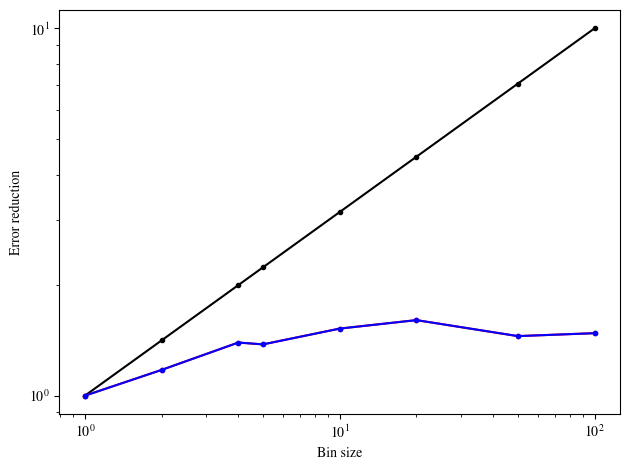

In [14]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

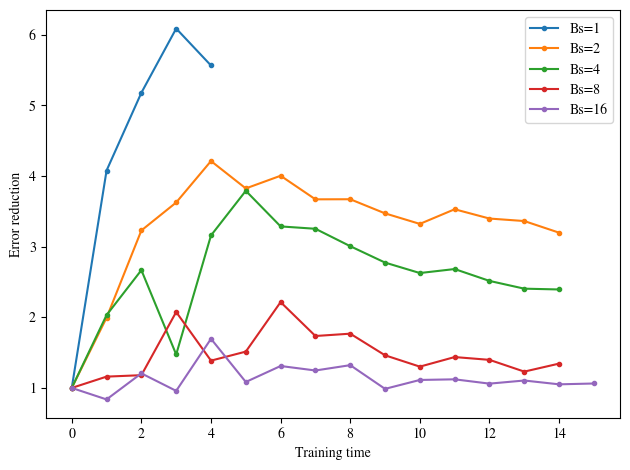

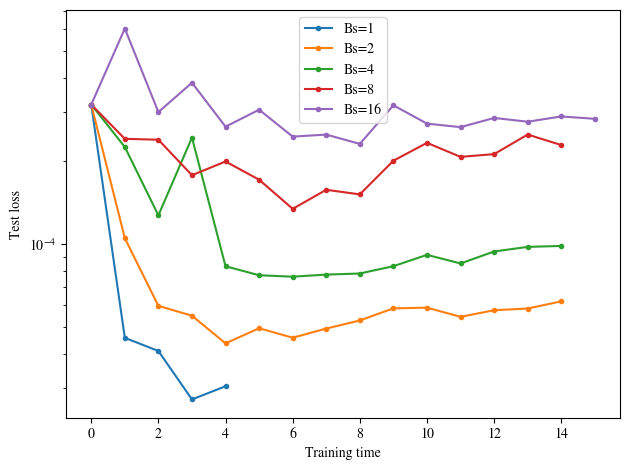

1: (6.087469004400269+0j)
2: (4.211804502144141+0j)
4: (3.790390647729067+0j)
8: (2.2150339475408214+0j)
16: (1.6954985430136245+0j)
1: 2.737485738180112e-05
2: 4.3700576497940347e-05
4: 7.621387339895591e-05
8: 0.00013426033547148108
16: 0.00023074913769960403


In [15]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

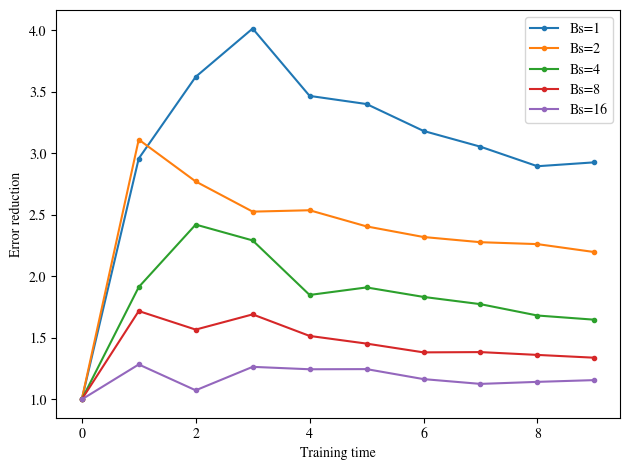

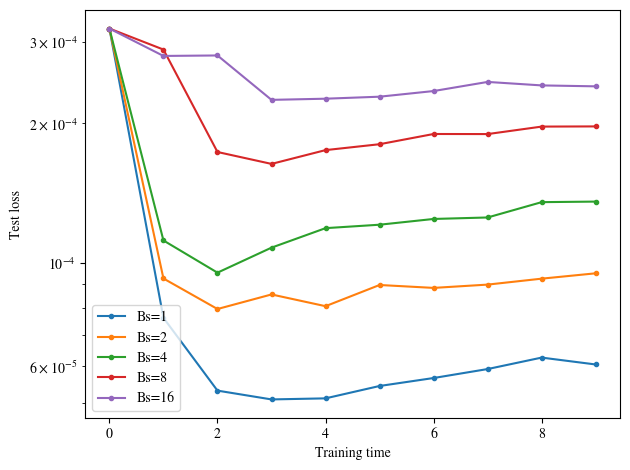

1: (4.015597790927169+0j)
2: (3.1128514689415647+0j)
4: (2.4216325506100698+0j)
8: (1.7186246765456192+0j)
16: (1.2844287938682883+0j)
1: 5.0858296162914485e-05
2: 7.965499389683828e-05
4: 9.540098835714161e-05
8: 0.0001636623201193288
16: 0.0002248897944809869


In [7]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar2d/cv_64x64_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

# Scalar 3D

In [7]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = arcsinh(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


## 8x8x8

jack bin size 1: (np.float32(0.008224265), np.complex128(5.87082928821568e-05+0j))
bin size 1: (np.float32(0.008224265), np.complex128(5.870830531971449e-05+0j))
jack bin size 2: (np.float32(0.008224265), np.complex128(8.229537646148281e-05+0j))
bin size 2: (np.float32(0.008224265), np.complex128(8.229573998158517e-05+0j))
jack bin size 4: (np.float32(0.008224265), np.complex128(0.00011496558122735509+0j))
bin size 4: (np.float32(0.008224265), np.complex128(0.0001149657020374948+0j))
jack bin size 5: (np.float32(0.008224265), np.complex128(0.0001277951242889464+0j))
bin size 5: (np.float32(0.008224265), np.complex128(0.00012779541623154963+0j))
jack bin size 10: (np.float32(0.008224265), np.complex128(0.00017640801492179657+0j))
bin size 10: (np.float32(0.008224265), np.complex128(0.0001764090276549945+0j))
jack bin size 20: (np.float32(0.008224265), np.complex128(0.00023874302554026462+0j))
bin size 20: (np.float32(0.008224265), np.complex128(0.00023874288787847656+0j))
jack bin size 

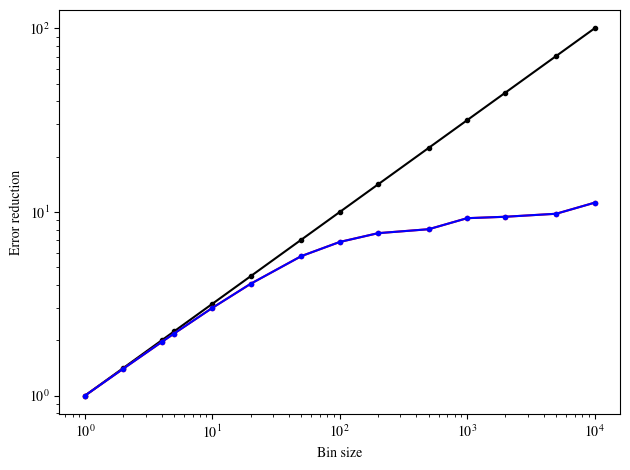

In [3]:
with open("scalar3d/config/c_8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.00787362), np.complex128(0.0005608742136814366+0j))
bin size 1: (np.float32(0.00787362), np.complex128(0.0005608742164438501+0j))
jack bin size 2: (np.float32(0.00787362), np.complex128(0.0006136921464773094+0j))
bin size 2: (np.float32(0.00787362), np.complex128(0.0006136917171828357+0j))
jack bin size 4: (np.float32(0.00787362), np.complex128(0.0006295254722973444+0j))
bin size 4: (np.float32(0.00787362), np.complex128(0.000629525305380926+0j))
jack bin size 5: (np.float32(0.00787362), np.complex128(0.000603271860095652+0j))
bin size 5: (np.float32(0.00787362), np.complex128(0.0006032719727933547+0j))
jack bin size 10: (np.float32(0.00787362), np.complex128(0.0006368841891974701+0j))
bin size 10: (np.float32(0.00787362), np.complex128(0.0006368837643346812+0j))
jack bin size 20: (np.float32(0.00787362), np.complex128(0.0006968030502321199+0j))
bin size 20: (np.float32(0.00787362), np.complex128(0.0006968026448573385+0j))
jack bin size 50: (np.float32(0.

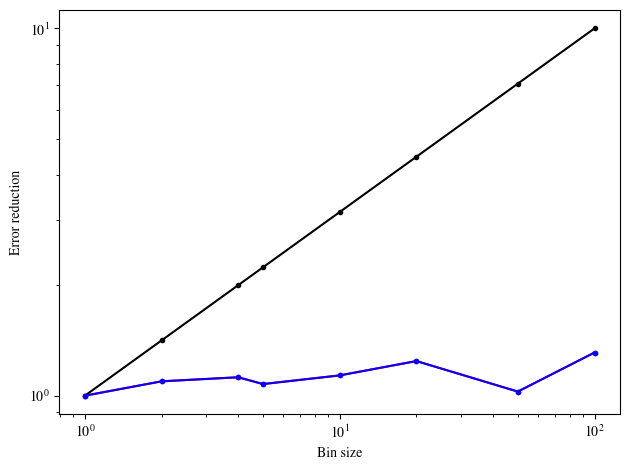

In [4]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [8]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

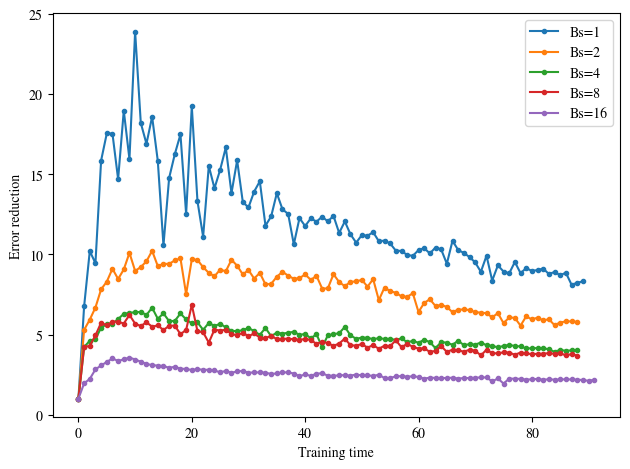

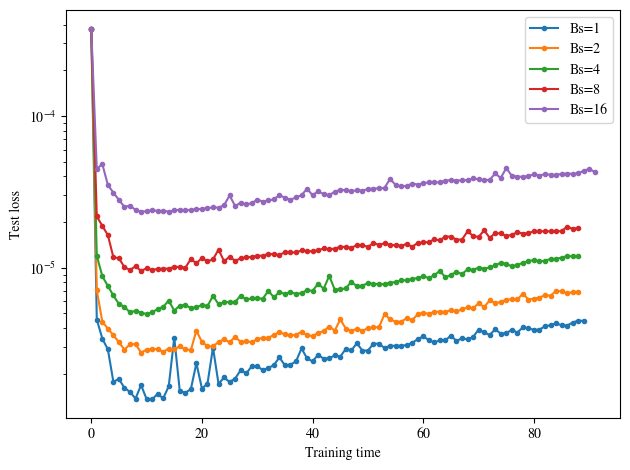

1: (23.91776896768142+0j)
2: (10.22861023281955+0j)
4: (6.675972066874668+0j)
8: (6.855511416354514+0j)
16: (3.566561735559851+0j)
1: 1.3556991689256392e-06
2: 2.758554728643503e-06
4: 4.953741154167801e-06
8: 9.525804671284277e-06
16: 2.3432643502019346e-05


In [9]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.08035123), np.complex128(0.0002902828430424847+0j))
bin size 1: (np.float32(0.08035123), np.complex128(0.00029040587412154016+0j))
jack bin size 2: (np.float32(0.08035123), np.complex128(0.00041003139299133185+0j))
bin size 2: (np.float32(0.08035123), np.complex128(0.0004101063432882425+0j))
jack bin size 4: (np.float32(0.08035123), np.complex128(0.000578733223005204+0j))
bin size 4: (np.float32(0.08035123), np.complex128(0.0005787787347861137+0j))
jack bin size 5: (np.float32(0.08035123), np.complex128(0.0006464288132309088+0j))
bin size 5: (np.float32(0.08035123), np.complex128(0.0006464508788918805+0j))
jack bin size 10: (np.float32(0.08035123), np.complex128(0.0009100485529407831+0j))
bin size 10: (np.float32(0.08035123), np.complex128(0.0009100758848232884+0j))
jack bin size 20: (np.float32(0.08035123), np.complex128(0.0012762179208766608+0j))
bin size 20: (np.float32(0.08035123), np.complex128(0.0012762400050857965+0j))
jack bin size 50: (np.float32

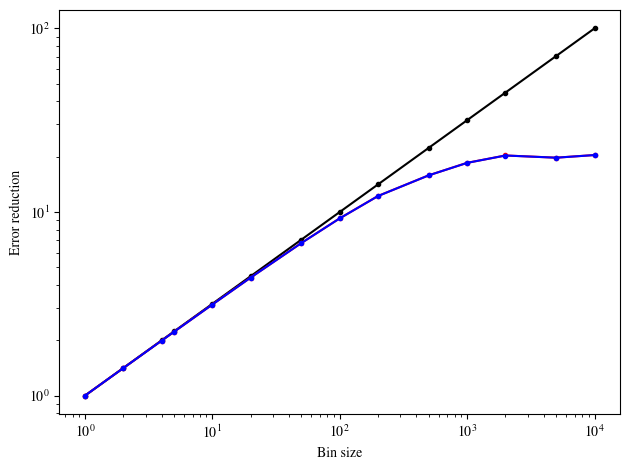

In [11]:
with open("scalar3d/config/c_8x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(8,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.07212823), np.complex128(0.0033781620582147647+0j))
bin size 1: (np.float32(0.07212823), np.complex128(0.003378155418984507+0j))
jack bin size 2: (np.float32(0.07212823), np.complex128(0.004353673467701359+0j))
bin size 2: (np.float32(0.07212823), np.complex128(0.004353664314413574+0j))
jack bin size 4: (np.float32(0.07212823), np.complex128(0.005453431200759043+0j))
bin size 4: (np.float32(0.07212823), np.complex128(0.00545342924571591+0j))
jack bin size 5: (np.float32(0.07212823), np.complex128(0.00599196055968943+0j))
bin size 5: (np.float32(0.07212823), np.complex128(0.005991964442473441+0j))
jack bin size 10: (np.float32(0.07212823), np.complex128(0.007161647461055323+0j))
bin size 10: (np.float32(0.07212823), np.complex128(0.007161647648258205+0j))
jack bin size 20: (np.float32(0.07212823), np.complex128(0.007197161437943578+0j))
bin size 20: (np.float32(0.07212823), np.complex128(0.007197157612868718+0j))
jack bin size 50: (np.float32(0.07212823), 

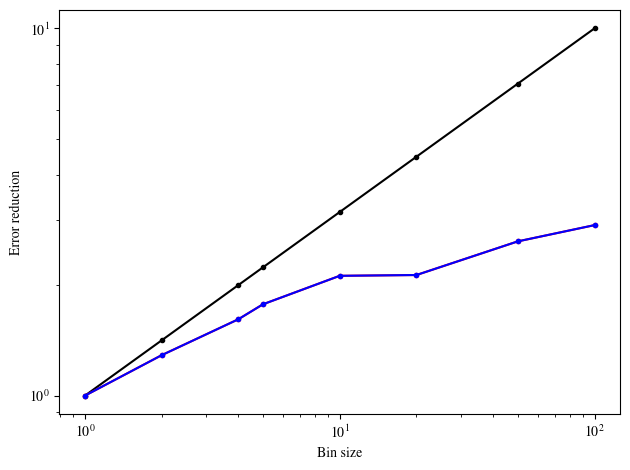

In [12]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

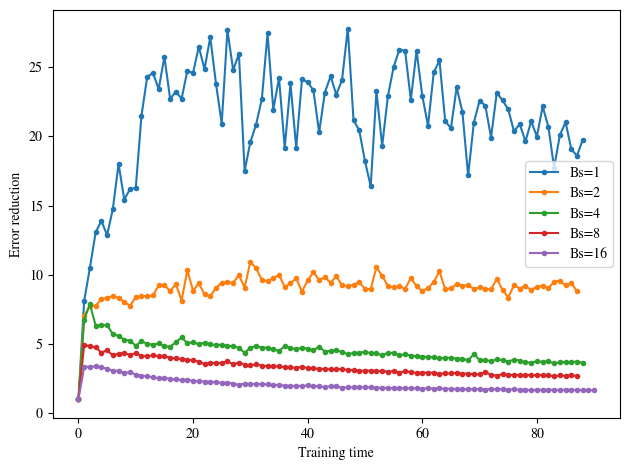

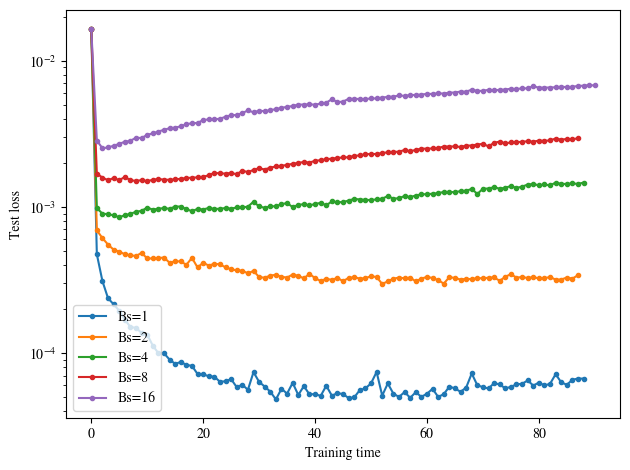

1: (27.776379494042704+0j)
2: (10.952302919305783+0j)
4: (7.8867759146985+0j)
8: (4.942200242154169+0j)
16: (3.389650643988552+0j)
1: 4.804890704690479e-05
2: 0.000296636251732707
4: 0.0008490732288919389
8: 0.0014982377178967
16: 0.0025177982170134783


In [5]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

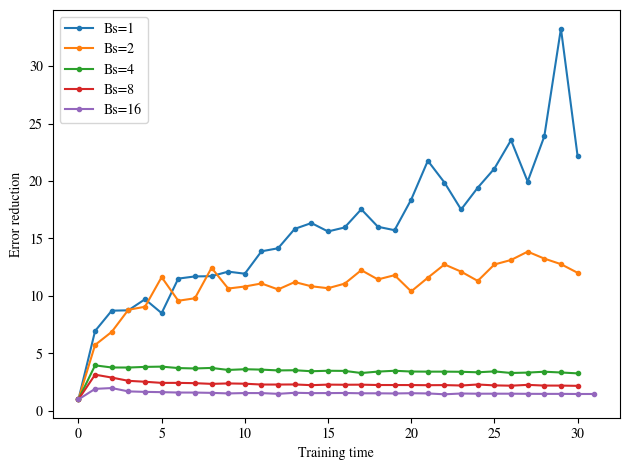

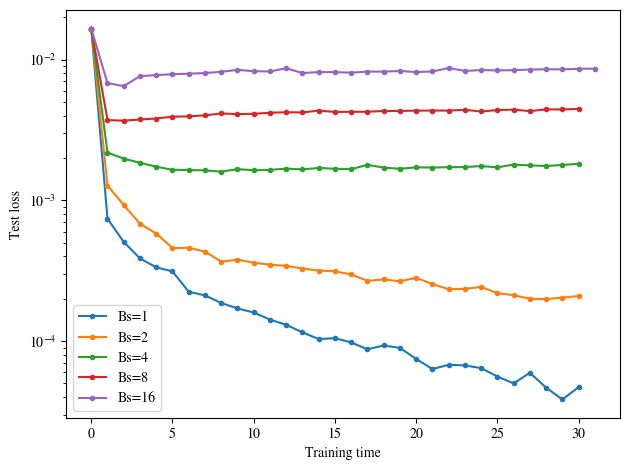

1: (33.26409332956647+0j)
2: (13.856555972661111+0j)
4: (3.963460381071932+0j)
8: (3.1542005290962893+0j)
16: (1.9893096306688662+0j)
1: 3.8530615711351857e-05
2: 0.0001988288713619113
4: 0.0015979479067027569
8: 0.003679769579321146
16: 0.006474036257714033


In [8]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 32x8x8

### sweep1

jack bin size 1: (np.float32(9.8053606e-05), np.complex128(2.5210826425425215e-05+0j))
bin size 1: (np.float32(9.8053606e-05), np.complex128(2.5210775971631163e-05+0j))
jack bin size 2: (np.float32(9.8053606e-05), np.complex128(3.52676730395698e-05+0j))
bin size 2: (np.float32(9.8053606e-05), np.complex128(3.5267799980714864e-05+0j))
jack bin size 4: (np.float32(9.8053606e-05), np.complex128(4.9118415704511246e-05+0j))
bin size 4: (np.float32(9.8053606e-05), np.complex128(4.9118462629868035e-05+0j))
jack bin size 5: (np.float32(9.8053606e-05), np.complex128(5.455436191298815e-05+0j))
bin size 5: (np.float32(9.8053606e-05), np.complex128(5.4554446764212234e-05+0j))
jack bin size 10: (np.float32(9.8053606e-05), np.complex128(7.48459490221737e-05+0j))
bin size 10: (np.float32(9.8053606e-05), np.complex128(7.484604918130677e-05+0j))
jack bin size 20: (np.float32(9.8053606e-05), np.complex128(0.00010060290191130662+0j))
bin size 20: (np.float32(9.8053606e-05), np.complex128(0.00010060289902

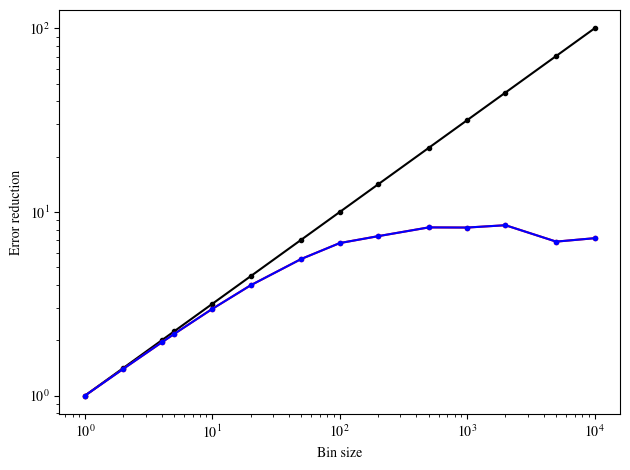

In [4]:
with open("scalar3d/config/c_32x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(32,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(4.499459e-05), np.complex128(0.00023541057047981855+0j))
bin size 1: (np.float32(4.499459e-05), np.complex128(0.0002354105811122324+0j))
jack bin size 2: (np.float32(4.499459e-05), np.complex128(0.00024353955148597508+0j))
bin size 2: (np.float32(4.499459e-05), np.complex128(0.00024353953927160274+0j))
jack bin size 4: (np.float32(4.499459e-05), np.complex128(0.00024125992021823344+0j))
bin size 4: (np.float32(4.499459e-05), np.complex128(0.00024125993624128742+0j))
jack bin size 5: (np.float32(4.499459e-05), np.complex128(0.00023097043649455168+0j))
bin size 5: (np.float32(4.499459e-05), np.complex128(0.00023097042321324341+0j))
jack bin size 10: (np.float32(4.499459e-05), np.complex128(0.00023301168447128467+0j))
bin size 10: (np.float32(4.499459e-05), np.complex128(0.00023301168355720813+0j))
jack bin size 20: (np.float32(4.499459e-05), np.complex128(0.0002141562508768402+0j))
bin size 20: (np.float32(4.499459e-05), np.complex128(0.0002141562456797276+0j

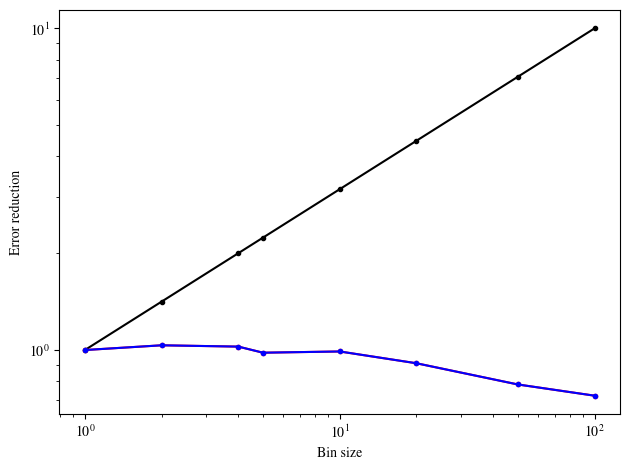

In [7]:
with open("scalar3d/config/c_32x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(32, 8, 8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [32]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_32x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

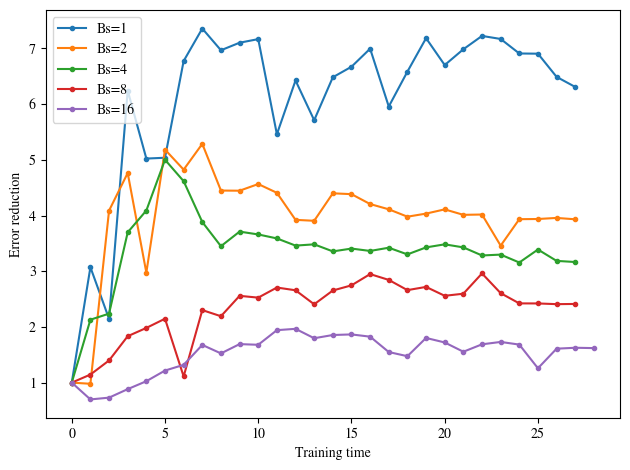

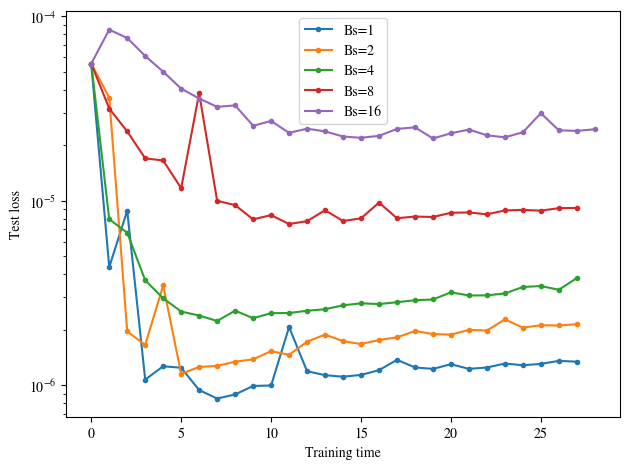

1: (7.3579775256494875+0j)
2: (5.287334700173036+0j)
4: (5.001713946028805+0j)
8: (2.9608176420002907+0j)
16: (1.9661682789678738+0j)
1: 8.482983275825973e-07
2: 1.1542191487023956e-06
4: 2.2318597530102124e-06
8: 7.4835988925769925e-06
16: 2.1758334696642123e-05


In [33]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.0065089245), np.complex128(9.908135920095921e-05+0j))
bin size 1: (np.float32(0.0065089245), np.complex128(9.908318544782935e-05+0j))
jack bin size 2: (np.float32(0.0065089245), np.complex128(0.00013985395912572598+0j))
bin size 2: (np.float32(0.0065089245), np.complex128(0.00013985509071961098+0j))
jack bin size 4: (np.float32(0.0065089245), np.complex128(0.0001972372453993503+0j))
bin size 4: (np.float32(0.0065089245), np.complex128(0.0001972376246166751+0j))
jack bin size 5: (np.float32(0.0065089245), np.complex128(0.0002202380483499643+0j))
bin size 5: (np.float32(0.0065089245), np.complex128(0.00022023852871520623+0j))
jack bin size 10: (np.float32(0.0065089245), np.complex128(0.0003096372222325001+0j))
bin size 10: (np.float32(0.0065089245), np.complex128(0.00030963585140537486+0j))
jack bin size 20: (np.float32(0.0065089245), np.complex128(0.0004331073229980462+0j))
bin size 20: (np.float32(0.0065089245), np.complex128(0.00043310676476143836+0j))
j

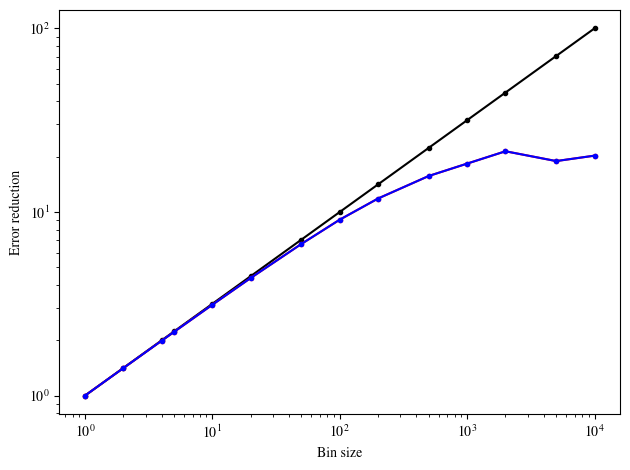

In [20]:
with open("scalar3d/config/c_32x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(32,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.0059612477), np.complex128(0.0009755275181948254+0j))
bin size 1: (np.float32(0.0059612477), np.complex128(0.0009755274566160281+0j))
jack bin size 2: (np.float32(0.0059612477), np.complex128(0.0011998345327960454+0j))
bin size 2: (np.float32(0.0059612477), np.complex128(0.0011998344601612445+0j))
jack bin size 4: (np.float32(0.0059612477), np.complex128(0.0014494470990856492+0j))
bin size 4: (np.float32(0.0059612477), np.complex128(0.0014494470824862266+0j))
jack bin size 5: (np.float32(0.0059612477), np.complex128(0.0015252488640314509+0j))
bin size 5: (np.float32(0.0059612477), np.complex128(0.0015252487990433017+0j))
jack bin size 10: (np.float32(0.0059612477), np.complex128(0.0015929027488824953+0j))
bin size 10: (np.float32(0.0059612477), np.complex128(0.0015929031379134826+0j))
jack bin size 20: (np.float32(0.0059612477), np.complex128(0.0017167757032439113+0j))
bin size 20: (np.float32(0.0059612477), np.complex128(0.001716775686613151+0j))
jack bi

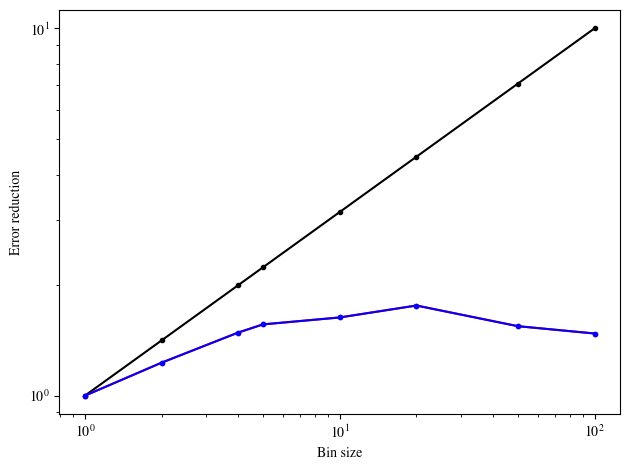

In [21]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

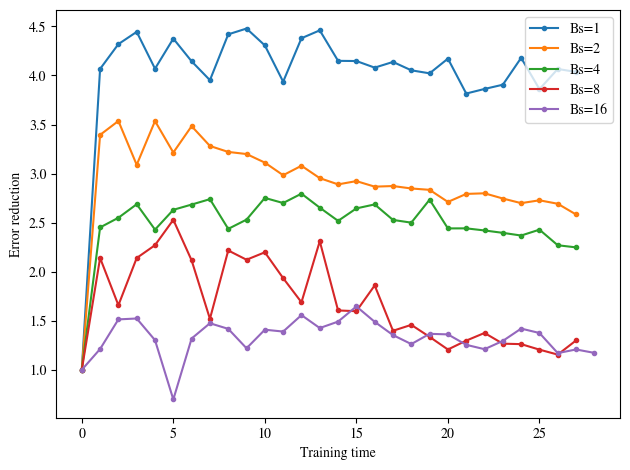

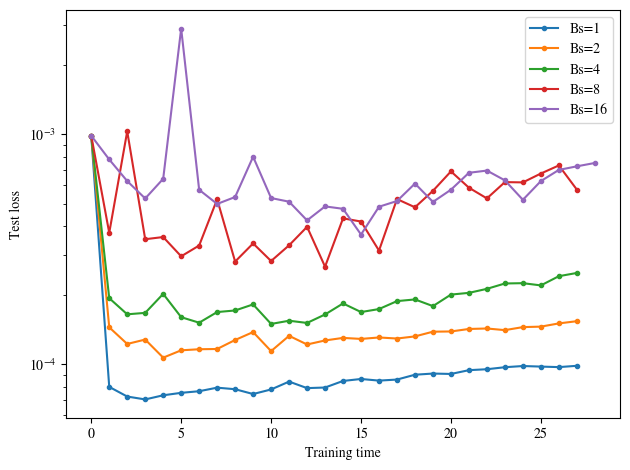

1: (4.477909008490175+0j)
2: (3.536027170765789+0j)
4: (2.7951390007295474+0j)
8: (2.528915226580454+0j)
16: (1.6460951201012637+0j)
1: 7.03048353898339e-05
2: 0.0001068311685230583
4: 0.00014973215002100915
8: 0.00026569905458018184
16: 0.0003665108233690262


In [26]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_32x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

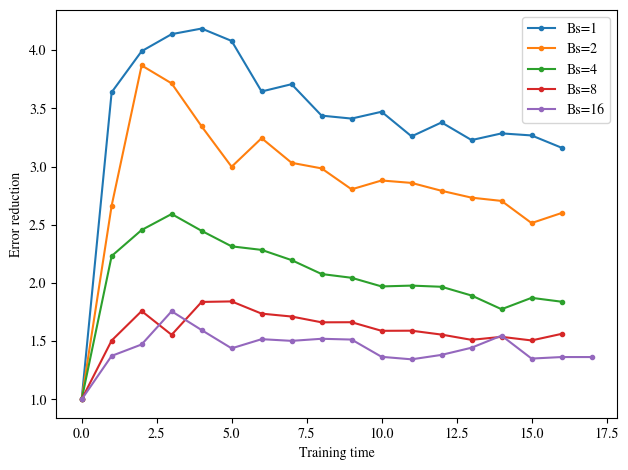

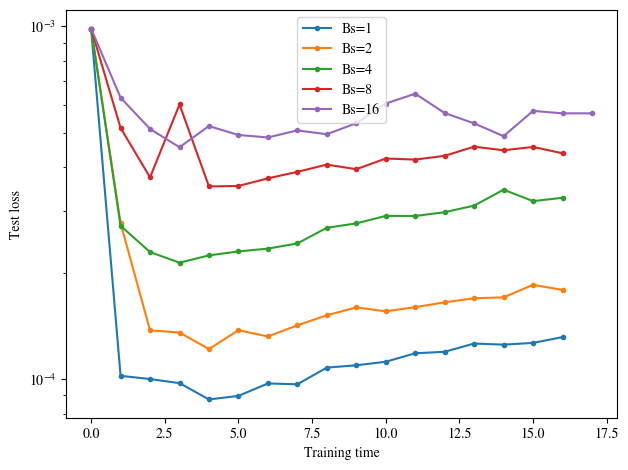

1: (4.186623077098476+0j)
2: (3.86954830995727+0j)
4: (2.5931264409434047+0j)
8: (1.8421392786906383+0j)
16: (1.7573872546349414+0j)
1: 8.772227738518268e-05
2: 0.00012185702507849783
4: 0.0002140891010640189
8: 0.00035206504981033504
16: 0.0004546348354779184


In [9]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_32x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 16x16x16

### sweep 1

jack bin size 1: (np.float32(0.00037599617), np.complex128(8.9079724354893e-06+0j))
bin size 1: (np.float32(0.00037599617), np.complex128(8.907984216894209e-06+0j))
jack bin size 2: (np.float32(0.00037599617), np.complex128(1.2461344431060909e-05+0j))
bin size 2: (np.float32(0.00037599617), np.complex128(1.2461309360375226e-05+0j))
jack bin size 4: (np.float32(0.00037599617), np.complex128(1.7357621324217516e-05+0j))
bin size 4: (np.float32(0.00037599617), np.complex128(1.7357527093629767e-05+0j))
jack bin size 5: (np.float32(0.00037599617), np.complex128(1.9278597401709255e-05+0j))
bin size 5: (np.float32(0.00037599617), np.complex128(1.927853938190075e-05+0j))
jack bin size 10: (np.float32(0.00037599617), np.complex128(2.644777251523176e-05+0j))
bin size 10: (np.float32(0.00037599617), np.complex128(2.644775662442789e-05+0j))
jack bin size 20: (np.float32(0.00037599617), np.complex128(3.547622855559271e-05+0j))
bin size 20: (np.float32(0.00037599617), np.complex128(3.5476307855754687

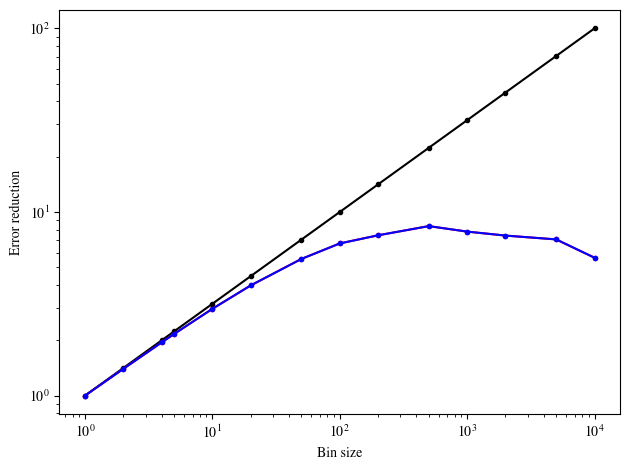

In [3]:
with open("scalar3d/config/c_16x16x16_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16,16,16), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.0006654521), np.complex128(9.683061728900364e-05+0j))
bin size 1: (np.float32(0.0006654521), np.complex128(9.683065376149224e-05+0j))
jack bin size 2: (np.float32(0.0006654521), np.complex128(9.99719522184077e-05+0j))
bin size 2: (np.float32(0.0006654521), np.complex128(9.997188738044779e-05+0j))
jack bin size 4: (np.float32(0.0006654521), np.complex128(0.0001029006801874981+0j))
bin size 4: (np.float32(0.0006654521), np.complex128(0.00010290066315579865+0j))
jack bin size 5: (np.float32(0.0006654521), np.complex128(0.00010067168553202524+0j))
bin size 5: (np.float32(0.0006654521), np.complex128(0.0001006716767637829+0j))
jack bin size 10: (np.float32(0.0006654521), np.complex128(0.0001083664876547238+0j))
bin size 10: (np.float32(0.0006654521), np.complex128(0.00010836647110993792+0j))
jack bin size 20: (np.float32(0.0006654521), np.complex128(0.00012386564776534215+0j))
bin size 20: (np.float32(0.0006654521), np.complex128(0.00012386563633169447+0j))
ja

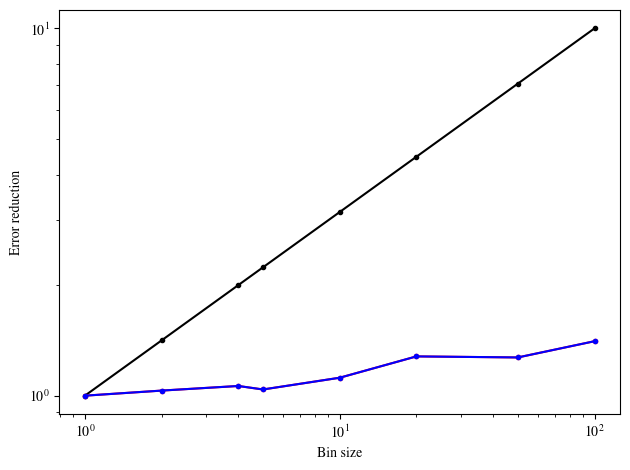

In [4]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [7]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_16x16x16_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

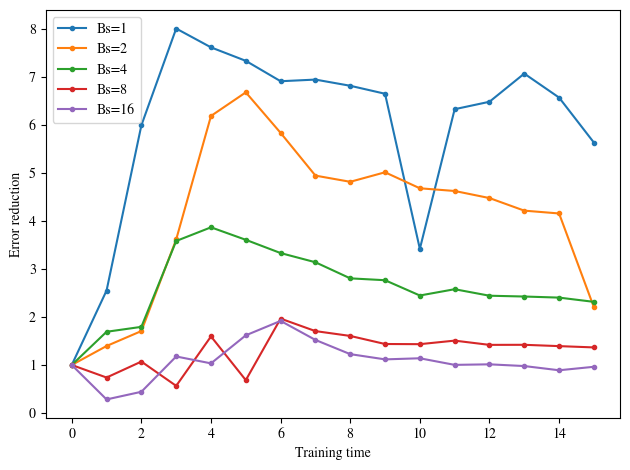

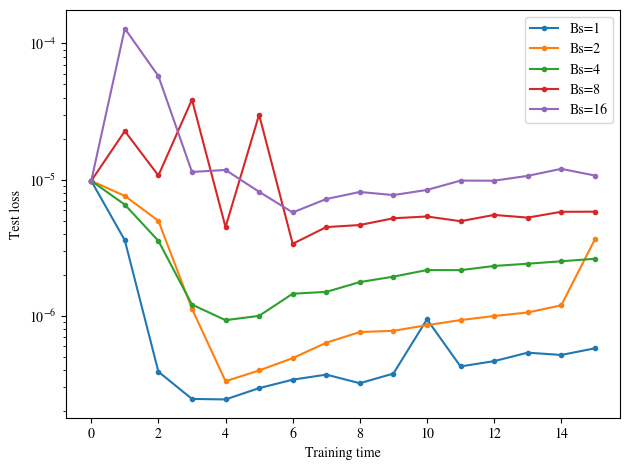

1: (8.015561586854744+0j)
2: (6.68513023778413+0j)
4: (3.87070722337019+0j)
8: (1.9669941849721797+0j)
16: (1.919292377808576+0j)
1: 2.4408322474300803e-07
2: 3.319978816307412e-07
4: 9.312977340414363e-07
8: 3.3840947253338527e-06
16: 5.748750481870957e-06


In [8]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.007444006), np.complex128(4.56191847306375e-05+0j))
bin size 1: (np.float32(0.007444006), np.complex128(4.562227157219402e-05+0j))
jack bin size 2: (np.float32(0.007444006), np.complex128(6.443480144175057e-05+0j))
bin size 2: (np.float32(0.007444006), np.complex128(6.443512421528273e-05+0j))
jack bin size 4: (np.float32(0.007444006), np.complex128(9.094845544308187e-05+0j))
bin size 4: (np.float32(0.007444006), np.complex128(9.094879238845219e-05+0j))
jack bin size 5: (np.float32(0.007444006), np.complex128(0.00010159540277014188+0j))
bin size 5: (np.float32(0.007444006), np.complex128(0.0001015970112132691+0j))
jack bin size 10: (np.float32(0.007444006), np.complex128(0.00014307853105909518+0j))
bin size 10: (np.float32(0.007444006), np.complex128(0.00014308070929640738+0j))
jack bin size 20: (np.float32(0.007444006), np.complex128(0.00020071721780850045+0j))
bin size 20: (np.float32(0.007444006), np.complex128(0.00020071693791195576+0j))
jack bin size 

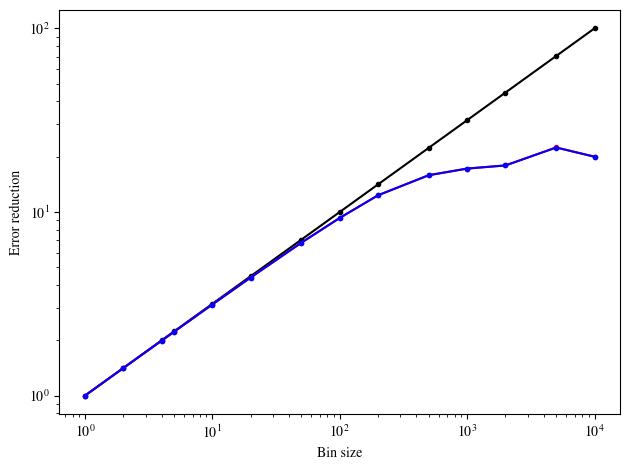

In [22]:
with open("scalar3d/config/c_16x16x16_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("scalar.Model(geom=(16,16,16), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.010234929), np.complex128(0.0005059181227086099+0j))
bin size 1: (np.float32(0.010234929), np.complex128(0.0005059177194538128+0j))
jack bin size 2: (np.float32(0.010234929), np.complex128(0.0006546490161164262+0j))
bin size 2: (np.float32(0.010234929), np.complex128(0.0006546490417666082+0j))
jack bin size 4: (np.float32(0.010234929), np.complex128(0.0008064722978703018+0j))
bin size 4: (np.float32(0.010234929), np.complex128(0.0008064721427118079+0j))
jack bin size 5: (np.float32(0.010234929), np.complex128(0.0008876051729614531+0j))
bin size 5: (np.float32(0.010234929), np.complex128(0.0008876047221706418+0j))
jack bin size 10: (np.float32(0.010234929), np.complex128(0.001062378632728072+0j))
bin size 10: (np.float32(0.010234929), np.complex128(0.0010623792521063547+0j))
jack bin size 20: (np.float32(0.010234929), np.complex128(0.0011691479448927566+0j))
bin size 20: (np.float32(0.010234929), np.complex128(0.001169147901237011+0j))
jack bin size 50: (n

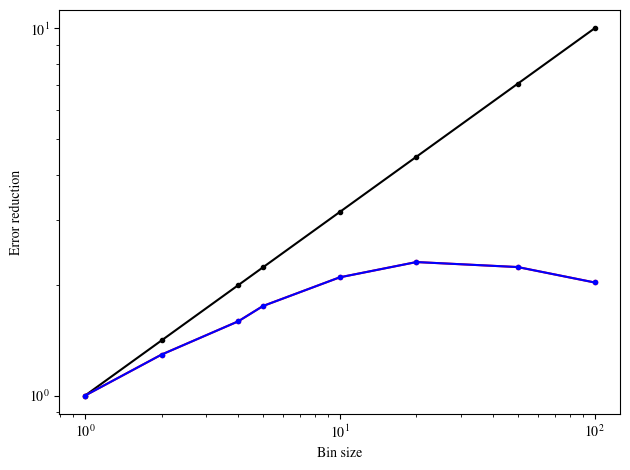

In [23]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

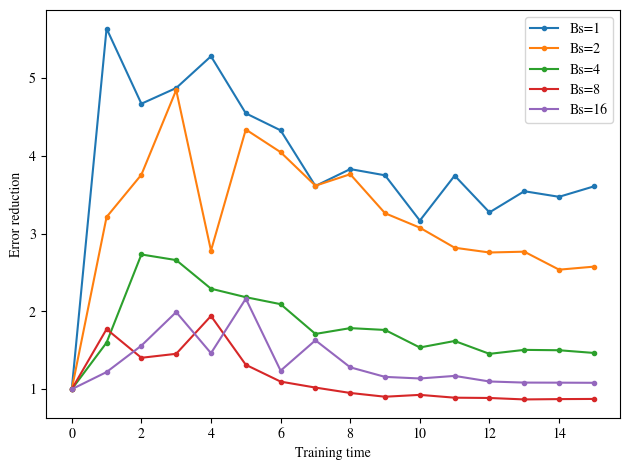

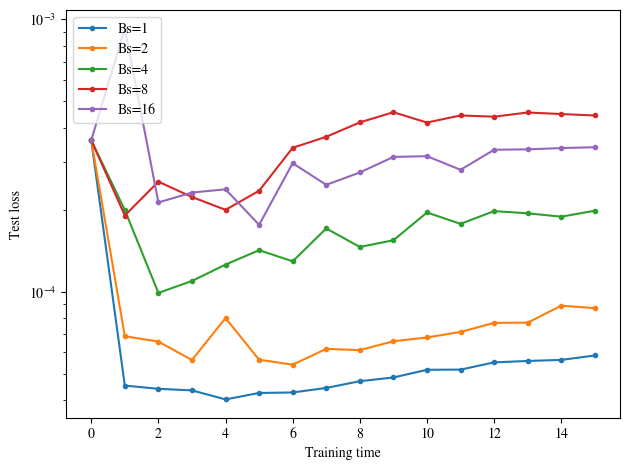

1: (5.634659606668513+0j)
2: (4.844236813774753+0j)
4: (2.7313027146403104+0j)
8: (1.941139776457823+0j)
16: (2.163140073842459+0j)
1: 4.0301092667505145e-05
2: 5.4069521866040304e-05
4: 9.914916154230013e-05
8: 0.0001907278929138556
16: 0.000176313886186108


In [17]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_16x16x16_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

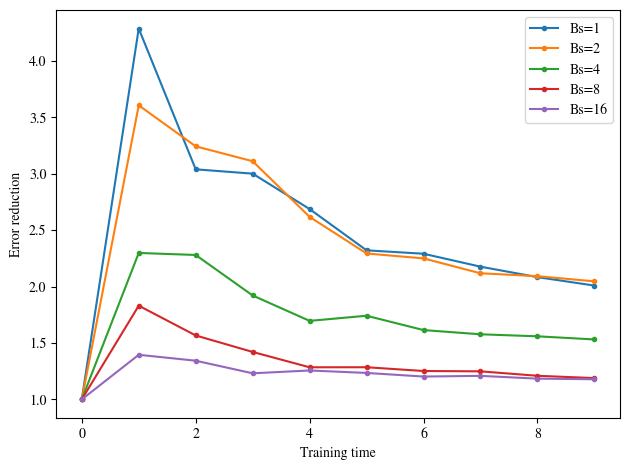

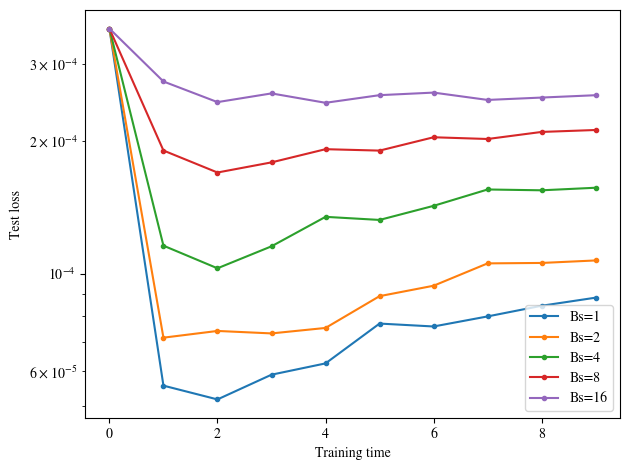

1: (4.286645603883481+0j)
2: (3.606076604201665+0j)
4: (2.2980698839470404+0j)
8: (1.8308072294973134+0j)
16: (1.3955795786785927+0j)
1: 5.1761144277406856e-05
2: 7.150630699470639e-05
4: 0.00010280424612574279
8: 0.00016969762509688735
16: 0.00024440247216261923


In [10]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar3d/cv_16x16x16_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

# Scalar 4D

In [ ]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = arcsinh(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


## 8x8x8x8

jack bin size 1: (np.float32(0.0012261152), np.complex128(8.457331968948996e-06+0j))
bin size 1: (np.float32(0.0012261152), np.complex128(8.457215177327146e-06+0j))
jack bin size 2: (np.float32(0.0012261152), np.complex128(1.1888808667014784e-05+0j))
bin size 2: (np.float32(0.0012261152), np.complex128(1.188875654250737e-05+0j))
jack bin size 4: (np.float32(0.0012261152), np.complex128(1.667467957048708e-05+0j))
bin size 4: (np.float32(0.0012261152), np.complex128(1.6674478345081373e-05+0j))
jack bin size 5: (np.float32(0.0012261152), np.complex128(1.857021954023701e-05+0j))
bin size 5: (np.float32(0.0012261152), np.complex128(1.8570103940859812e-05+0j))
jack bin size 10: (np.float32(0.0012261152), np.complex128(2.581032534265365e-05+0j))
bin size 10: (np.float32(0.0012261152), np.complex128(2.5810409076912232e-05+0j))
jack bin size 20: (np.float32(0.0012261152), np.complex128(3.539596441299066e-05+0j))
bin size 20: (np.float32(0.0012261152), np.complex128(3.5395973855591765e-05+0j))
j

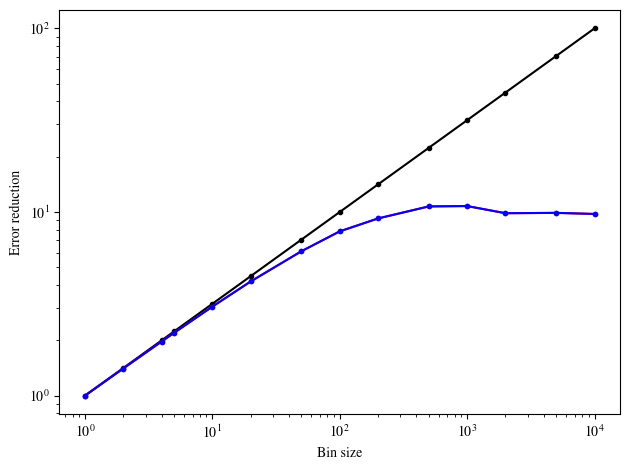

In [39]:
with open("scalar4d/config/c_8x8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(8, 8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.0011878875), np.complex128(8.153878065243417e-05+0j))
bin size 1: (np.float32(0.0011878875), np.complex128(8.153878065962796e-05+0j))
jack bin size 2: (np.float32(0.0011878875), np.complex128(8.705082531477541e-05+0j))
bin size 2: (np.float32(0.0011878875), np.complex128(8.70508090289456e-05+0j))
jack bin size 4: (np.float32(0.0011878875), np.complex128(9.77821015298711e-05+0j))
bin size 4: (np.float32(0.0011878875), np.complex128(9.778207988722087e-05+0j))
jack bin size 5: (np.float32(0.0011878875), np.complex128(8.968921054933585e-05+0j))
bin size 5: (np.float32(0.0011878875), np.complex128(8.968920774478774e-05+0j))
jack bin size 10: (np.float32(0.0011878875), np.complex128(8.658501771770585e-05+0j))
bin size 10: (np.float32(0.0011878875), np.complex128(8.658500638315641e-05+0j))
jack bin size 20: (np.float32(0.0011878875), np.complex128(8.633228662802139e-05+0j))
bin size 20: (np.float32(0.0011878875), np.complex128(8.633228883679423e-05+0j))
jack bin

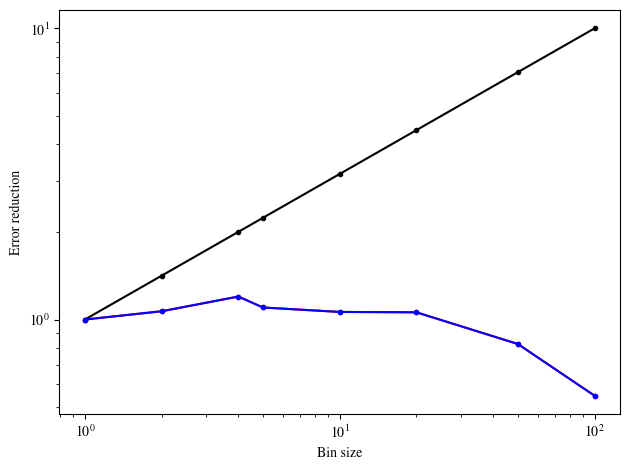

In [40]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

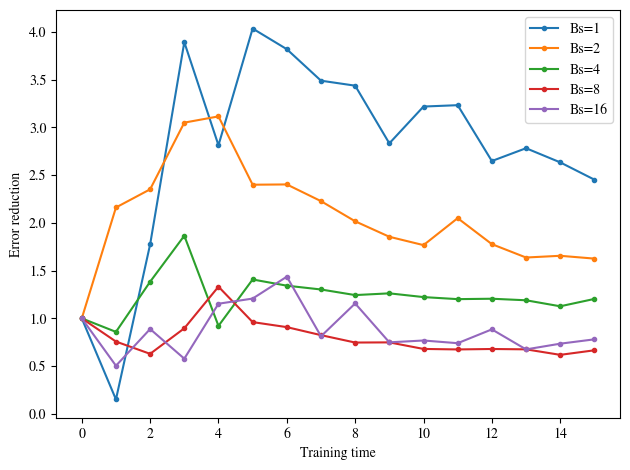

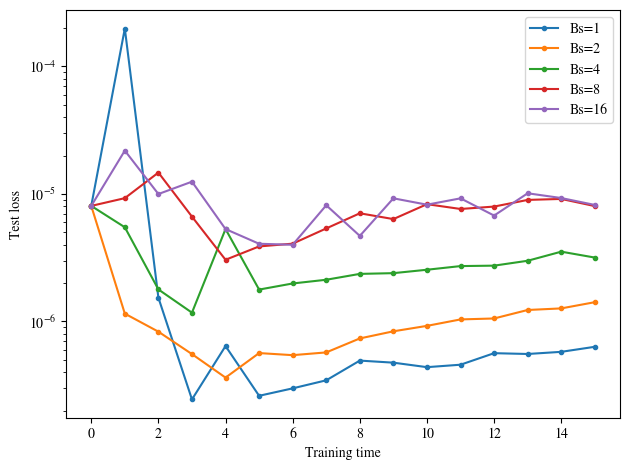

1: (4.03615145967893+0j)
2: (3.1157712765933003+0j)
4: (1.86569910707378+0j)
8: (1.3319811549865876+0j)
16: (1.436747496191584+0j)
1: 2.450232443607092e-07
2: 3.63263637837008e-07
4: 1.172783640868147e-06
8: 3.046428901143372e-06
16: 3.9937290239322465e-06


In [4]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar4d/cv_8x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.012423942), np.complex128(5.5251097518818795e-05+0j))
bin size 1: (np.float32(0.012423942), np.complex128(5.5258515064565094e-05+0j))
jack bin size 2: (np.float32(0.012423942), np.complex128(7.808883471022103e-05+0j))
bin size 2: (np.float32(0.012423942), np.complex128(7.809003801127697e-05+0j))
jack bin size 4: (np.float32(0.012423942), np.complex128(0.00011031731720142858+0j))
bin size 4: (np.float32(0.012423942), np.complex128(0.00011031821682325576+0j))
jack bin size 5: (np.float32(0.012423942), np.complex128(0.00012327164274143824+0j))
bin size 5: (np.float32(0.012423942), np.complex128(0.00012327759576363353+0j))
jack bin size 10: (np.float32(0.012423942), np.complex128(0.00017394570387890048+0j))
bin size 10: (np.float32(0.012423942), np.complex128(0.0001739468229305239+0j))
jack bin size 20: (np.float32(0.012423942), np.complex128(0.00024496478067352015+0j))
bin size 20: (np.float32(0.012423942), np.complex128(0.000244965412331678+0j))
jack bin si

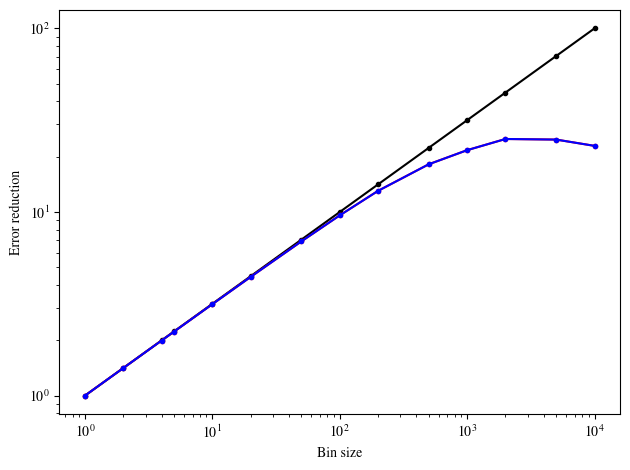

In [16]:
with open("scalar4d/config/c_8x8x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(8, 8,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.01193731), np.complex128(0.0005224914938033256+0j))
bin size 1: (np.float32(0.01193731), np.complex128(0.0005224909619236574+0j))
jack bin size 2: (np.float32(0.01193731), np.complex128(0.0006915622376609066+0j))
bin size 2: (np.float32(0.01193731), np.complex128(0.0006915624775511796+0j))
jack bin size 4: (np.float32(0.01193731), np.complex128(0.0008915956777350428+0j))
bin size 4: (np.float32(0.01193731), np.complex128(0.0008915958716255234+0j))
jack bin size 5: (np.float32(0.01193731), np.complex128(0.0009675123732908772+0j))
bin size 5: (np.float32(0.01193731), np.complex128(0.0009675130608242309+0j))
jack bin size 10: (np.float32(0.01193731), np.complex128(0.001203410198918879+0j))
bin size 10: (np.float32(0.01193731), np.complex128(0.001203409759430865+0j))
jack bin size 20: (np.float32(0.01193731), np.complex128(0.0013077084586257115+0j))
bin size 20: (np.float32(0.01193731), np.complex128(0.0013077078121049063+0j))
jack bin size 50: (np.float32(0.

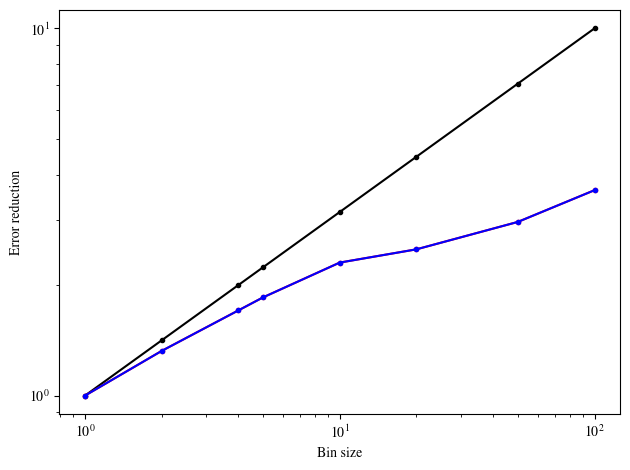

In [17]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

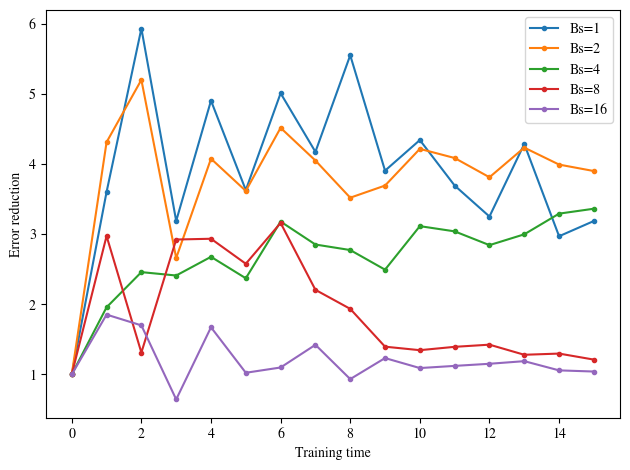

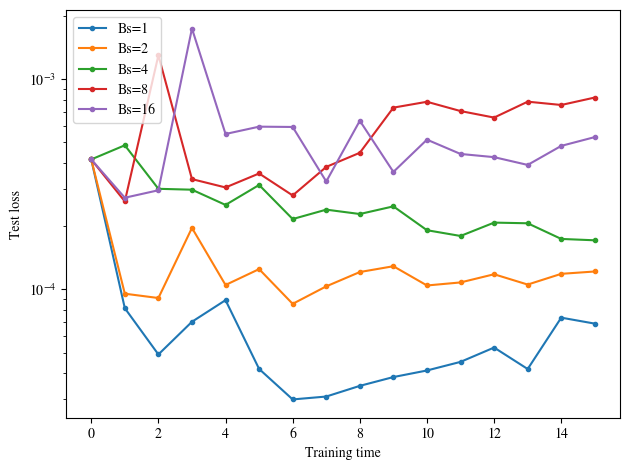

1: (5.932570039917567+0j)
2: (5.201189479524629+0j)
4: (3.3633780107154827+0j)
8: (3.160684752063224+0j)
16: (1.853336801668798+0j)
1: 2.999671414727345e-05
2: 8.542016439605504e-05
4: 0.0001712832454359159
8: 0.00026227813214063644
16: 0.00027298033819533885


In [8]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

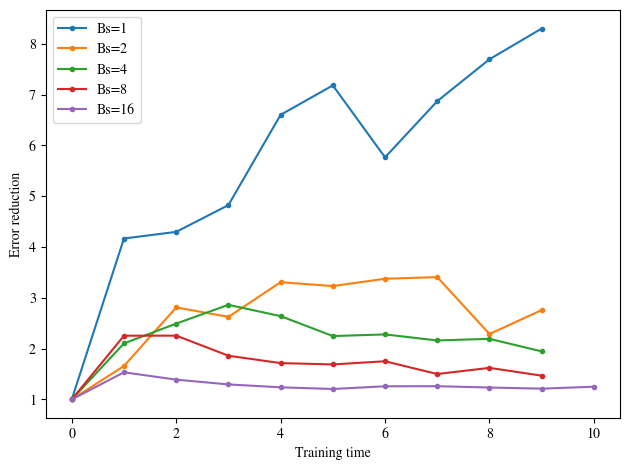

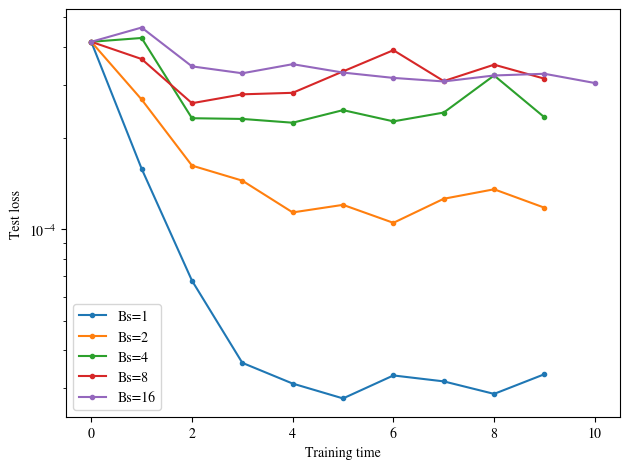

1: (8.301251294380343+0j)
2: (3.4079872872729+0j)
4: (2.862387026687758+0j)
8: (2.2560114168262166+0j)
16: (1.5339943838030354+0j)
1: 2.7728827262762934e-05
2: 0.00010510512220207602
4: 0.00022469258692581207
8: 0.0002605509362183511
16: 0.00030368674197234213


In [12]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 16x8x8x8

jack bin size 1: (np.float32(0.00025539254), np.complex128(4.718593323692371e-06+0j))
bin size 1: (np.float32(0.00025539254), np.complex128(4.718579794237548e-06+0j))
jack bin size 2: (np.float32(0.00025539254), np.complex128(6.615375763015728e-06+0j))
bin size 2: (np.float32(0.00025539254), np.complex128(6.61536614929218e-06+0j))
jack bin size 4: (np.float32(0.00025539254), np.complex128(9.241301779884126e-06+0j))
bin size 4: (np.float32(0.00025539254), np.complex128(9.24131772201583e-06+0j))
jack bin size 5: (np.float32(0.00025539254), np.complex128(1.0277893851934e-05+0j))
bin size 5: (np.float32(0.00025539254), np.complex128(1.0277895199333107e-05+0j))
jack bin size 10: (np.float32(0.00025539254), np.complex128(1.4172217279952888e-05+0j))
bin size 10: (np.float32(0.00025539254), np.complex128(1.4172204195933168e-05+0j))
jack bin size 20: (np.float32(0.00025539254), np.complex128(1.919282600317804e-05+0j))
bin size 20: (np.float32(0.00025539254), np.complex128(1.9192833243309523e-05

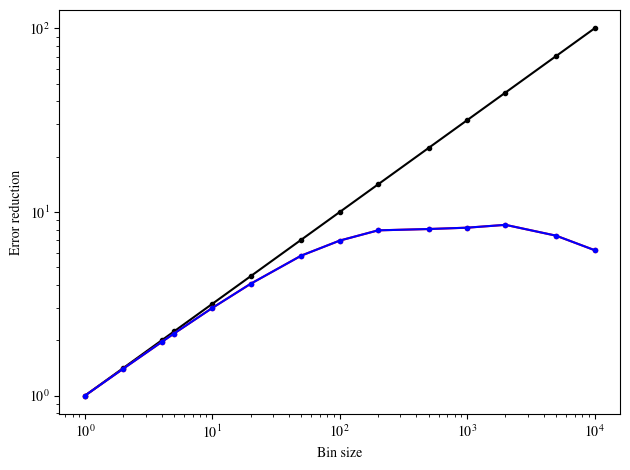

In [18]:
with open("scalar4d/config/c_16x8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16, 8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.00034363178), np.complex128(5.279044412941723e-05+0j))
bin size 1: (np.float32(0.00034363178), np.complex128(5.279044449270336e-05+0j))
jack bin size 2: (np.float32(0.00034363178), np.complex128(5.6240387297985536e-05+0j))
bin size 2: (np.float32(0.00034363178), np.complex128(5.6240379826861115e-05+0j))
jack bin size 4: (np.float32(0.00034363178), np.complex128(6.018614588210783e-05+0j))
bin size 4: (np.float32(0.00034363178), np.complex128(6.01861393403214e-05+0j))
jack bin size 5: (np.float32(0.00034363178), np.complex128(6.20025545657817e-05+0j))
bin size 5: (np.float32(0.00034363178), np.complex128(6.200256865299455e-05+0j))
jack bin size 10: (np.float32(0.00034363178), np.complex128(6.123957123999313e-05+0j))
bin size 10: (np.float32(0.00034363178), np.complex128(6.123956150507769e-05+0j))
jack bin size 20: (np.float32(0.00034363178), np.complex128(6.338248658721568e-05+0j))
bin size 20: (np.float32(0.00034363178), np.complex128(6.33824841185872e-05+

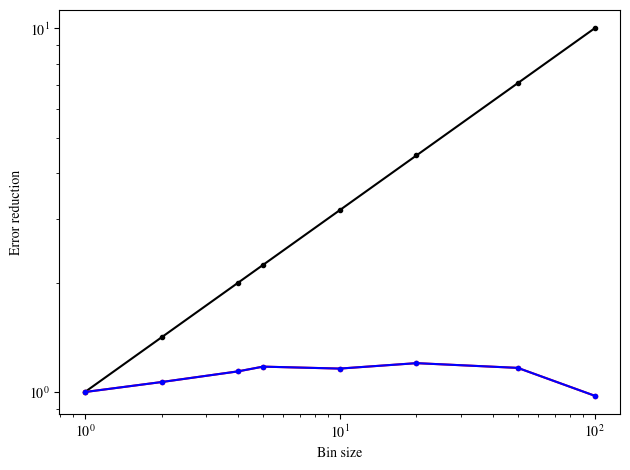

In [19]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

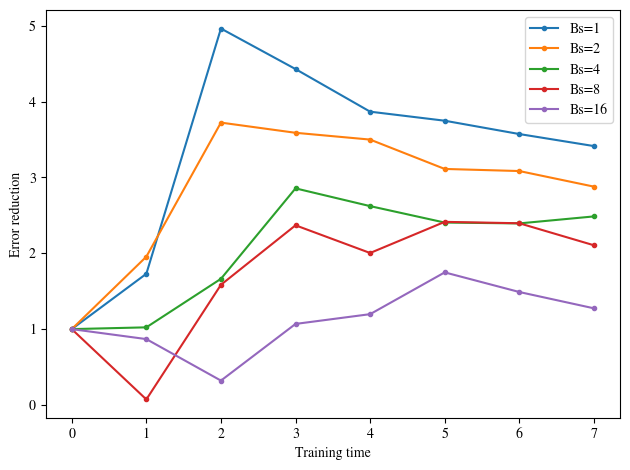

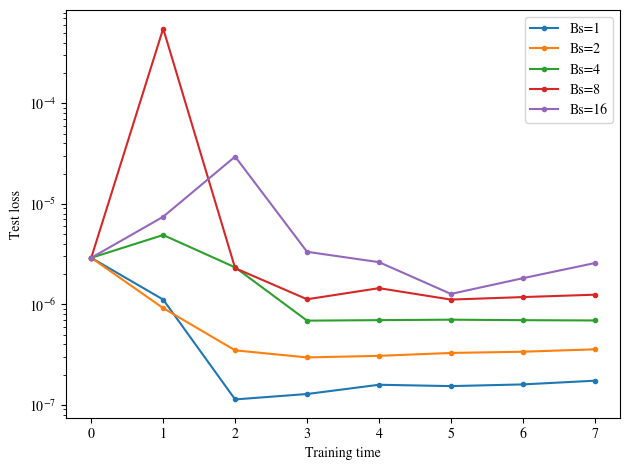

1: (4.962025895341692+0j)
2: (3.7221234500050286+0j)
4: (2.85526632381374+0j)
8: (2.4138193789261853+0j)
16: (1.7477883742165221+0j)
1: 1.1301762015136774e-07
2: 2.959196194751712e-07
4: 6.875184226373676e-07
8: 1.1142010407638736e-06
16: 1.2679042811214458e-06


In [3]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.004751968), np.complex128(2.4192649365659895e-05+0j))
bin size 1: (np.float32(0.004751968), np.complex128(2.41939970034545e-05+0j))
jack bin size 2: (np.float32(0.004751968), np.complex128(3.4177574198031944e-05+0j))
bin size 2: (np.float32(0.004751968), np.complex128(3.417888285517308e-05+0j))
jack bin size 4: (np.float32(0.004751968), np.complex128(4.826351508157042e-05+0j))
bin size 4: (np.float32(0.004751968), np.complex128(4.826205443166974e-05+0j))
jack bin size 5: (np.float32(0.004751968), np.complex128(5.39177432704886e-05+0j))
bin size 5: (np.float32(0.004751968), np.complex128(5.391733841566924e-05+0j))
jack bin size 10: (np.float32(0.004751968), np.complex128(7.599913632467372e-05+0j))
bin size 10: (np.float32(0.004751968), np.complex128(7.599785011775601e-05+0j))
jack bin size 20: (np.float32(0.004751968), np.complex128(0.00010681131384925703+0j))
bin size 20: (np.float32(0.004751968), np.complex128(0.00010681086160132414+0j))
jack bin size 50

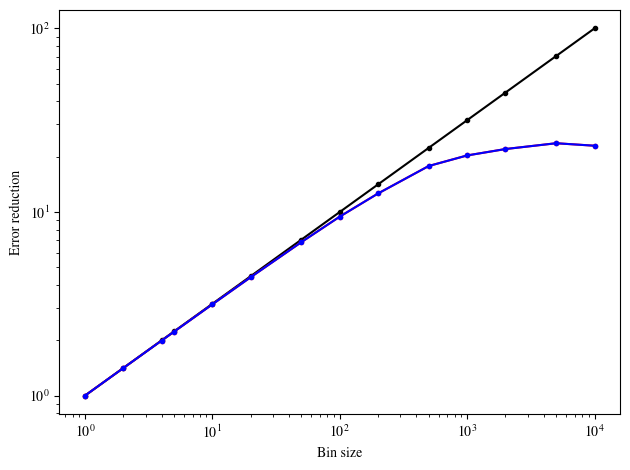

In [18]:
with open("scalar4d/config/c_16x8x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16, 8,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.float32(0.0061484845), np.complex128(0.0003256293228694013+0j))
bin size 1: (np.float32(0.0061484845), np.complex128(0.0003256294832620258+0j))
jack bin size 2: (np.float32(0.0061484845), np.complex128(0.0004364699921827822+0j))
bin size 2: (np.float32(0.0061484845), np.complex128(0.00043647053669950184+0j))
jack bin size 4: (np.float32(0.0061484845), np.complex128(0.000573581504048919+0j))
bin size 4: (np.float32(0.0061484845), np.complex128(0.000573581679726144+0j))
jack bin size 5: (np.float32(0.0061484845), np.complex128(0.0006301083745110126+0j))
bin size 5: (np.float32(0.0061484845), np.complex128(0.0006301085215080161+0j))
jack bin size 10: (np.float32(0.0061484845), np.complex128(0.0007856982032887373+0j))
bin size 10: (np.float32(0.0061484845), np.complex128(0.0007856982610583765+0j))
jack bin size 20: (np.float32(0.0061484845), np.complex128(0.0010516456532059237+0j))
bin size 20: (np.float32(0.0061484845), np.complex128(0.001051645925534623+0j))
jack bin

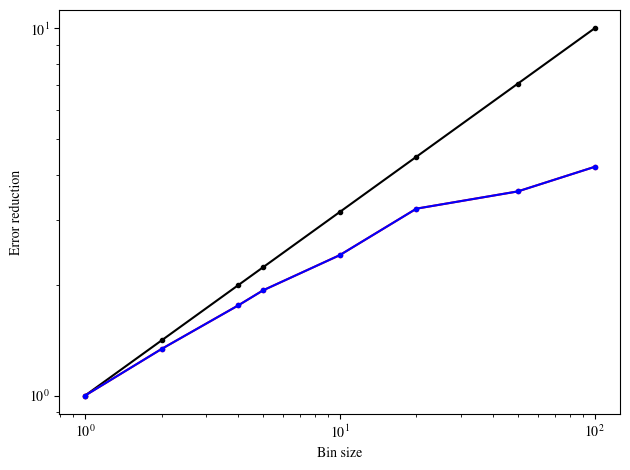

In [19]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

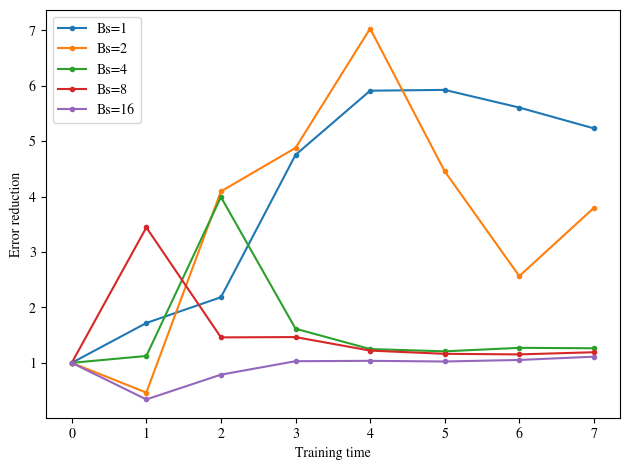

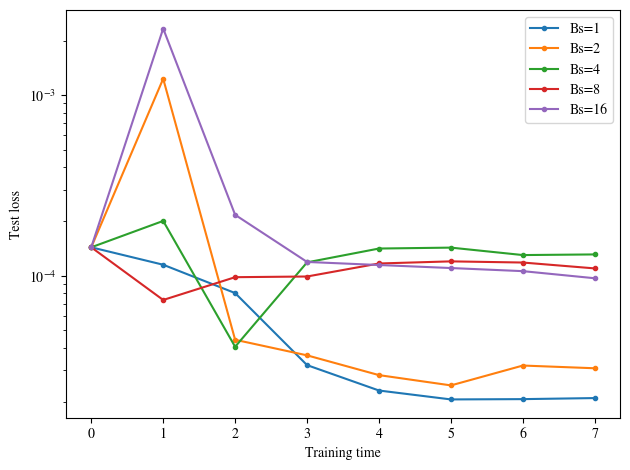

1: (5.926790502669625+0j)
2: (7.034137804722954+0j)
4: (3.992908727314542+0j)
8: (3.4440944209545274+0j)
16: (1.111050499807691+0j)
1: 2.065650187432766e-05
2: 2.4703094823053107e-05
4: 4.0422142774332315e-05
8: 7.342783646890894e-05
16: 9.685686381999403e-05


In [11]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l4, w64

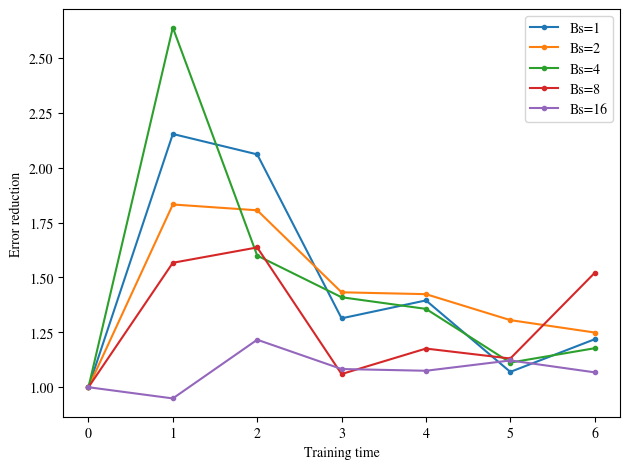

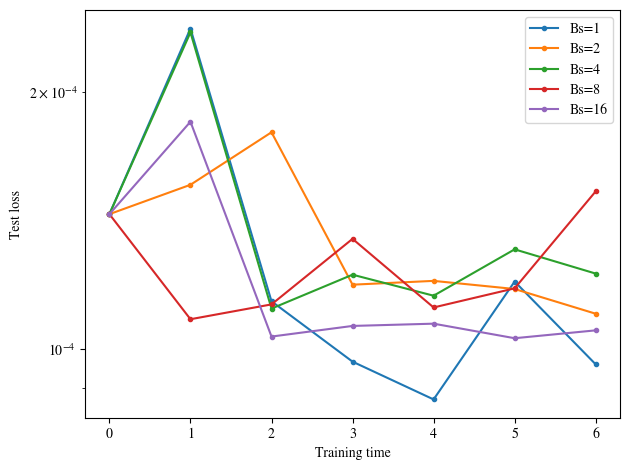

1: (2.1537169773683513+0j)
2: (1.8325268324678092+0j)
4: (2.638604501918644+0j)
8: (1.6367967291922287+0j)
16: (1.2164140421779472+0j)
1: 8.722764323465526e-05
2: 0.00010989799193339422
4: 0.00011143358278786764
8: 0.00010827824735315517
16: 0.00010287543409503996


In [11]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_5h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

# U1_2D_OBC

In [3]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(self.volume, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        x = jnp.ravel(jnp.sin(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        x1 = MLP(self.volume, self.features)(x)
        #x2 = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

In [4]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = nn.celu(x)
        x = nn.Dense(self.volume, use_bias=True,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        pl = jnp.exp(1j*x)

        powers = jnp.array([pl**i for i in range(1, self.n+1)])
        sinx = jnp.hstack((powers.imag, powers.real))[0]
        
        x1 = MLP(self.volume, self.features)(sinx)

        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

jack bin size 1: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0004044174124847068+0.001267882609237746j))
bin size 1: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0004028291006759733+0.0012678842931088557j))
jack bin size 2: (np.complex64(0.90716386+0.012440748j), np.complex128(0.00055687888197215+0.0017666871609030958j))
bin size 2: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0005562643266701203+0.0017666877466610519j))
jack bin size 4: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0007605383170404895+0.0024451418410420815j))
bin size 4: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0007603774094374905+0.0024451403843040805j))
jack bin size 5: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0008363375615015245+0.0027054490277035876j))
bin size 5: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0008363649534576498+0.00270545487704986j))
jack bin size 10: (np.complex64(0.90716386+0.012440748j), np.complex128(0.0011006

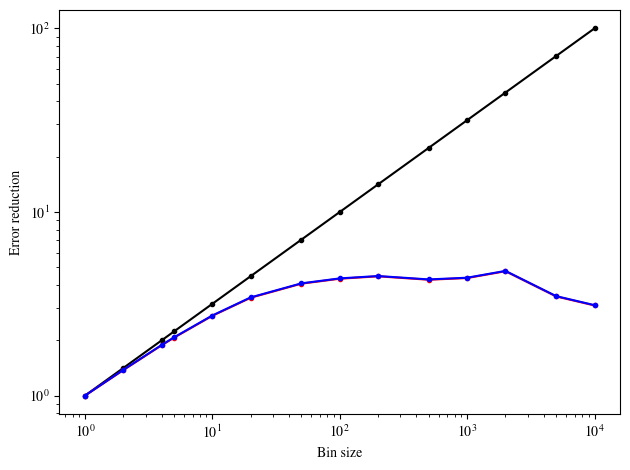

In [27]:
with open("u1_2d_obc/config/c_4x4_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [ ]:
obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

## A=1

jack bin size 1: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0004330303667045552+0.00128229914958399j))
bin size 1: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0004322590017012882+0.001282298865422067j))
jack bin size 2: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0005500436099020957+0.0016287565340216993j))
bin size 2: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0005499981363652033+0.0016287563226193378j))
jack bin size 4: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0006771064944703329+0.0020012471279843556j))
bin size 4: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0006771870683273469+0.002001247079038336j))
jack bin size 5: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0007182450907003965+0.0021171321632105847j))
bin size 5: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0007182183247695014+0.002117131908712784j))
jack bin size 10: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0008140

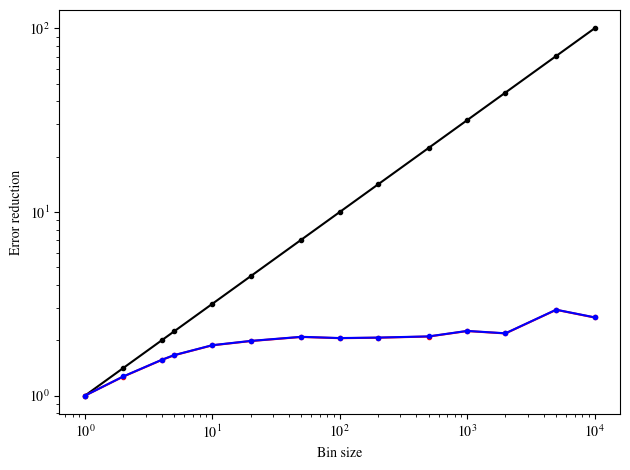

In [10]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.004252732461716096+0.012915282235110525j))
bin size 1: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.004252791997248368+0.01291528460526117j))
jack bin size 2: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.004307632538280409+0.013218291154791067j))
bin size 2: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.004307620307622223+0.013218291149579602j))
jack bin size 4: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.0042280520581111985+0.01319161625540961j))
bin size 4: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.004228100635399918+0.013191617096447035j))
jack bin size 5: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.0041799907194883116+0.0131705940409613j))
bin size 5: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.004180016087560685+0.01317059456086649j))
jack bin size 10: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.003907659321

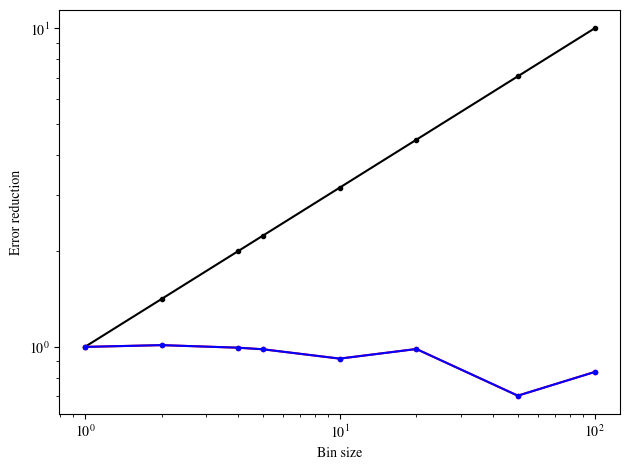

In [11]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [25]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4:
    with open("correlated/u1_2d_obc/cv_1x1_5.55_l1_w16_sin4x_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

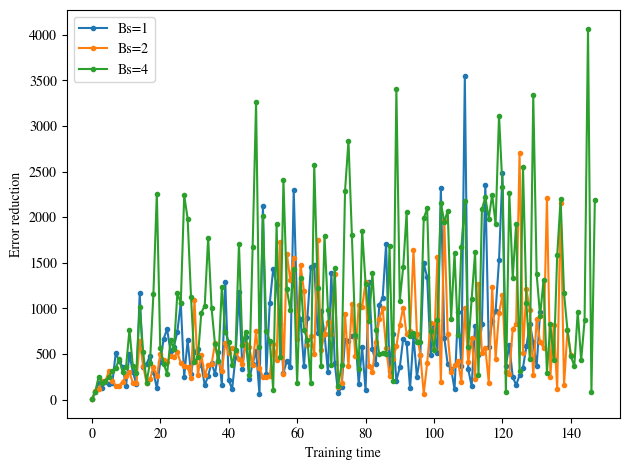

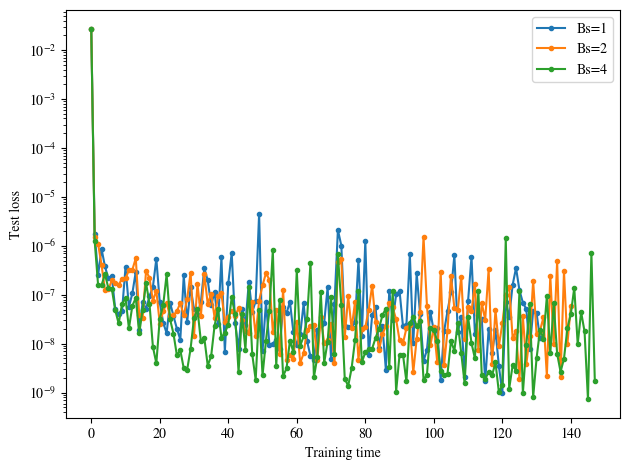

1: (3550.5261929536523+0j)
2: (2700.5303198022757+0j)
4: 4067.638733729946
1: 1.007374850203746e-09
2: 1.908491586988248e-09
4: 7.283325054174838e-10


In [26]:
for i in range(3):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(3):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(3):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(3):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### acc 0.99 with different network

In [9]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):

        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = nn.celu(x)
        x = nn.Dense(self.volume, use_bias=True,
                     kernel_init=self.bias_init)(x)
        return x

class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        pl = jnp.exp(1j*x)

        powers = jnp.array([pl**i for i in range(1, self.n+1)])
        sinx = jnp.hstack((powers.imag, powers.real))[0]
        
        x1 = MLP(self.volume, self.features)(sinx)

        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

jack bin size 1: (np.complex64(0.9200903-0.07042321j), np.complex128(0.00033889309912914174+0.0011706668785148421j))
bin size 1: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0003386943850788071+0.0011707708832353768j))
jack bin size 2: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0004793066634110626+0.0016551731151737727j))
bin size 2: (np.complex64(0.9200903-0.07042321j), np.complex128(0.00047870856369191373+0.0016552318671437672j))
jack bin size 4: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0006762800709119973+0.002339814180102348j))
bin size 4: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0006764212797410624+0.0023398231778579124j))
jack bin size 5: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0007558317363898969+0.002615382455788268j))
bin size 5: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0007559366405222635+0.00261545983326821j))
jack bin size 10: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0010669102644792503+0.

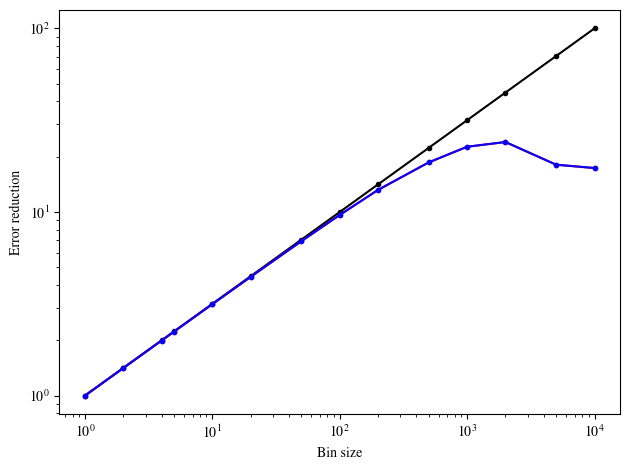

In [29]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.99.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.9043903+0.025512164j), np.complex128(0.0038233330774695446+0.012922479404723356j))
bin size 1: (np.complex64(0.9043903+0.025512164j), np.complex128(0.003823358033572047+0.012922493104451906j))
jack bin size 2: (np.complex64(0.9043903+0.025512164j), np.complex128(0.005161028386054478+0.017860156668822062j))
bin size 2: (np.complex64(0.9043903+0.025512164j), np.complex128(0.005161022887958336+0.0178601623493195j))
jack bin size 4: (np.complex64(0.9043903+0.025512164j), np.complex128(0.006872860755704024+0.0246176046242413j))
bin size 4: (np.complex64(0.9043903+0.025512164j), np.complex128(0.006872870945905262+0.02461760378320388j))
jack bin size 5: (np.complex64(0.9043903+0.025512164j), np.complex128(0.007509002122996376+0.027119669061636313j))
bin size 5: (np.complex64(0.9043903+0.025512164j), np.complex128(0.00750897952775169+0.027119680829649065j))
jack bin size 10: (np.complex64(0.9043903+0.025512164j), np.complex128(0.00951806438259785+0.036056485665

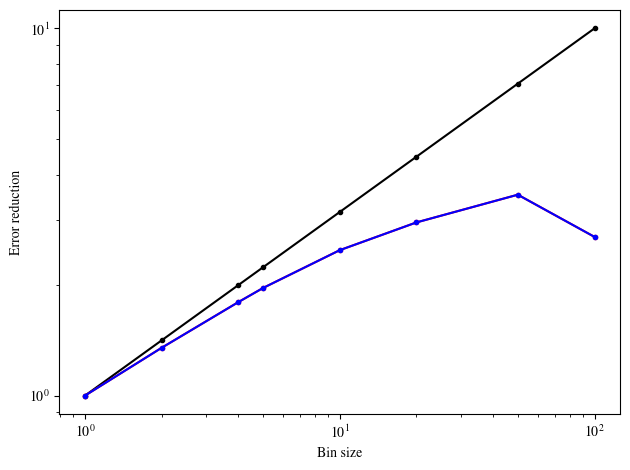

In [31]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [32]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.99_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

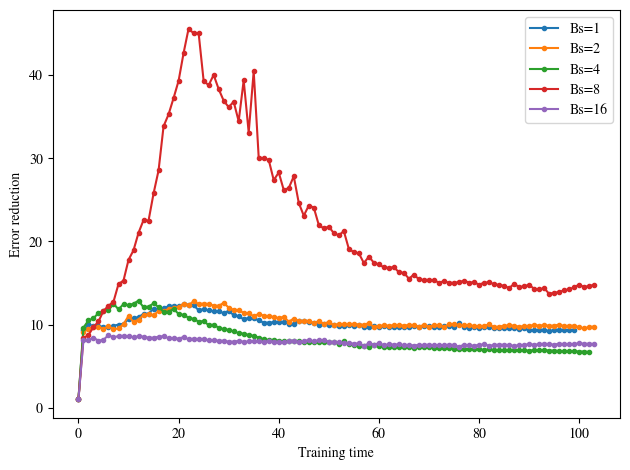

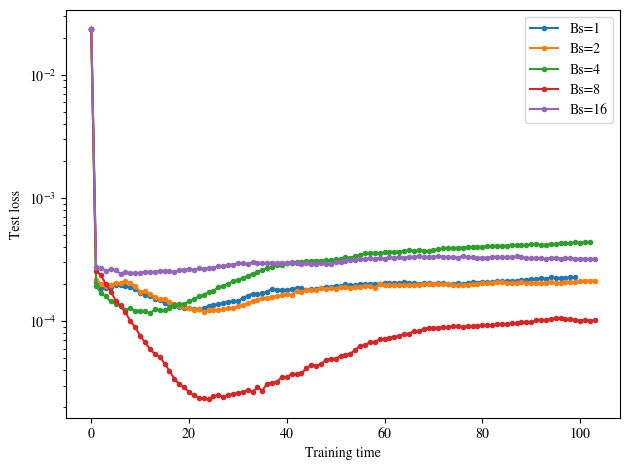

1: 12.464206578511721
2: 12.809858900610411
4: 12.88583686531006
8: 45.61443900901681
16: 8.734359583180376
1: 0.0001251691282959655
2: 0.00011942551645915955
4: 0.00011561233986867592
8: 2.3176020476967096e-05
16: 0.00024243915686383843


In [33]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### acc 0.9

jack bin size 1: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0004268902294121421+0.0012776909818128194j))
bin size 1: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0004263263614455402+0.0012776927993401062j))
jack bin size 2: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0005953459844348571+0.001791437758246601j))
bin size 2: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0005949926941301524+0.0017914386302536327j))
jack bin size 4: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0008247748095434464+0.002501039249612612j))
bin size 4: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0008248785695969781+0.002501039228421269j))
jack bin size 5: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0009139807189024171+0.00278011581841112j))
bin size 5: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0009139883235001872+0.0027801131421711063j))
jack bin size 10: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0012402988511304

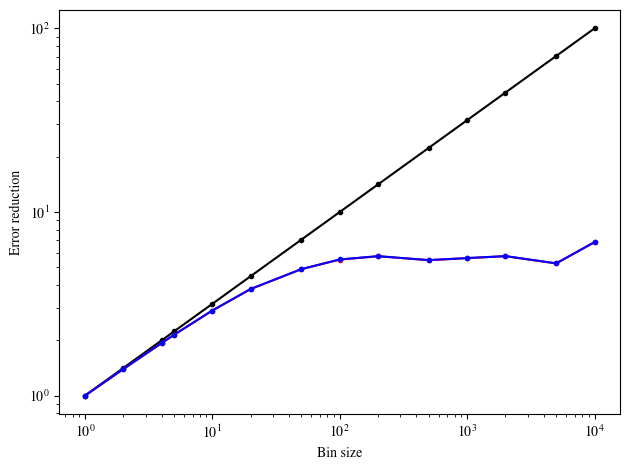

In [6]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004241710875862809+0.012883254646356703j))
bin size 1: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004241728436063999+0.012883254164775978j))
jack bin size 2: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004151462132170037+0.012920523663956131j))
bin size 2: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004151480797685296+0.012920524185102684j))
jack bin size 4: (np.complex64(0.9033833-0.010577672j), np.complex128(0.0039839694969918595+0.012350539934081303j))
bin size 4: (np.complex64(0.9033833-0.010577672j), np.complex128(0.003983997933647546+0.012350540011545277j))
jack bin size 5: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004082816902961444+0.012781818305083589j))
bin size 5: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004082842209140343+0.012781817710906225j))
jack bin size 10: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004165380115544857+0.01212

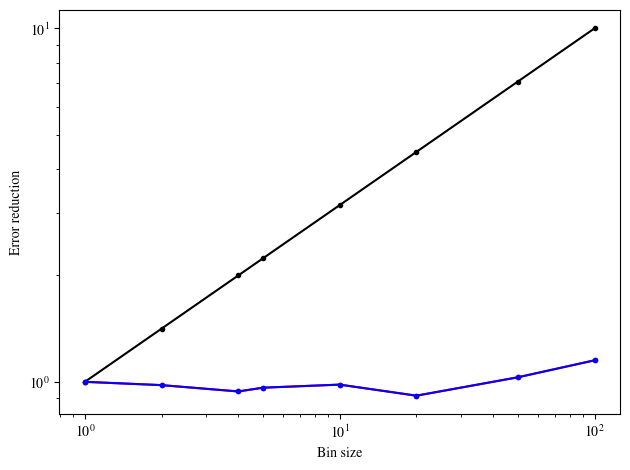

In [7]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

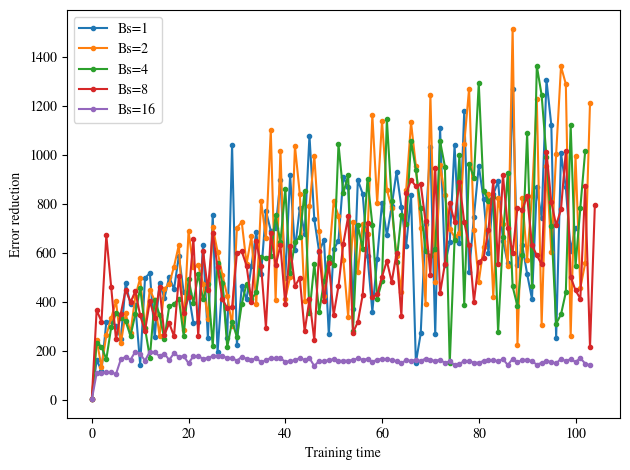

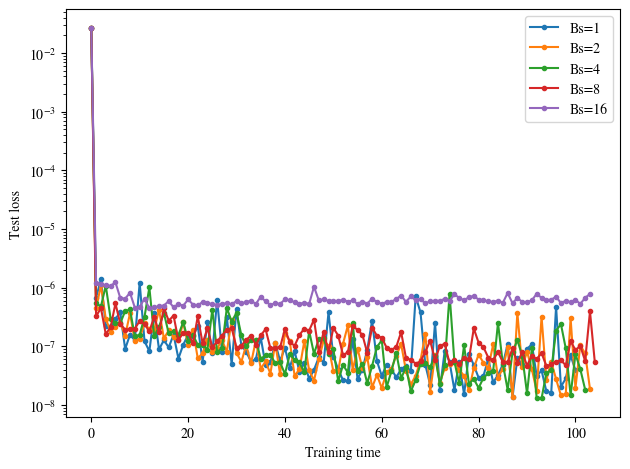

1: 1304.6677518601784
2: 1515.8071445507999
4: 1363.3901669235881
8: 1013.8622489871622
16: 196.29833555869845
1: 1.354501755201909e-08
2: 1.361461965387889e-08
4: 1.298481411282637e-08
8: 4.634558337102135e-08
16: 4.460761999780516e-07


In [10]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### acc 0.95

jack bin size 1: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.00042859684770099555+0.001305564321150812j))
bin size 1: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0004282258901298091+0.001305564805055689j))
jack bin size 2: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0006023887418541169+0.0018411419133634148j))
bin size 2: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0006025976624795194+0.0018411516484107403j))
jack bin size 4: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0008458215038183703+0.002592991273301853j))
bin size 4: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0008459799539647716+0.0025929930447002327j))
jack bin size 5: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0009427475261472895+0.0028936607157635146j))
bin size 5: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0009426284552783121+0.0028936610659327316j))
jack bin size 10: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0013

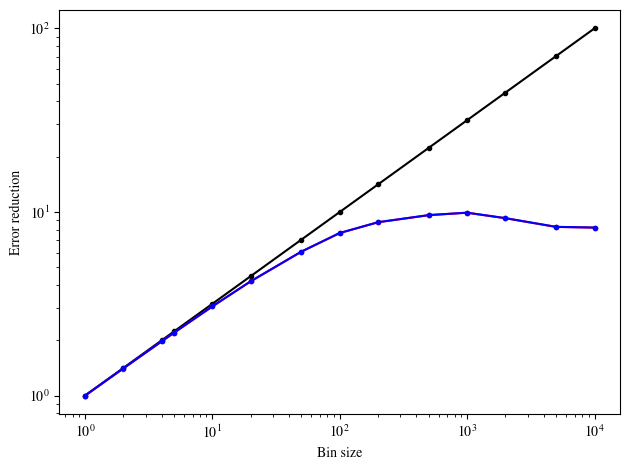

In [20]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.91259897-0.017321236j), np.complex128(0.0036926649859884498+0.012385249880168732j))
bin size 1: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003692730269182074+0.012385250118657083j))
jack bin size 2: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003742823365943806+0.014293360964598342j))
bin size 2: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003742774823096615+0.014293362624450115j))
jack bin size 4: (np.complex64(0.91259897-0.017321236j), np.complex128(0.0039062697898520635+0.015387778812601043j))
bin size 4: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003906241928643035+0.015387779343782574j))
jack bin size 5: (np.complex64(0.91259897-0.017321236j), np.complex128(0.00376624841627322+0.01555546841039336j))
bin size 5: (np.complex64(0.91259897-0.017321236j), np.complex128(0.0037662502503832017+0.0155554703827321j))
jack bin size 10: (np.complex64(0.91259897-0.017321236j), np.complex128(0.0038065567086622387

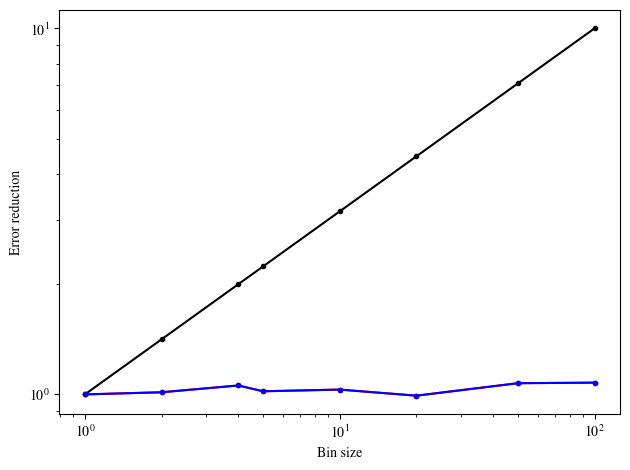

In [21]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

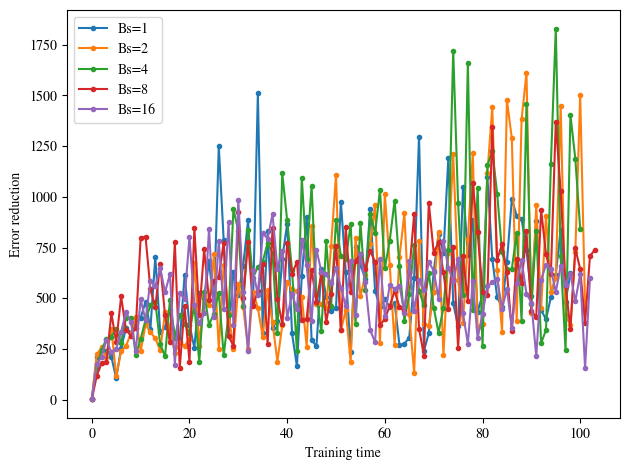

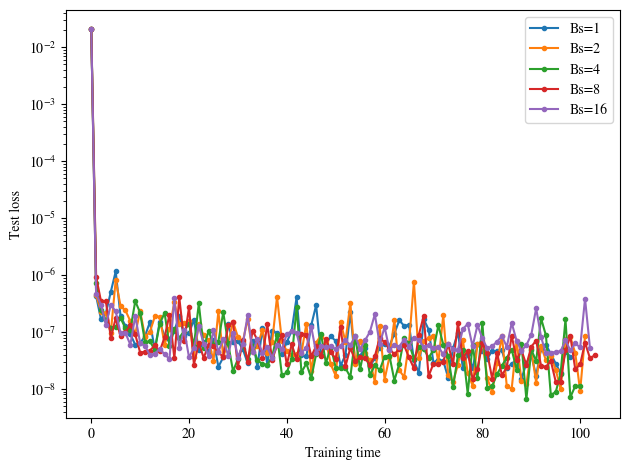

1: 1510.8170188757465
2: 1611.1832891627507
4: 1830.049463734152
8: 1369.5822674840842
16: 982.5066609783328
1: 1.5211053749908388e-08
2: 8.84239792497965e-09
4: 6.545258113277441e-09
8: 1.33610580377308e-08
16: 3.371721390976745e-08


In [24]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## A=2
### acc 0.9

jack bin size 1: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0007544583014665821+0.0016665228432521473j))
bin size 1: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0007548600045034882+0.0016665439587164486j))
jack bin size 2: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0010514557247945913+0.002336366378920034j))
bin size 2: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0010514235433370107+0.002336375239979492j))
jack bin size 4: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0014534038042608541+0.0032614921489406163j))
bin size 4: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0014534422330410792+0.0032614867562155616j))
jack bin size 5: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0016075383392158968+0.0036243840125695127j))
bin size 5: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0016075947495615174+0.0036244152832053764j))
jack bin size 10: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0021656899944

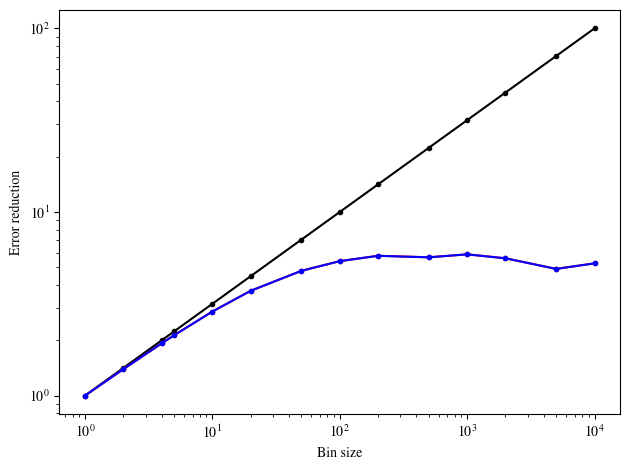

In [11]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=2
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008064339322462795+0.01661459614006134j))
bin size 1: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008064304095247098+0.01661459775699395j))
jack bin size 2: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008083154208966324+0.016687290354608055j))
bin size 2: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008083137476253346+0.01668728942696719j))
jack bin size 4: (np.complex64(0.8119221-0.006802482j), np.complex128(0.007775881270466398+0.01722252944027777j))
bin size 4: (np.complex64(0.8119221-0.006802482j), np.complex128(0.007775877659169743+0.017222531343678255j))
jack bin size 5: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008103117005646662+0.01664522288380143j))
bin size 5: (np.complex64(0.8119221-0.006802482j), np.complex128(0.00810309984877533+0.016645221241561217j))
jack bin size 10: (np.complex64(0.8119221-0.006802482j), np.complex128(0.007950403406222868+0.016219513329

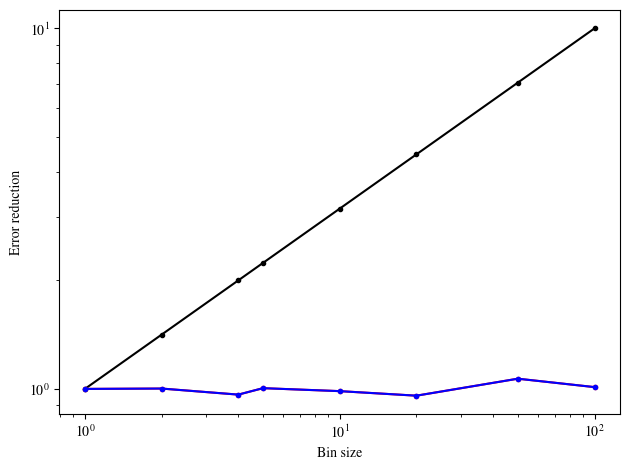

In [12]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

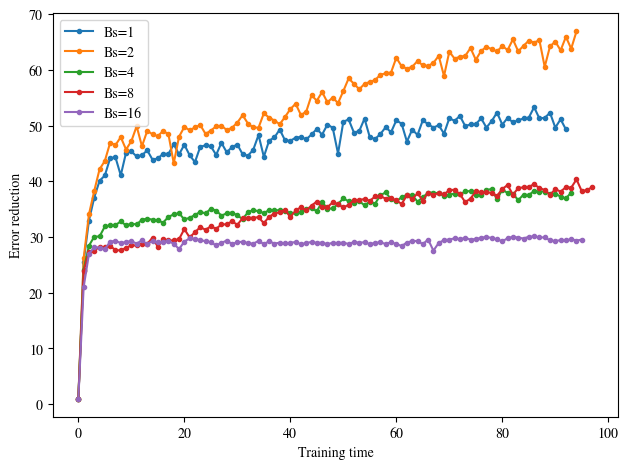

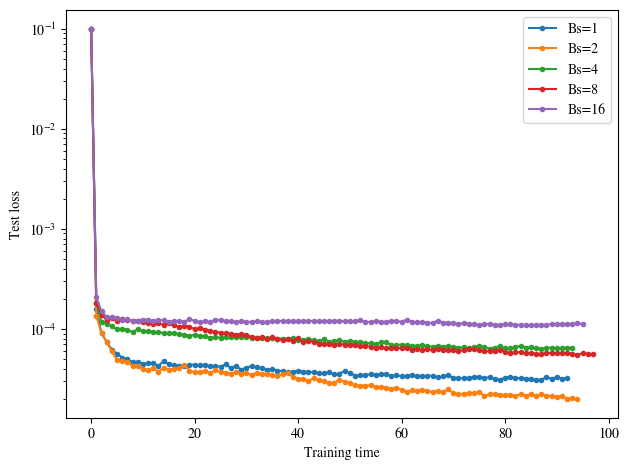

1: 53.318721558784866
2: 66.94254243450146
4: 38.63112405918238
8: 40.356523787205795
16: 30.109848036050664
1: 3.11381409119349e-05
2: 1.9778834030148573e-05
4: 6.339087121887133e-05
8: 5.4830783483339474e-05
16: 0.00010902848589466885


In [21]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### acc 0.95

jack bin size 1: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0007858813464481215+0.00167867980674745j))
bin size 1: (np.complex64(0.81015176+0.014589203j), np.complex128(0.000785428510663828+0.0016786981903800355j))
jack bin size 2: (np.complex64(0.81015176+0.014589203j), np.complex128(0.001105021415623941+0.0023670660759158887j))
bin size 2: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0011051070135157388+0.002367078203007505j))
jack bin size 4: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0015510171241164626+0.0033330175476751953j))
bin size 4: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0015510318122480134+0.003333026329174372j))
jack bin size 5: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0017283148262720288+0.0037187248430714855j))
bin size 5: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0017283239382734179+0.003718727958090609j))
jack bin size 10: (np.complex64(0.81015176+0.014589203j), np.complex128(0.002404238

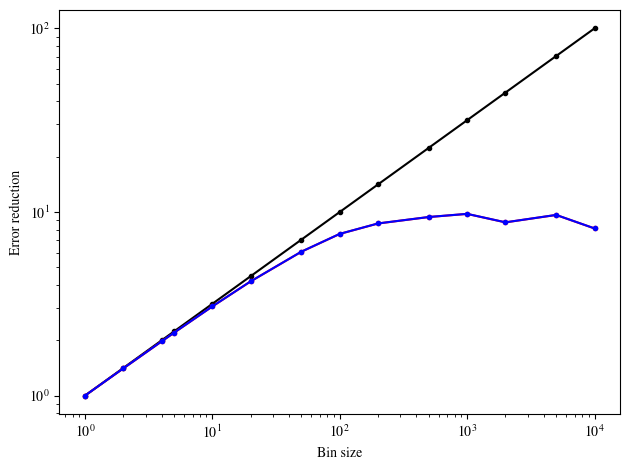

In [25]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=2
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.8323471-0.009052431j), np.complex128(0.007258245747163952+0.015960654538696j))
bin size 1: (np.complex64(0.8323471-0.009052431j), np.complex128(0.00725822982046985+0.015960656288224448j))
jack bin size 2: (np.complex64(0.8323471-0.009052431j), np.complex128(0.007366598117256905+0.018237407793043236j))
bin size 2: (np.complex64(0.8323471-0.009052431j), np.complex128(0.0073665988208047525+0.018237410417016136j))
jack bin size 4: (np.complex64(0.8323471-0.009052431j), np.complex128(0.007996919550047681+0.020239367484278726j))
bin size 4: (np.complex64(0.8323471-0.009052431j), np.complex128(0.007996960133792119+0.020239368583529396j))
jack bin size 5: (np.complex64(0.8323471-0.009052431j), np.complex128(0.0079466804878177+0.02071482714316136j))
bin size 5: (np.complex64(0.8323471-0.009052431j), np.complex128(0.007946707613664769+0.02071482702762687j))
jack bin size 10: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008392325981914996+0.0223000460047

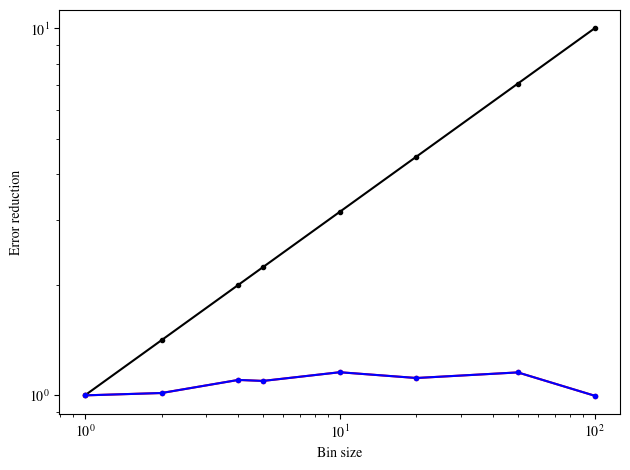

In [26]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

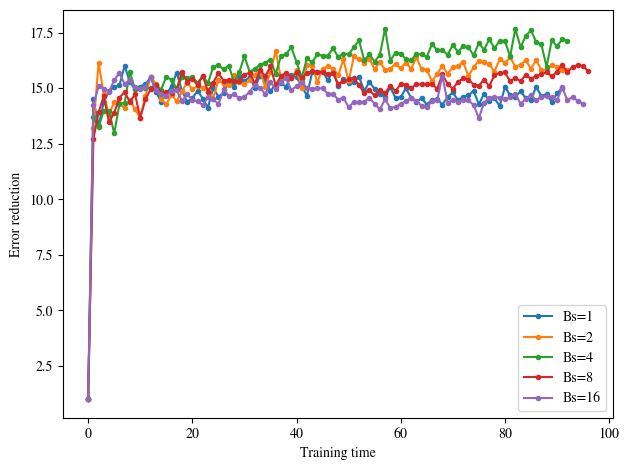

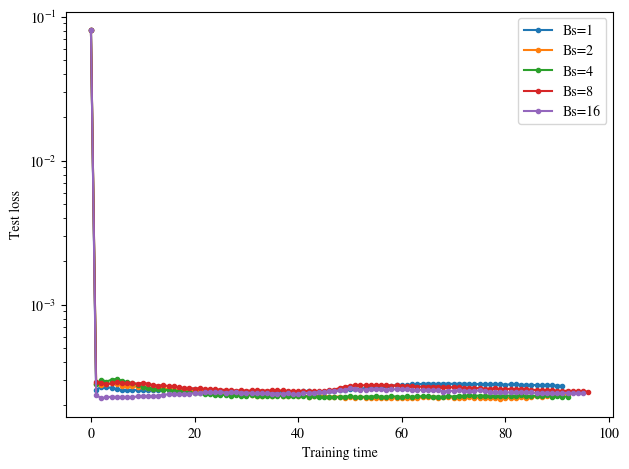

1: 16.002129034839758
2: 16.693062223800762
4: 17.681105213493193
8: 16.06156982690565
16: 15.6813689854191
1: 0.0002434938942315057
2: 0.00022308752522803843
4: 0.00022774450189899653
8: 0.0002491404884494841
16: 0.0002242360933450982


In [27]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## A=4
### acc 0.9

jack bin size 1: (np.complex64(0.6672563-0.02573131j), np.complex128(0.001257035259844239+0.001989762408458275j))
bin size 1: (np.complex64(0.6672563-0.02573131j), np.complex128(0.0012578559163499378+0.001989750053127259j))
jack bin size 2: (np.complex64(0.6672563-0.02573131j), np.complex128(0.0017499112001666938+0.00278561705325151j))
bin size 2: (np.complex64(0.6672563-0.02573131j), np.complex128(0.001750028375060165+0.002785609161752196j))
jack bin size 4: (np.complex64(0.6672563-0.02573131j), np.complex128(0.0024162030678166494+0.003880989716971738j))
bin size 4: (np.complex64(0.6672563-0.02573131j), np.complex128(0.002416182633886043+0.0038809797996994205j))
jack bin size 5: (np.complex64(0.6672563-0.02573131j), np.complex128(0.002671423964059195+0.004309167518407056j))
bin size 5: (np.complex64(0.6672563-0.02573131j), np.complex128(0.0026715030558942554+0.004309161482631433j))
jack bin size 10: (np.complex64(0.6672563-0.02573131j), np.complex128(0.003588295946017561+0.00589980157

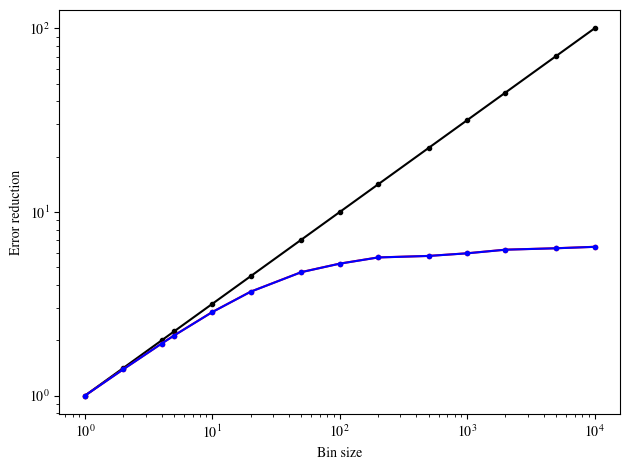

In [13]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=4
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.6527751-0.005674377j), np.complex128(0.012927937994253331+0.020181568225244945j))
bin size 1: (np.complex64(0.6527751-0.005674377j), np.complex128(0.012927919515549707+0.02018156682378058j))
jack bin size 2: (np.complex64(0.6527751-0.005674377j), np.complex128(0.012898964042087995+0.02049096884464437j))
bin size 2: (np.complex64(0.6527751-0.005674377j), np.complex128(0.012898936543790082+0.020490968855067303j))
jack bin size 4: (np.complex64(0.6527751-0.005674377j), np.complex128(0.013265240571852912+0.02028358414150867j))
bin size 4: (np.complex64(0.6527751-0.005674377j), np.complex128(0.013265236495772418+0.02028358555061523j))
jack bin size 5: (np.complex64(0.6527751-0.005674377j), np.complex128(0.013185989221800573+0.019256775669281814j))
bin size 5: (np.complex64(0.6527751-0.005674377j), np.complex128(0.013185986131253043+0.01925677599112788j))
jack bin size 10: (np.complex64(0.6527751-0.005674377j), np.complex128(0.013068666442700074+0.01858431531

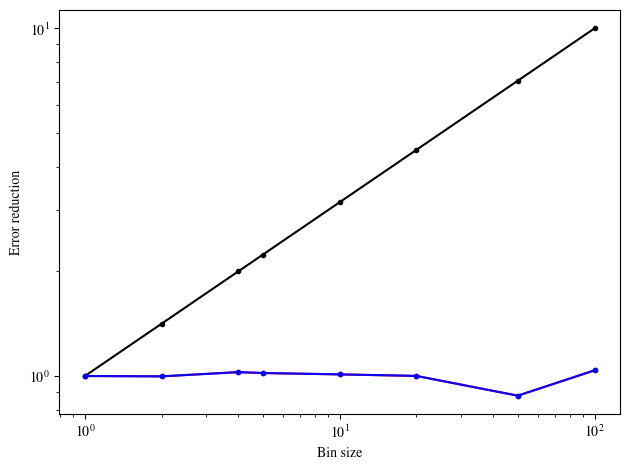

In [14]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

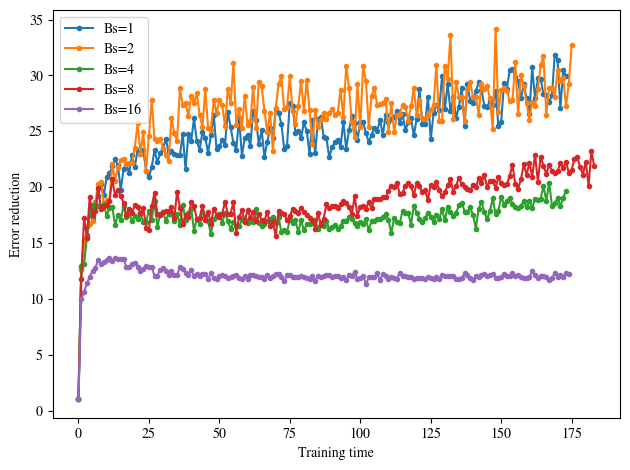

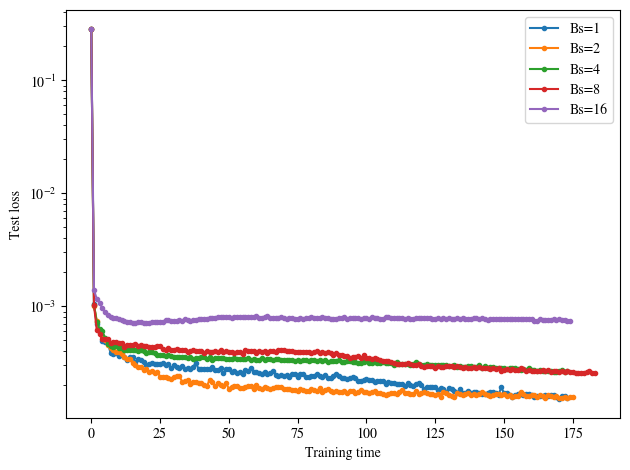

1: 31.868284447316363
2: 34.19584270409141
4: 20.410124778517474
8: 23.223110188836074
16: 13.701457977332606
1: 0.00015002710279077291
2: 0.00015378094394691288
4: 0.0002628222282510251
8: 0.00025563707458786666
16: 0.0007109605357982218


In [22]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### acc 0.95

jack bin size 1: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0013166798631763438+0.002009274465009969j))
bin size 1: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0013167431433142199+0.0020092633975312803j))
jack bin size 2: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0018525201028294286+0.002831834274972119j))
bin size 2: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0018523140964558135+0.0028318428697372863j))
jack bin size 4: (np.complex64(0.6500853+0.017721476j), np.complex128(0.002598875029402924+0.003984958891160889j))
bin size 4: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0025989039090845278+0.003984950243620451j))
jack bin size 5: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0028948193135412163+0.00444458429290129j))
bin size 5: (np.complex64(0.6500853+0.017721476j), np.complex128(0.002894901900174136+0.004444593650924079j))
jack bin size 10: (np.complex64(0.6500853+0.017721476j), np.complex128(0.004022445179681236+0

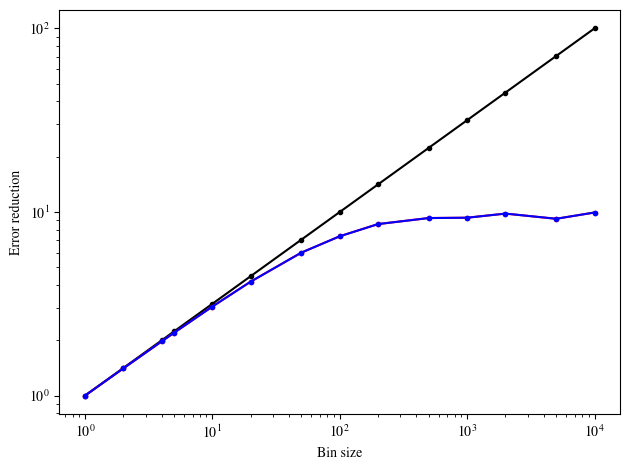

In [28]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=4
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.69231987-0.018825065j), np.complex128(0.01181288999933676+0.019527319382743272j))
bin size 1: (np.complex64(0.69231987-0.018825065j), np.complex128(0.011812843423206263+0.019527317968387643j))
jack bin size 2: (np.complex64(0.69231987-0.018825065j), np.complex128(0.012411641952906734+0.02180358457319668j))
bin size 2: (np.complex64(0.69231987-0.018825065j), np.complex128(0.012411594307083048+0.021803587100757468j))
jack bin size 4: (np.complex64(0.69231987-0.018825065j), np.complex128(0.013264497504223103+0.023927174472465434j))
bin size 4: (np.complex64(0.69231987-0.018825065j), np.complex128(0.013264501812695518+0.023927177334943685j))
jack bin size 5: (np.complex64(0.69231987-0.018825065j), np.complex128(0.01404537434429059+0.02476590200624314j))
bin size 5: (np.complex64(0.69231987-0.018825065j), np.complex128(0.014045414830875841+0.024765901874203723j))
jack bin size 10: (np.complex64(0.69231987-0.018825065j), np.complex128(0.013956828644625727+0.0

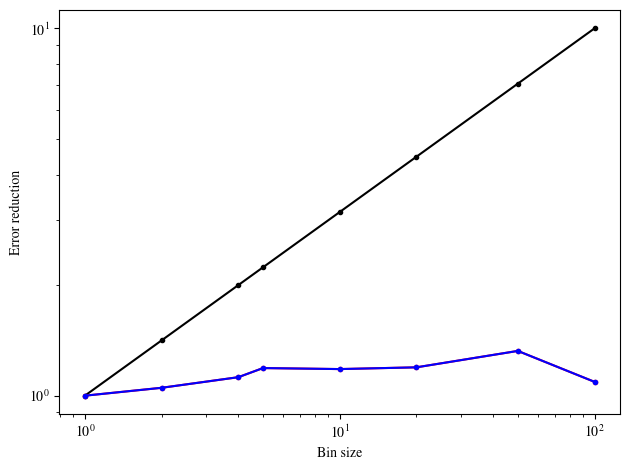

In [29]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

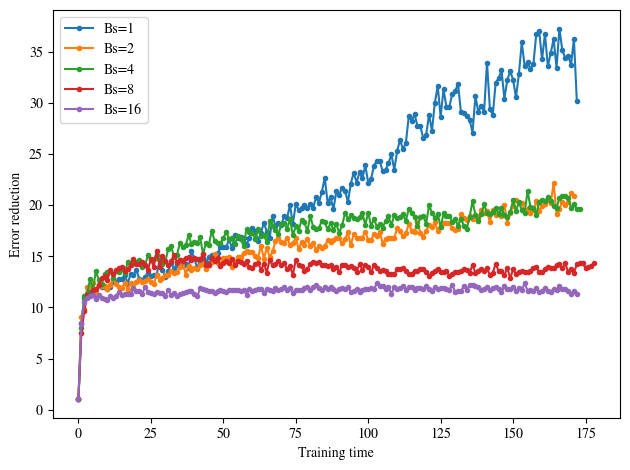

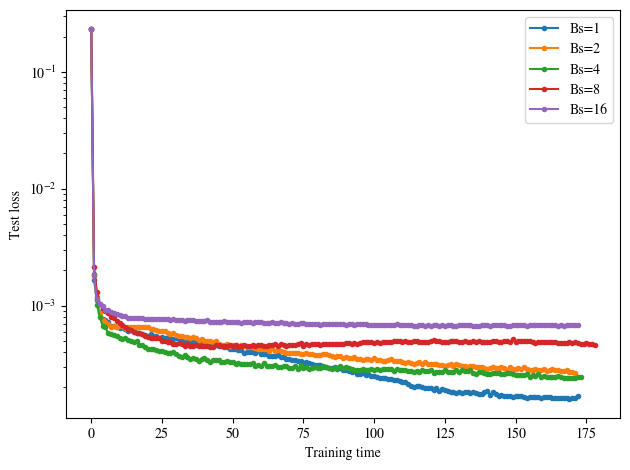

1: 37.28728616525212
2: 22.188603149085335
4: 21.393040658600576
8: 15.538891895063458
16: 12.39932435599286
1: 0.00015761947724968195
2: 0.00026781088672578335
4: 0.00024003400176297873
8: 0.00043984808144159615
16: 0.0006698773358948529


In [34]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l3, w32

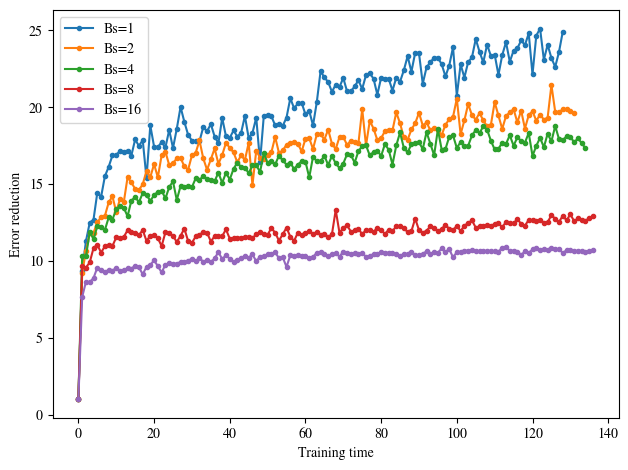

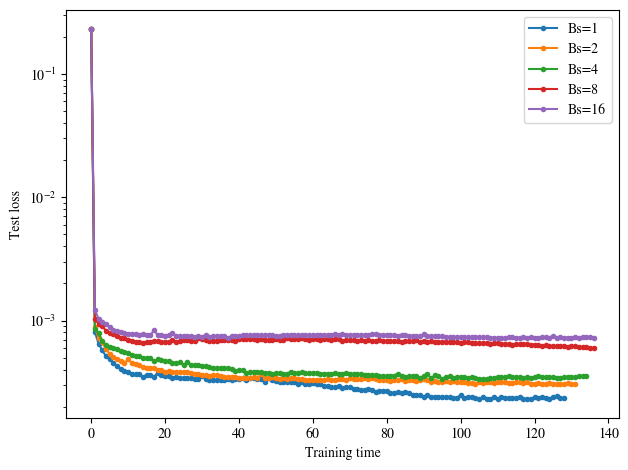

1: 25.124863363171038
2: 21.455245364310127
4: 18.783535335328594
8: 13.322408883186853
16: 10.88950112171693
1: 0.0002289044641656801
2: 0.00030561938183382154
4: 0.00033526733750477433
8: 0.0005982014117762446
16: 0.0007222344866022468


In [4]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## A=8
### acc 0.9

jack bin size 1: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0017958897655476133+0.00218785984028918j))
bin size 1: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0017959592046880547+0.002187843314480767j))
jack bin size 2: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0024907122948722446+0.003050374256485539j))
bin size 2: (np.complex64(0.44578224-0.008827876j), np.complex128(0.00249069240896884+0.003050370471376784j))
jack bin size 4: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0034247949971170344+0.0042232619421198455j))
bin size 4: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0034247935401489427+0.004223261050507328j))
jack bin size 5: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0037808343271368617+0.004681170267792941j))
bin size 5: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0037808775687905227+0.004681168140177949j))
jack bin size 10: (np.complex64(0.44578224-0.008827876j), np.complex128(0.005045838207

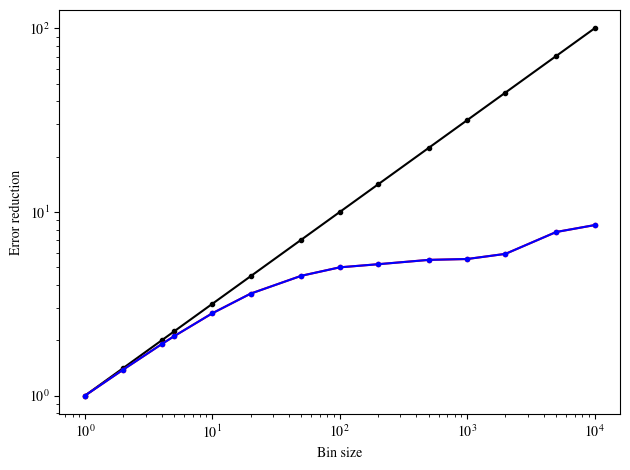

In [15]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=8
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.4203348+0.022922255j), np.complex128(0.01853343846111427+0.021911828880443095j))
bin size 1: (np.complex64(0.4203348+0.022922255j), np.complex128(0.01853345026766888+0.021911827269035313j))
jack bin size 2: (np.complex64(0.4203348+0.022922255j), np.complex128(0.01816834444852083+0.02300489798995161j))
bin size 2: (np.complex64(0.4203348+0.022922255j), np.complex128(0.01816833957058909+0.023004895780290222j))
jack bin size 4: (np.complex64(0.4203348+0.022922255j), np.complex128(0.01863606451251039+0.023616011917353217j))
bin size 4: (np.complex64(0.4203348+0.022922255j), np.complex128(0.01863607102686166+0.023616013555162938j))
jack bin size 5: (np.complex64(0.4203348+0.022922255j), np.complex128(0.018153234589319184+0.02171593349008759j))
bin size 5: (np.complex64(0.4203348+0.022922255j), np.complex128(0.018153209584355196+0.021715932961929932j))
jack bin size 10: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019248000153894027+0.02373539870652

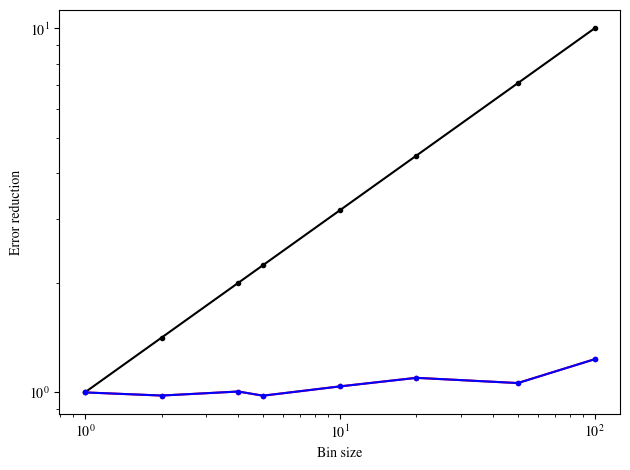

In [16]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

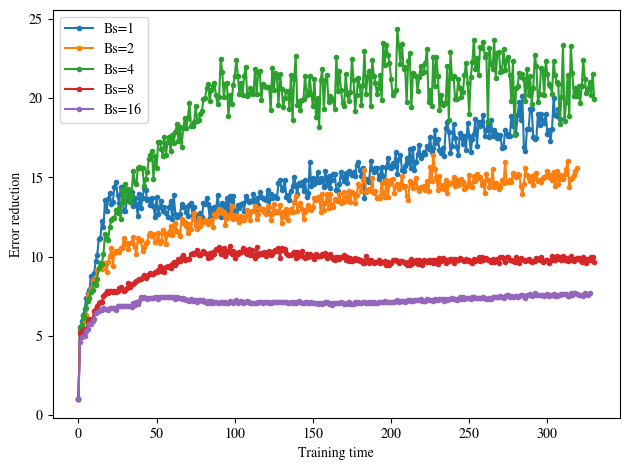

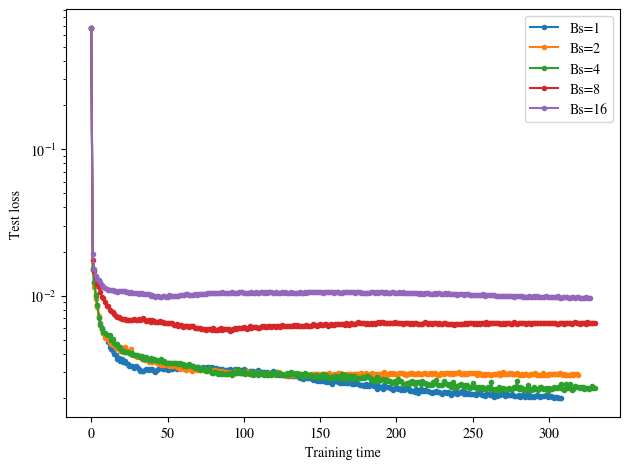

1: 20.141353277152973
2: 16.414446384390097
4: 24.37880435975111
8: 10.688991388921416
16: 7.729164969072281
1: 0.0019800174050033092
2: 0.002832037629559636
4: 0.0022425518836826086
8: 0.005765374284237623
16: 0.00962352380156517


In [23]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### acc 0.95

jack bin size 1: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0018454931792155035+0.002178724897256076j))
bin size 1: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0018454128268180262+0.0021787305151656075j))
jack bin size 2: (np.complex64(0.42982152-0.004857115j), np.complex128(0.002593274016352901+0.003065630861138712j))
bin size 2: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0025932017765038736+0.0030656282560874606j))
jack bin size 4: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0036327994938922113+0.004303617289031915j))
bin size 4: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0036328554387035496+0.004303616310422147j))
jack bin size 5: (np.complex64(0.42982152-0.004857115j), np.complex128(0.004043634091224042+0.004794655228803816j))
bin size 5: (np.complex64(0.42982152-0.004857115j), np.complex128(0.004043657937729708+0.00479465811057402j))
jack bin size 10: (np.complex64(0.42982152-0.004857115j), np.complex128(0.005601460028

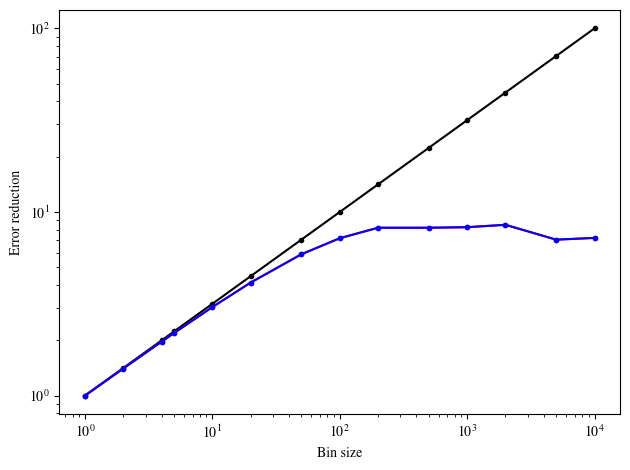

In [ ]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=8
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.49792516-0.029561331j), np.complex128(0.016938783372844157+0.021564478977561724j))
bin size 1: (np.complex64(0.49792516-0.029561331j), np.complex128(0.01693876995304016+0.02156448038455092j))
jack bin size 2: (np.complex64(0.49792516-0.029561331j), np.complex128(0.01791734733333253+0.023559492964737694j))
bin size 2: (np.complex64(0.49792516-0.029561331j), np.complex128(0.017917319368608447+0.023559493105447263j))
jack bin size 4: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018451980299616522+0.025931515360998462j))
bin size 4: (np.complex64(0.49792516-0.029561331j), np.complex128(0.01845196775783039+0.025931515530681452j))
jack bin size 5: (np.complex64(0.49792516-0.029561331j), np.complex128(0.019459692511746115+0.02617715948760743j))
bin size 5: (np.complex64(0.49792516-0.029561331j), np.complex128(0.019459689936977543+0.02617716025508652j))
jack bin size 10: (np.complex64(0.49792516-0.029561331j), np.complex128(0.019119834602967123+0.028

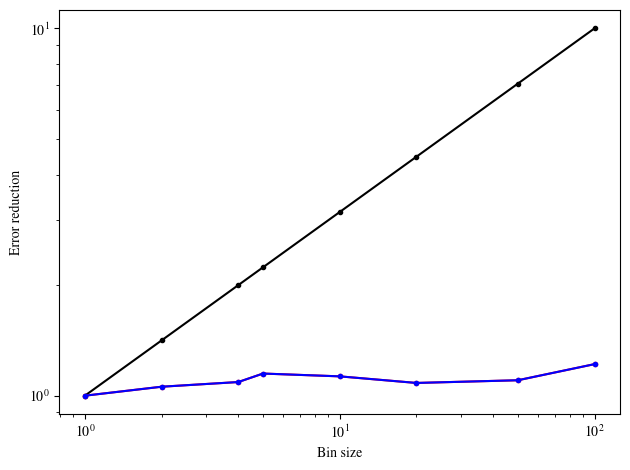

In [32]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

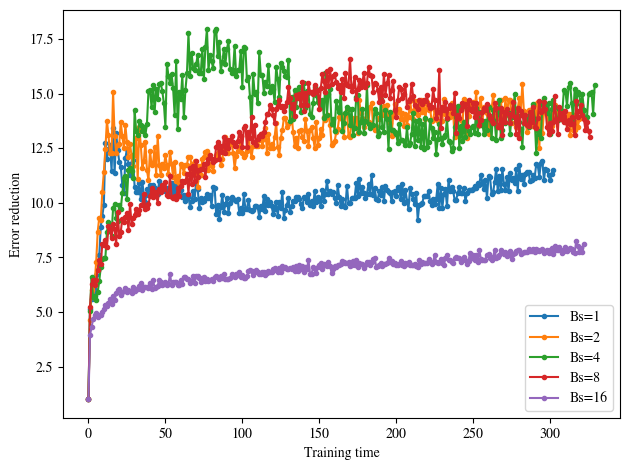

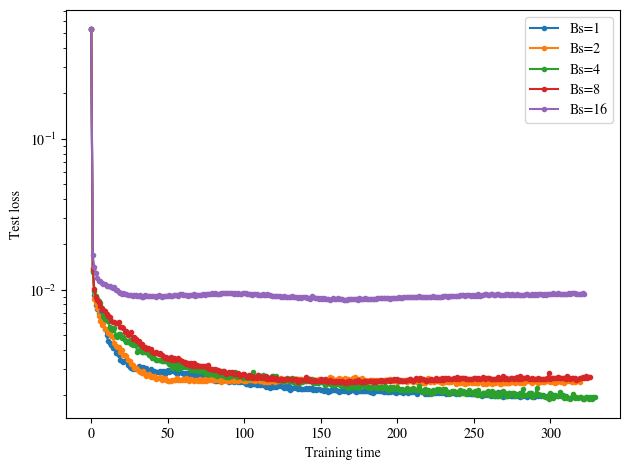

1: 13.426591556423924
2: 15.45034614618175
4: 17.98211509195381
8: 16.58274914727081
16: 8.262118197434631
1: 0.0019450297113507986
2: 0.002366232918575406
4: 0.0018777429359033704
8: 0.002416911767795682
16: 0.008573765866458416


In [5]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l3, w32

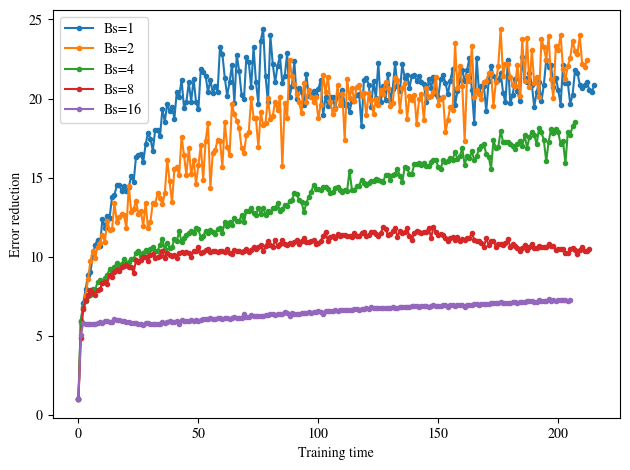

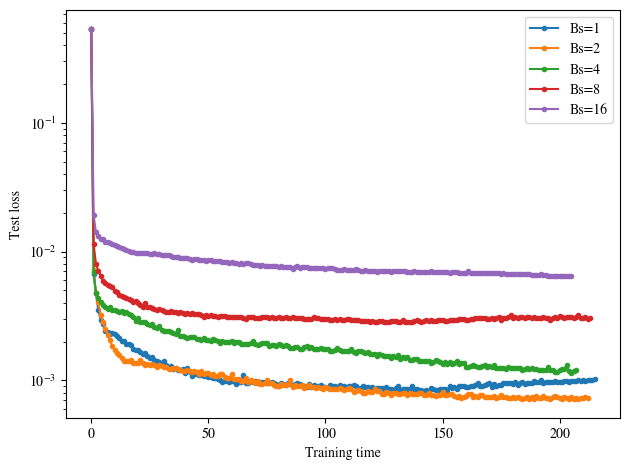

1: 24.425772131650653
2: 24.391080278998118
4: 18.546288525013516
8: 11.885913075297314
16: 7.341274230484339
1: 0.0008288961253128946
2: 0.0007110130973160267
4: 0.0011459568049758673
8: 0.0028172170277684927
16: 0.006412428803741932


In [5]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## A=16
### acc 0.9

jack bin size 1: (np.complex64(0.18995525+0.008539376j), np.complex128(0.002160885557431305+0.0022291343268502385j))
bin size 1: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0021609048867536423+0.0022291329827617405j))
jack bin size 2: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0029726928805991044+0.0030720666184148294j))
bin size 2: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0029726890240663727+0.0030720660128363128j))
jack bin size 4: (np.complex64(0.18995525+0.008539376j), np.complex128(0.004039570720018261+0.004185136594577255j))
bin size 4: (np.complex64(0.18995525+0.008539376j), np.complex128(0.004039563396039394+0.0041851366443688585j))
jack bin size 5: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0044448569646695765+0.004606235435592432j))
bin size 5: (np.complex64(0.18995525+0.008539376j), np.complex128(0.004444843166505231+0.004606234649255196j))
jack bin size 10: (np.complex64(0.18995525+0.008539376j), np.complex128(0.005813792

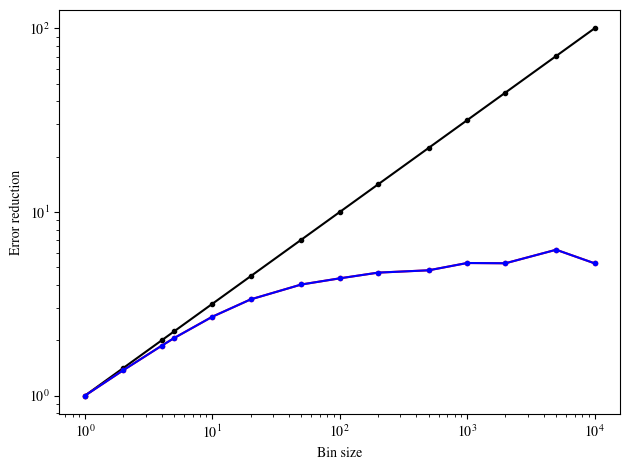

In [17]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=16
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.23388907-0.031027623j), np.complex128(0.021557088632384133+0.02192191080515636j))
bin size 1: (np.complex64(0.23388907-0.031027623j), np.complex128(0.021557093676550888+0.021921910681768568j))
jack bin size 2: (np.complex64(0.23388907-0.031027623j), np.complex128(0.021754693472426898+0.022228814015210045j))
bin size 2: (np.complex64(0.23388907-0.031027623j), np.complex128(0.021754696383030403+0.02222881600598988j))
jack bin size 4: (np.complex64(0.23388907-0.031027623j), np.complex128(0.021311818899905098+0.0236109840407085j))
bin size 4: (np.complex64(0.23388907-0.031027623j), np.complex128(0.02131180001345068+0.02361098409235115j))
jack bin size 5: (np.complex64(0.23388907-0.031027623j), np.complex128(0.021602599208784053+0.022393855175083584j))
bin size 5: (np.complex64(0.23388907-0.031027623j), np.complex128(0.021602609342809057+0.02239385288915123j))
jack bin size 10: (np.complex64(0.23388907-0.031027623j), np.complex128(0.022972688116858535+0.0229

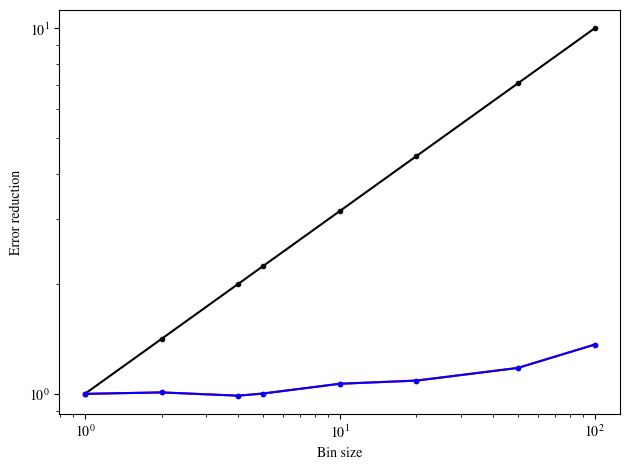

In [18]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

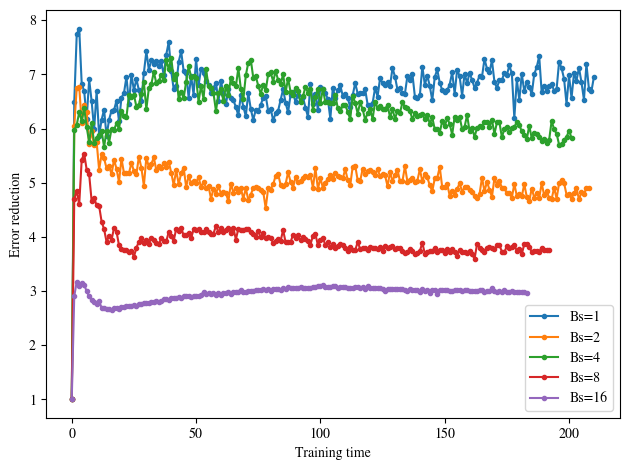

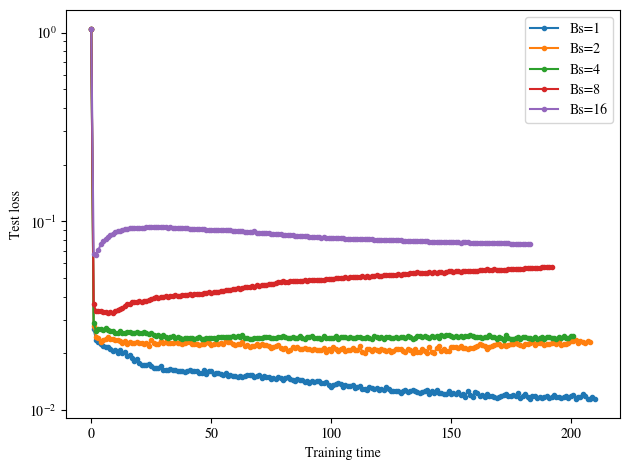

1: 7.8447690576978175
2: 6.771638225221319
4: 7.308021375373437
8: 5.534039263038861
16: 3.173259575430214
1: 0.011424089781939983
2: 0.020037775859236717
4: 0.023680489510297775
8: 0.032799478620290756
16: 0.066342793405056


In [7]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### acc 0.95

In [ ]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=16
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [ ]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

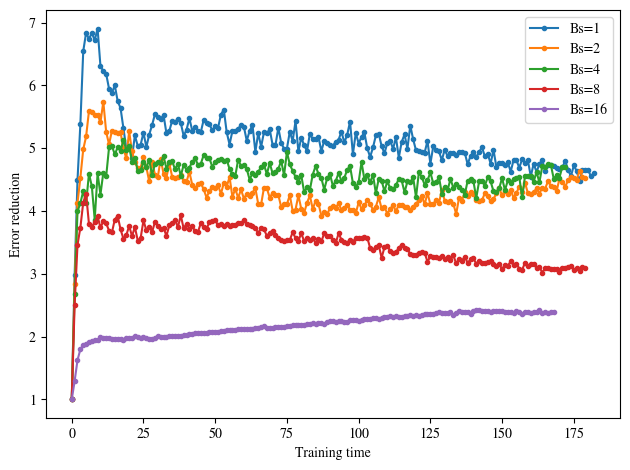

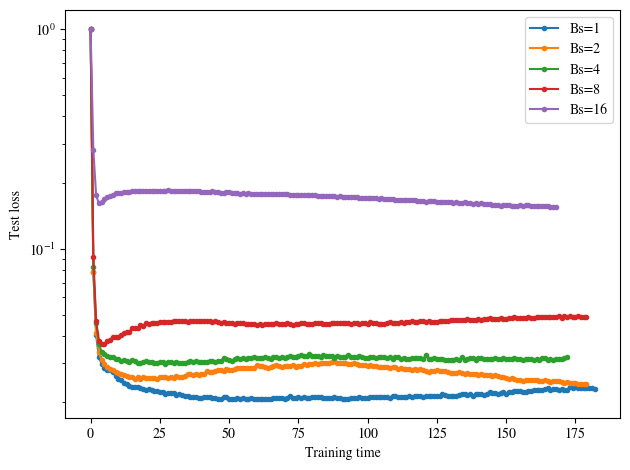

1: 6.906579468502801
2: 5.740324583458335
4: 5.129696798144862
8: 4.27328805661899
16: 2.422392380254361
1: 0.020523278042674065
2: 0.024045681580901146
4: 0.029868612065911293
8: 0.03658305108547211
16: 0.15502721071243286


In [6]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

#### l3, w32

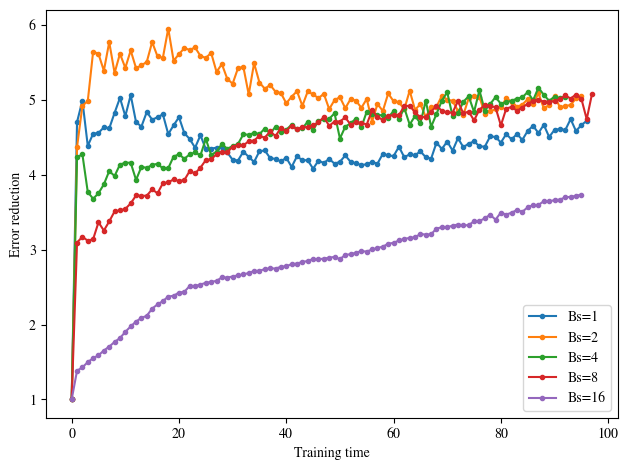

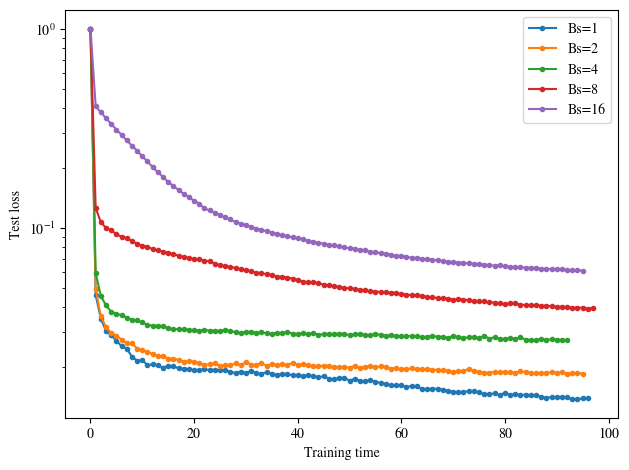

1: 5.062728757467658
2: 5.94994075984613
4: 5.161311538117329
8: 5.08253232795468
16: 3.7330725553929964
1: 0.013715634122490883
2: 0.018492566421628
4: 0.027307244017720222
8: 0.03928237408399582
16: 0.06089732050895691


In [8]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4,8,16:
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

# U1_3D_PBC

In [5]:
## celu activation

class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    bias: bool
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=self.bias,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = nn.celu(x)
            #x = arcsinh(x)
            # x = nn.leaky_relu(x, negative_slope=0.01) #nn.relu jnp.tan nn.tanh #nn.celu
        x = nn.Dense(2, use_bias=self.bias,
                     kernel_init=self.bias_init, bias_init = self.bias_init)(x) ### adfasdfadsf
        return x

class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        pl = model.plaquette(x)

        powers = jnp.array([pl**i for i in range(1, self.n+1)])
        sinx = jnp.hstack((powers.imag, powers.real))[0]
        
        g0 = MLP(self.volume, self.features, True)(sinx)
        # g1 = MLP(self.volume, self.features, True)(sinx)

        y = self.param('bias', nn.initializers.zeros, (1,))
        return g0, y

## 4x4x4

### sweep 1

jack bin size 1: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(4.352403146617307e-06+1.3249392345600106e-06j))
bin size 1: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(4.352409191597789e-06+1.3249235286977428e-06j))
jack bin size 2: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(6.121149464809624e-06+1.8621836703697216e-06j))
bin size 2: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(6.121160390063122e-06+1.8621795824451111e-06j))
jack bin size 4: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(8.584978352263267e-06+2.6103474083093405e-06j))
bin size 4: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(8.584974207015119e-06+2.6103469359944894e-06j))
jack bin size 5: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(9.561470284209279e-06+2.9063285039096628e-06j))
bin size 5: (np.complex64(-1.0629182e-05-2.2237913e-05j), np.complex128(9.561467297693151e-06+2.9063265023183165e-06j))
jack bin size 10: (n

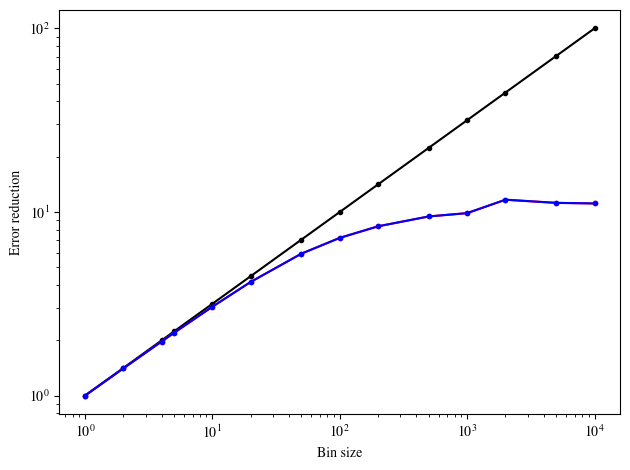

In [15]:
model=eval("gauge.U1_3D_PBC(geom=(4, 4, 4),beta=5.55)")
V= model.dof
 
with open("u1_3d_pbc/config/c_4x4x4_5.55_single_sweep1.pkl", 'rb') as aa:
    conf = jnp.array(pickle.load(aa))

conf = jnp.log(conf).imag.reshape([len(conf), model.dof])

plaq_av_pmap = jax.pmap(jax.vmap(model.plaq_av))

av = jnp.mean(plaq_av_pmap(conf[:200000].reshape(num_devices,200000//num_devices,-1)), axis=(0, 1))

V = model.dof

av = jnp.mean(jax.vmap(model.plaq_av)(conf),axis = 0)

obs = jax.lax.map(lambda x: model.correlation(x, 2, av), conf, batch_size=1000)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.465168377689823e-05+1.2491647948498007e-05j))
bin size 1: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.4651682352528854e-05+1.2491646928779021e-05j))
jack bin size 2: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.8377025451989774e-05+1.3363033945889025e-05j))
bin size 2: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.837702878040624e-05+1.3363034080756052e-05j))
jack bin size 4: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.8500777368803585e-05+1.3585973043246334e-05j))
bin size 4: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.8500772757852804e-05+1.3585972830710323e-05j))
jack bin size 5: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.734864952334619e-05+1.2454917336955397e-05j))
bin size 5: (np.complex64(1.04829205e-07-1.5762074e-05j), np.complex128(4.734864883026821e-05+1.2454914794326303e-05j))
jack bin size 10

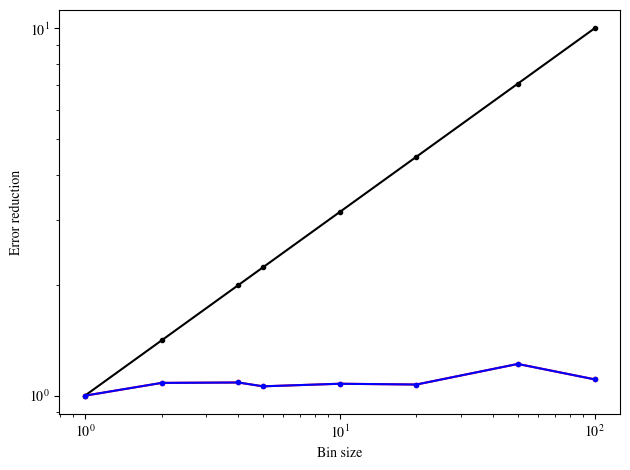

In [17]:
obs = jax.vmap(lambda x: model.correlation(x, 2, av))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [18]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/u1_3d/cv_4x4x4_5.55_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_1h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

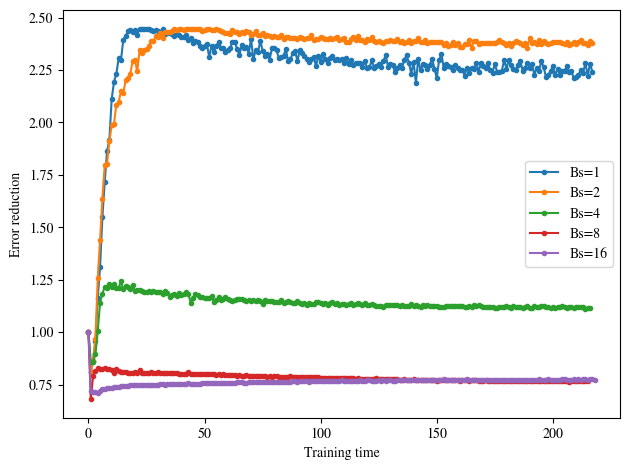

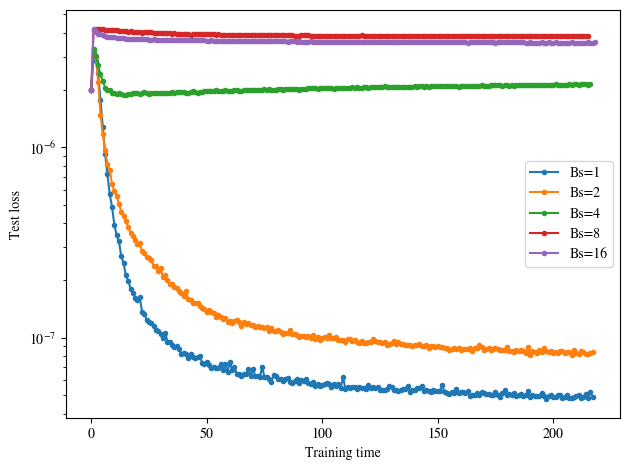

1: (2.447739092930765-1.8888178172267152j)
2: (2.44774677574536-1.879277526482284j)
4: (1.2442692352780134-0.08253719101378697j)
8: (0.9999999999999999-2.904580669350588e-17j)
16: (0.9999999999999999-2.904580669350588e-17j)
1: 4.742465620211078e-08
2: 8.088180436516268e-08
4: 1.887766302388627e-06
8: 1.991778617593809e-06
16: 1.991778617593809e-06


In [19]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 4x4x8

### sweep1

jack bin size 1: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(4.275949653209173e-06+1.256627463689926e-06j))
bin size 1: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(4.2759462675410535e-06+1.2566293420935271e-06j))
jack bin size 2: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(6.031011735726082e-06+1.7715023710437687e-06j))
bin size 2: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(6.0309955430464665e-06+1.7715157112353117e-06j))
jack bin size 4: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(8.493392369176429e-06+2.4931028013552738e-06j))
bin size 4: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(8.49339152795267e-06+2.4931027142736274e-06j))
jack bin size 5: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(9.47988780754654e-06+2.7821503581670975e-06j))
bin size 5: (np.complex64(7.674181e-05-2.4281213e-05j), np.complex128(9.479861714821398e-06+2.78214742219665e-06j))
jack bin size 10: (np.complex64(7.67418

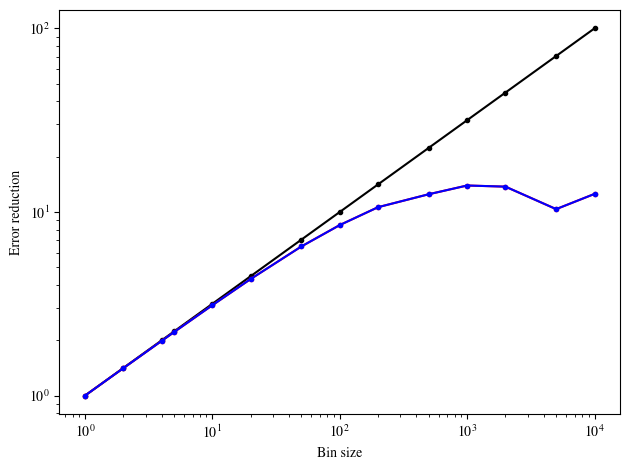

In [23]:
model=eval("gauge.U1_3D_PBC(geom=(4, 4, 8),beta=5.55)")
V= model.dof
 
with open("u1_3d_pbc/config/c_4x4x8_5.55_single_sweep1.pkl", 'rb') as aa:
    conf = jnp.array(pickle.load(aa))

conf = jnp.log(conf).imag.reshape([len(conf), model.dof])

plaq_av_pmap = jax.pmap(jax.vmap(model.plaq_av))

av = jnp.mean(plaq_av_pmap(conf[:200000].reshape(num_devices,200000//num_devices,-1)), axis=(0, 1))

V = model.dof

av = jnp.mean(jax.vmap(model.plaq_av)(conf),axis = 0)

obs = jax.lax.map(lambda x: model.correlation(x, 2, av), conf, batch_size=1000)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(4.472317239038281e-05+1.3285793198294074e-05j))
bin size 1: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(4.472316992651154e-05+1.3285793802571991e-05j))
jack bin size 2: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(5.272893182483214e-05+1.5465700175492325e-05j))
bin size 2: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(5.272892561585952e-05+1.5465701475814046e-05j))
jack bin size 4: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(5.88331359186516e-05+1.7258569483262945e-05j))
bin size 4: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(5.8833138829314293e-05+1.7258569310352292e-05j))
jack bin size 5: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(6.110038734096701e-05+1.656569877449076e-05j))
bin size 5: (np.complex64(-5.743849e-06-6.5244435e-06j), np.complex128(6.110038460089126e-05+1.656569786381853e-05j))
jack bin size 10: (np.complex6

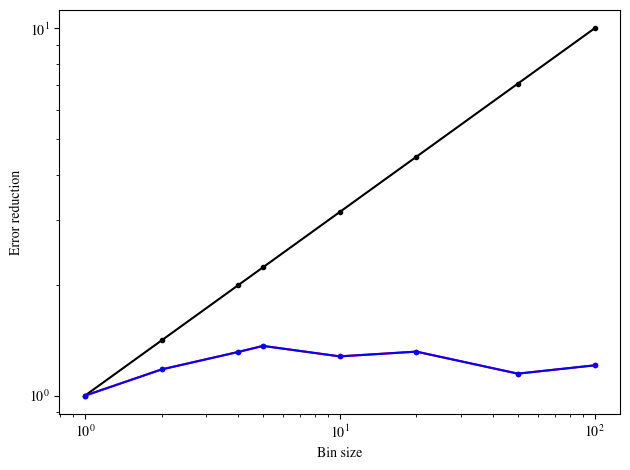

In [24]:
obs = jax.vmap(lambda x: model.correlation(x, 2, av))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [29]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/u1_3d/cv_4x4x8_5.55_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)

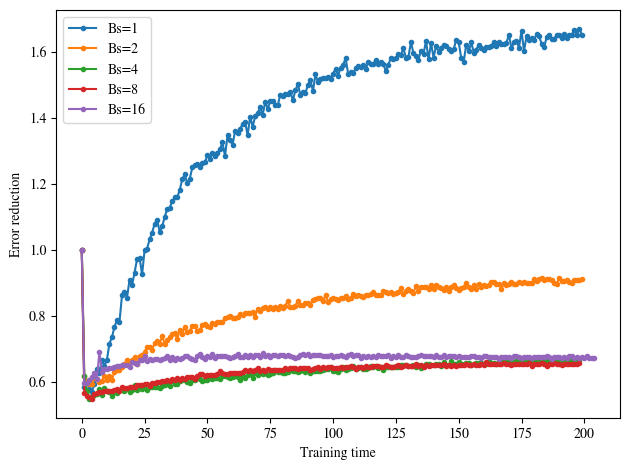

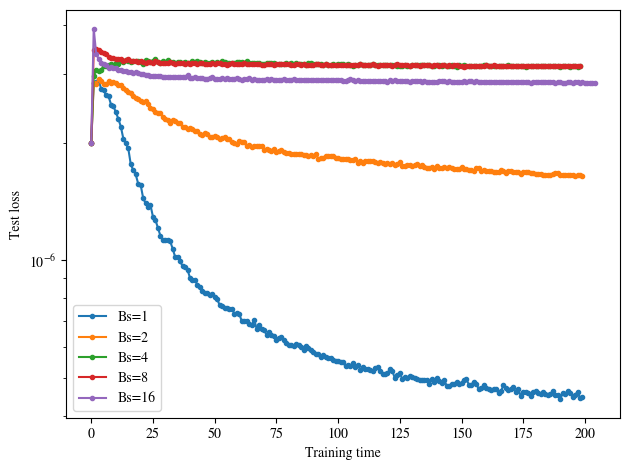

1: (1.6719087351790336-0.46766631914418444j)
2: (1+0j)
4: (1+0j)
8: (1+0j)
16: (1+0j)
1: 4.402386366564315e-07
2: 1.639556217014615e-06
4: 1.998193056351738e-06
8: 1.998193056351738e-06
16: 1.998193056351738e-06


In [30]:
for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### sweep 2

jack bin size 1: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(4.347586307182797e-06+1.302726442702457e-06j))
bin size 1: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(4.34757552111539e-06+1.3027197522590355e-06j))
jack bin size 2: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(6.115030575818508e-06+1.8307372282128463e-06j))
bin size 2: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(6.1150211169430855e-06+1.830738194810094e-06j))
jack bin size 4: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(8.580976082156894e-06+2.5660351162747495e-06j))
bin size 4: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(8.580973207867116e-06+2.5660342505926317e-06j))
jack bin size 5: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(9.558105094969921e-06+2.857519694679266e-06j))
bin size 5: (np.complex64(3.6469006e-05-1.1412193e-05j), np.complex128(9.558110283137297e-06+2.8575195196661045e-06j))
jack bin size 10: (np.complex64

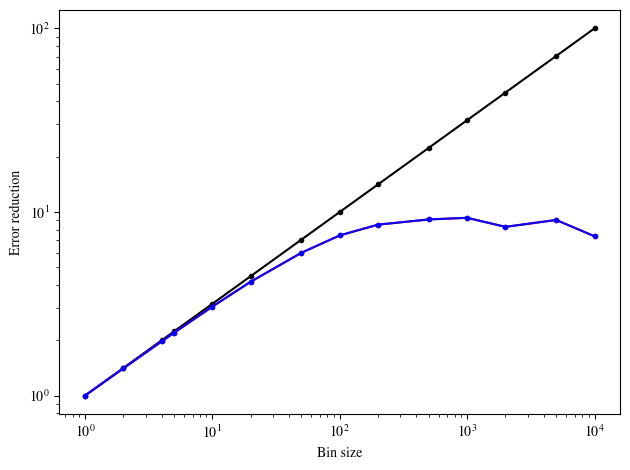

In [13]:
model=eval("gauge.U1_3D_PBC(geom=(4, 4, 8),beta=5.55)")
V= model.dof
 
with open("u1_3d_pbc/config/c_4x4x8_5.55_single_sweep2.pkl", 'rb') as aa:
    conf = jnp.array(pickle.load(aa))

conf = jnp.log(conf).imag.reshape([len(conf), model.dof])

plaq_av_pmap = jax.pmap(jax.vmap(model.plaq_av))

av = jnp.mean(plaq_av_pmap(conf[:200000].reshape(num_devices,200000//num_devices,-1)), axis=(0, 1))

V = model.dof

av = jnp.mean(jax.vmap(model.plaq_av)(conf),axis = 0)

obs = jax.lax.map(lambda x: model.correlation(x, 2, av), conf, batch_size=1000)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.370238182511889e-05+1.1591381903424735e-05j))
bin size 1: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.370238085036106e-05+1.1591381025782997e-05j))
jack bin size 2: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.4879837292004395e-05+1.1590778677433096e-05j))
bin size 2: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.487983835058333e-05+1.1590780115166509e-05j))
jack bin size 4: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.78917535365533e-05+1.1928972305570628e-05j))
bin size 4: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.789175468929099e-05+1.192897233438907e-05j))
jack bin size 5: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.869773702503839e-05+1.163654766405523e-05j))
bin size 5: (np.complex64(3.3972876e-05+1.0976359e-05j), np.complex128(4.8697736783267e-05+1.1636547917915185e-05j))
jack bin size 10: (np.complex64(

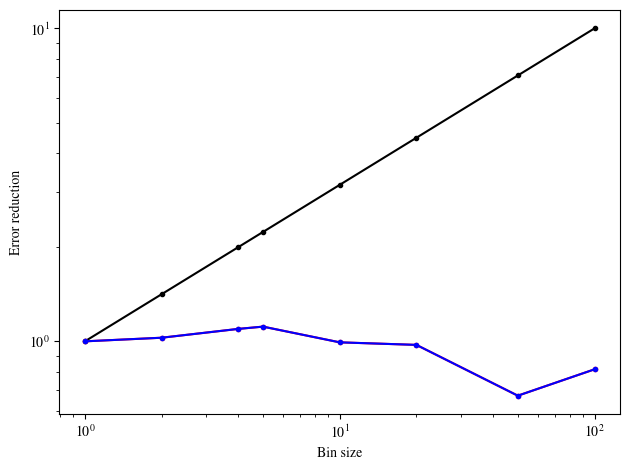

In [14]:
obs = jax.vmap(lambda x: model.correlation(x, 2, av))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

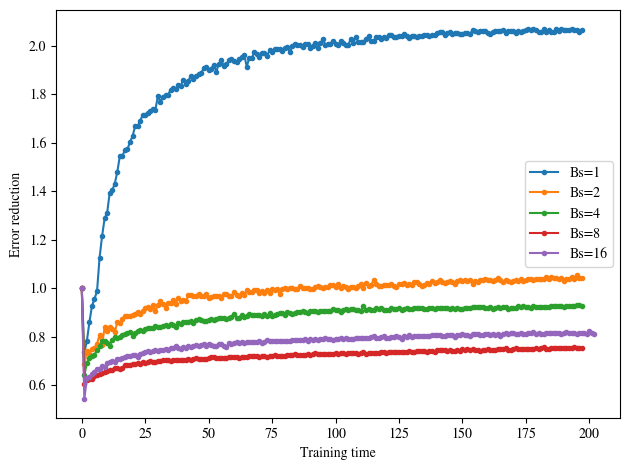

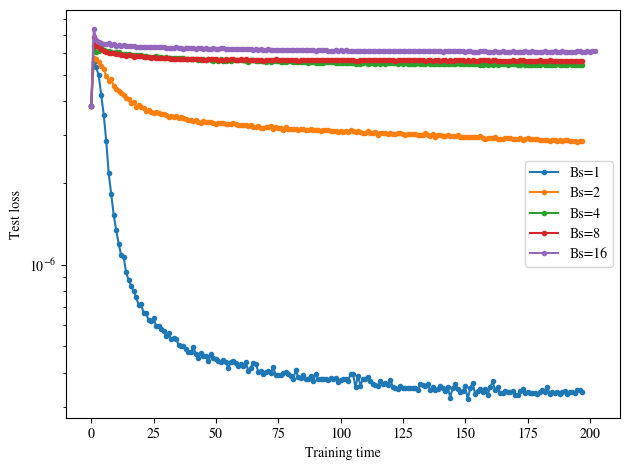

1: (2.0713129733021636-1.1903314269230016j)
2: (1.0533842544665424-0.018522342154417247j)
4: (1+0j)
8: (1+0j)
16: (1+0j)
1: 3.185609784850385e-07
2: 2.8348765681585064e-06
4: 3.84987288271077e-06
8: 3.84987288271077e-06
16: 3.84987288271077e-06


In [6]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/u1_3d/cv_4x4x8_5.55_dt4_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep2_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

### sweep4

jack bin size 1: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(4.309458565487515e-06+1.2409721737972243e-06j))
bin size 1: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(4.309451371725683e-06+1.2409679552190217e-06j))
jack bin size 2: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(6.029637815763714e-06+1.7322606509969128e-06j))
bin size 2: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(6.029634615304288e-06+1.7322601826353498e-06j))
jack bin size 4: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(8.393581650805725e-06+2.4038577952043385e-06j))
bin size 4: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(8.393577864444962e-06+2.403855914820498e-06j))
jack bin size 5: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(9.313268234751095e-06+2.6661683925762608e-06j))
bin size 5: (np.complex64(3.0462785e-05+2.9584527e-07j), np.complex128(9.313260606473427e-06+2.6661478751501704e-06j))
jack bin size 10: (np.complex

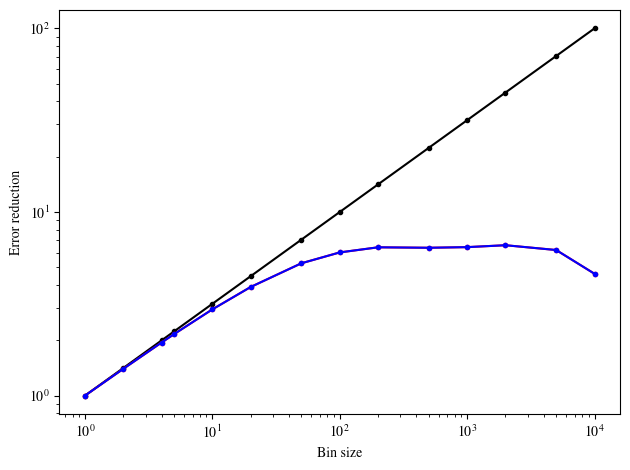

In [ ]:
model=eval("gauge.U1_3D_PBC(geom=(4, 4, 8),beta=5.55)")
V= model.dof
 
with open("u1_3d_pbc/config/c_4x4x8_5.55_single_sweep4.pkl", 'rb') as aa:
    conf = jnp.array(pickle.load(aa))

conf = jnp.log(conf).imag.reshape([len(conf), model.dof])

plaq_av_pmap = jax.pmap(jax.vmap(model.plaq_av))

av = jnp.mean(plaq_av_pmap(conf[:200000].reshape(num_devices,200000//num_devices,-1)), axis=(0, 1))

V = model.dof

av = jnp.mean(jax.vmap(model.plaq_av)(conf),axis = 0)

obs = jax.lax.map(lambda x: model.correlation(x, 4, av), conf, batch_size=1000)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.484069111890822e-05+1.3039382961063367e-05j))
bin size 1: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.484069035636704e-05+1.3039382849559704e-05j))
jack bin size 2: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.5386537693910896e-05+1.2613160676158652e-05j))
bin size 2: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.53865387219539e-05+1.2613161515896751e-05j))
jack bin size 4: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.351449520334459e-05+1.2796404486288541e-05j))
bin size 4: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.3514497955505847e-05+1.2796403762225176e-05j))
jack bin size 5: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.352282963895158e-05+1.3147577851982135e-05j))
bin size 5: (np.complex64(-1.1476298e-05+1.1828856e-05j), np.complex128(4.3522827446890995e-05+1.3147576022578633e-05j))
jack bin size 10: 

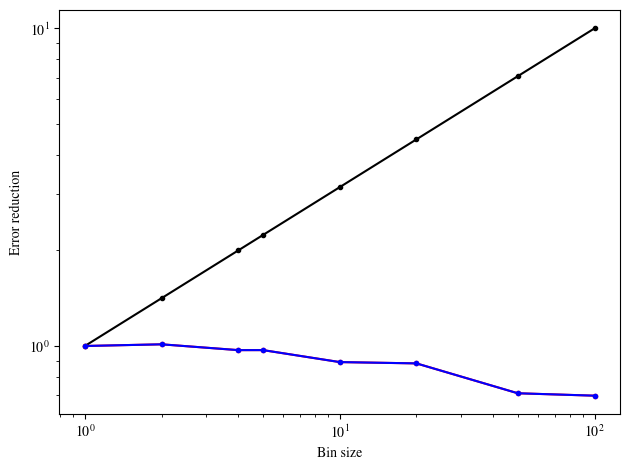

In [ ]:
obs = jax.vmap(lambda x: model.correlation(x, 4, av))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

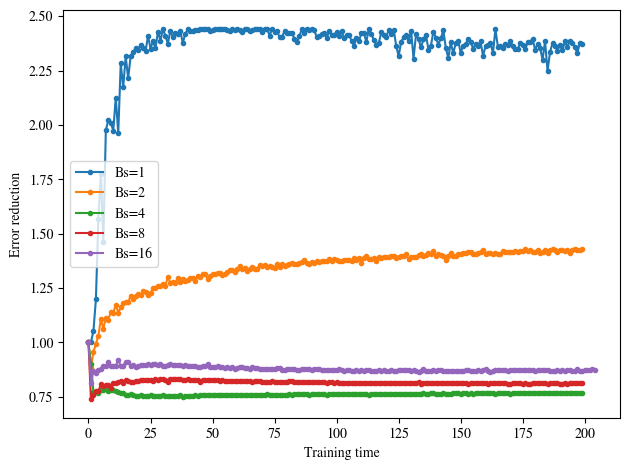

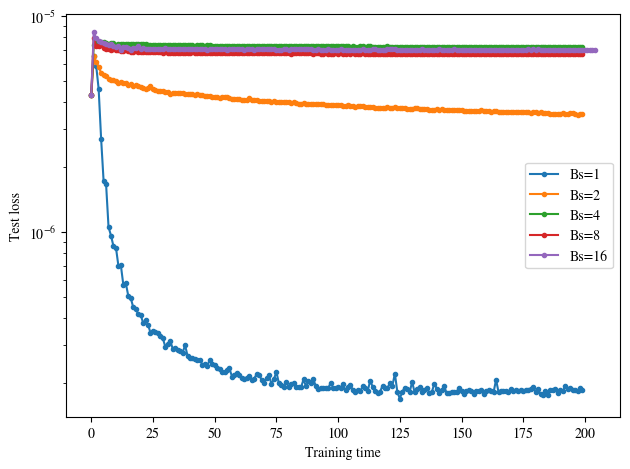

1: (2.443033576189059-1.8590480394396345j)
2: (1.4316656283253686-0.17248632678688422j)
4: (1+0j)
8: (1+0j)
16: (1+0j)
1: 1.6910713895867957e-07
2: 3.5029647733608726e-06
4: 4.296976385376183e-06
8: 4.296976385376183e-06
16: 4.296976385376183e-06


In [16]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/u1_3d/cv_4x4x8_5.55_dt4_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep4_bs"+str(binsize)+"_2h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

## 4x4x16

jack bin size 1: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(6.196695132467217e-06+1.7799367640826785e-06j))
bin size 1: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(6.196711073803667e-06+1.7799365714436874e-06j))
jack bin size 2: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(8.670770353956246e-06+2.4849090205982194e-06j))
bin size 2: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(8.670759595268551e-06+2.4849095822960558e-06j))
jack bin size 4: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(1.2068591888233137e-05+3.445670611056144e-06j))
bin size 4: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(1.2068578782641973e-05+3.4456701852874496e-06j))
jack bin size 5: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(1.3397410209142583e-05+3.8186633106642945e-06j))
bin size 5: (np.complex64(-2.9224452e-06+8.778818e-06j), np.complex128(1.339741044217525e-05+3.8186641509736645e-06j))
jack bin size 10: (np.comp

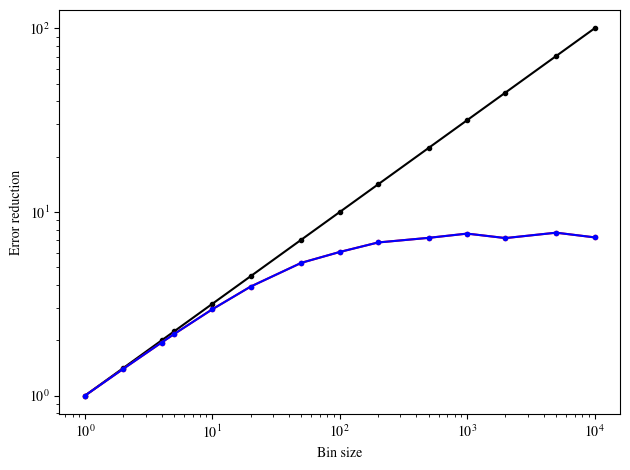

In [17]:
model=eval("gauge.U1_3D_PBC(geom=(4, 4, 16),beta=5.55)")
V= model.dof
 
with open("u1_3d_pbc/config/c_4x4x16_5.55_single_sweep16.pkl", 'rb') as aa:
    conf = jnp.array(pickle.load(aa))

conf = jnp.log(conf).imag.reshape([len(conf), model.dof])

plaq_av_pmap = jax.pmap(jax.vmap(model.plaq_av))

av = jnp.mean(plaq_av_pmap(conf[:200000].reshape(num_devices,200000//num_devices,-1)), axis=(0, 1))

V = model.dof

av = jnp.mean(jax.vmap(model.plaq_av)(conf),axis = 0)

obs = jax.lax.map(lambda x: model.correlation(x, 2, av), conf, batch_size=1000)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.327082578466624e-05+1.8143062696926835e-05j))
bin size 1: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.327082338913592e-05+1.814306119702272e-05j))
jack bin size 2: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.31493781421045e-05+1.8225563088951886e-05j))
bin size 2: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.314937082365973e-05+1.822556203546227e-05j))
jack bin size 4: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.1013916562580357e-05+1.8053376368497943e-05j))
bin size 4: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.101391566920864e-05+1.805337549674006e-05j))
jack bin size 5: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.131276877299581e-05+1.8488924038000846e-05j))
bin size 5: (np.complex64(9.855264e-06+2.4810954e-05j), np.complex128(6.131276999797083e-05+1.848892207159356e-05j))
jack bin size 10: (np.complex64(9.855264

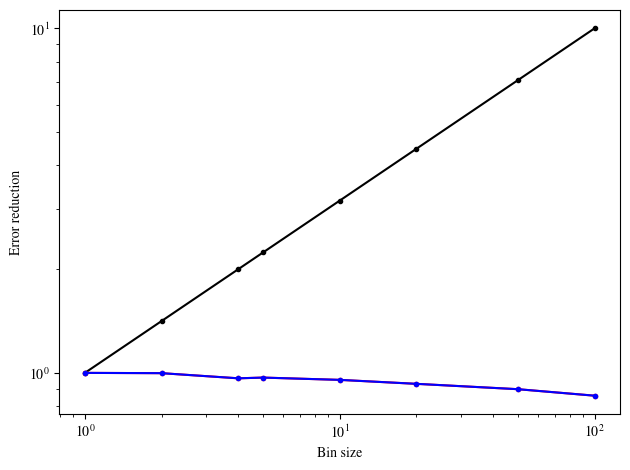

In [18]:
obs = jax.vmap(lambda x: model.correlation(x, 4, av))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

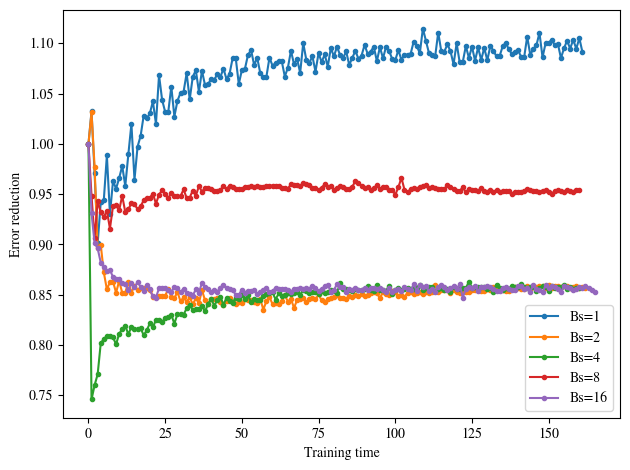

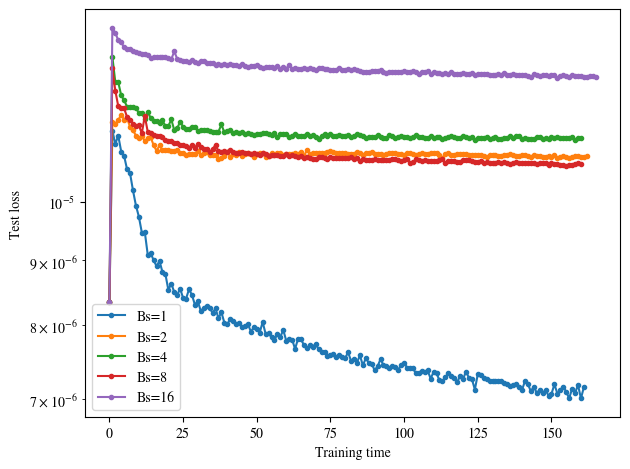

1: (1.114654236306546-0.02308096367054559j)
2: (1.0312467502463545-0.0058014681037609015j)
4: (1+0j)
8: (1+0j)
16: (1+0j)
1: 7.0086121013446245e-06
2: 8.339161468029488e-06
4: 8.339161468029488e-06
8: 8.339161468029488e-06
16: 8.339161468029488e-06


In [27]:
track_red, track_ltest = [], []

for binsize in 1, 2, 4, 8, 16:
    with open("correlated/u1_3d/cv_4x4x16_5.55_dt8_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep16_bs"+str(binsize)+"_4h.pkl", "rb") as aa:
        _, _, _, track_red_temp, track_ltest_temp = pickle.load(aa)
        track_red.append(track_red_temp)
        track_ltest.append(track_ltest_temp)


for i in range(5):
    plt.plot(np.arange(len(track_red[i])), np.asarray(track_red[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Error reduction')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    plt.plot(np.arange(len(track_ltest[i])), np.asarray(track_ltest[i])[:, 1].real,  marker='.', linestyle='-', label=f'Bs={2**i}')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Training time')
plt.ylabel('Test loss')
plt.tight_layout()
plt.legend()
plt.show()

for i in range(5):
    print(f"{2**i}: {np.array(track_red[i])[:,1].max()}")

for i in range(5):
    print(f"{2**i}: {np.array(track_ltest[i])[:,1].min()}")

In [16]:
np.arange(5), np.std(np.arange(5)), np.sqrt(np.mean((np.arange(5)-2)**2))

(array([0, 1, 2, 3, 4]),
 np.float64(1.4142135623730951),
 np.float64(1.4142135623730951))